# Question 2a script
### Is there a relationship between procedures performed and the provider tenure?
## Entrance criteria:
The intermediate dataset for <I>Procedures and Patients</I> has been created and includes:<br>
1. removal of rows with bad provider info (null for start date)
2. removal of duplicate rows

**Note, in order for the treemap code found below to work, this notebook needs to be run using "jupyter notebook", not "jupyter lab".


## Initialization of the script, loading libraries, etc.

In [1]:
# import the libraries needed

import numpy as np
import pandas as pd

# graphics based libraries that will be utilized throughout
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

import seaborn as sns
import plotly.express as px


In [2]:
# import the intermediate dataset into a baseline dataframe for future use
dfPatProc = pd.read_csv(r'../data/03_processed/ProceduresPatients-Intermediate.csv', 
                        na_values=['NA'])

# show the dimensions of the baseline dataframe
print(dfPatProc.shape)
# list the columns in the dataframe
dfPatProc.columns

(170072, 18)


Index(['PatientId', 'FRDPersonnelID', 'PatientOutcome', 'PatientGender',
       'DispatchTime', 'FRDPersonnelGender', 'FRDPersonnelStartDate',
       'Dim_Procedure_PK', 'Procedure_Performed_Code',
       'Procedure_Performed_Description', '_PK', 'TenureMonths',
       'PatientOutcomeCode', 'PatientGenderCode', 'PatientGender_Female',
       'PatientGender_Male', 'PatientGender_Unknown (Unable to Determine)',
       'ProviderGenderCode'],
      dtype='object')

Before going any further, let's get some common variables set up that will make generating and evaluating the different plots easier.

In [151]:
# set up variables to be used throughout
colorMap_scale = 'RdYlGn_r'
colorMap = 'muted'

ticklst_70000 = [1000,2000,3000,4000,5000,10000,15000,20000,25000,30000,35000,
                 40000,45000,50000,55000,60000,65000,70000]
xrng_70000 = [0,70000]
ticklst_2500 = [125,250,375,500,750,1000,1250,1500,1750,2000,2250,2500]
ticklst_2500_mj = [500,1000,1500,2000,2500]
ticklst_2500_mn = [125,250,375,750,1250,1750,2250]

#ticklst_2500 = [125,250,375,750,1250,1750,2250]
xrng_2500 = [0,2500]2500
ticklst_30000 = [1000,2000,3000,4000,5000,10000,15000,20000,25000,30000]
xrng_30000 = [0,30000]

ticklst_7000 = [250,500,750,1000,1250,1500,1750,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000]
xrng_7000 = [0,7000]

ticklst_5000 = [100,200,300,400,500,750,1000,1250,1500,1750,2000,2250,2500,
                2750,3000,3250,3500,3750,4000,4250,4500,4750,5000]
xrng_5000 = [0,5000]

ticklst_3000 = [125,250,375,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000]
xrng_3000 = [0,3000]

ticklst_2500 = [125,250,375,500,750,1000,1250,1500,1750,2000,2250,2500]
ticklst_2500_mj = [500,1000,1500,2000,2500]
ticklst_2500_mn = [125,250,375,750,1250,1750,2250]

#ticklst_2500 = [125,250,375,750,1250,1750,2250]
xrng_2500 = [0,2500]

ticklst_1500 = [125,250,375,500,750,1000,1200,1300,1400,1500]
xrng_1500 = [0,1500]

ticklst_500 = [50,100,150,200,250,300,350,400,450,500]
xrng_500 = [0,500]

ticklst_300 = [50,100,150,200,250,300]
xrng_300 = [0,300]

ticklst_200 = [25,50,75,100,125,150,200]
xrng_200 = [0,200]

In [4]:
# set up functions to be used throughout
#need to move all of the df functions here
def BuildTenureQntlDf(dfSource,qntl_start,qntl_end):
    dfTarget = dfSource[((dfSource['TenureYears'] >= (dfSource['TenureYears'].quantile(qntl_start))) & 
                         (dfSource['TenureYears'] < (dfSource['TenureYears'].quantile(qntl_end))))]
    return(dfTarget)


def BuildQntlTotDf(dfSource,col_code,col_desc):
    dfTarget = dfSource.groupby([col_code,col_desc])[["Procedure_Count"]].sum().reset_index()
    return(dfTarget)

## Validate dataset is ready for evaluation

In [5]:
# check unique procedure description count
print('Procedure Description Count = '+str(dfPatProc.Procedure_Performed_Description.nunique()))

# check unique procedure code count
print('Procedure Code Count = '+str(dfPatProc.Procedure_Performed_Code.nunique()))

Procedure Description Count = 68
Procedure Code Count = 67


As there known to be 67 unique procedures codes and there are 68 unique procedure descriptions, there must be a code with two descriptions.

In [6]:
# find the procedure code(s) with more than one description
dblCheck = dfPatProc[['Procedure_Performed_Code',
                  'Procedure_Performed_Description']].groupby('Procedure_Performed_Code',).nunique()

dblCheck[(dblCheck['Procedure_Performed_Description'] > 1)]

Procedure_Performed_Description
Procedure_Performed_Code                                 
427753009                                               2

In [7]:
# get the descriptions associated with the Procedure Code
procCode =  427753009   # is there a way to collect the value from dblCheck? 

dfPatProc[(dfPatProc['Procedure_Performed_Code'] == procCode)].Procedure_Performed_Description.unique()


array(['Airway - Supraglottic Airway (King, i-Gel)',
       'Airway - Supraglottic Airway (i-Gel, King)'], dtype=object)

Now that the descriptions have been found, they can be reset to be a common value of "Airway - Supraglottic Airway" instead of "Airway - Supraglottic Airway (King, i-Gel)" and "Airway - Supraglottic Airway (i-Gel, King)"

In [8]:
dfPatProc.replace(to_replace=['Airway - Supraglottic Airway (King, i-Gel)','Airway - Supraglottic Airway (i-Gel, King)'],
                  value='Airway - Supraglottic Airway',
                  inplace=True)

Confirm that the unique procedure count now matches the procedure code count of 67.

In [9]:
# get unique procedure count
print('Procedure Description Count = ' + str(dfPatProc.Procedure_Performed_Description.nunique()))

Procedure Description Count = 67


Next, check for any null values

In [10]:
dsNumNull=dfPatProc.isnull().sum()
dsNumNull.name='Number Rows With Nulls'
print(dsNumNull)

PatientId                                        0
FRDPersonnelID                                   0
PatientOutcome                                   0
PatientGender                                  104
DispatchTime                                     0
FRDPersonnelGender                               0
FRDPersonnelStartDate                            0
Dim_Procedure_PK                                 0
Procedure_Performed_Code                         0
Procedure_Performed_Description                  0
_PK                                              0
TenureMonths                                     0
PatientOutcomeCode                               0
PatientGenderCode                                0
PatientGender_Female                             0
PatientGender_Male                               0
PatientGender_Unknown (Unable to Determine)      0
ProviderGenderCode                               0
Name: Number Rows With Nulls, dtype: int64


PatientGender is not an attribute that will be used in this evaluation, so the null values can be ignored since in fact the column will be dropped next.

There are no null values to be addressed.

In addition to PatientGender, there are attributes that are no relevant to this evaluation.  Drop the columns that we will not be using - 'PatientOutcome', 'PatientGender', 'FRDPersonnelGender', '_PK', 'PatientOutcomeCode', 'PatientGenderCode', 'PatientGender_Female', 'PatientGender_Male', 'PatientGender_Unknown (Unable to Determine)', 'ProviderGenderCode', 'Dim_Procedure_PK'

In [11]:
#dfPP_working = dfPatProc.drop(columns=['Unnamed: 0', 'PatientOutcome', 'PatientGender', 'FRDPersonnelGender', '_PK', 
dfPP_working = dfPatProc.drop(columns=['PatientOutcome', 'PatientGender', 'FRDPersonnelGender', '_PK', 
                                       'PatientOutcomeCode', 'PatientGenderCode', 'PatientGender_Female', 'PatientGender_Male', 
                                       'PatientGender_Unknown (Unable to Determine)', 'ProviderGenderCode','Dim_Procedure_PK'])
dfPP_working.head(5)

PatientId                        FRDPersonnelID         DispatchTime  \
0     479853  58D5C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 00:04:06   
1     479853  58D5C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 00:04:06   
2     479853  58D5C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 00:04:06   
3     479853  58D5C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 00:04:06   
4     479862  32D8C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 00:44:31   

  FRDPersonnelStartDate  Procedure_Performed_Code  \
0            2004-07-12                 392230005   
1            2004-07-12                 268400002   
2            2004-07-12                 268400002   
3            2004-07-12                 268400002   
4            2006-12-11                 392230005   

          Procedure_Performed_Description  TenureMonths  
0  IV Start - Extremity Vein (arm or leg)           161  
1             CV - ECG - 12 Lead Obtained           161  
2             CV - ECG - 12 Lead Obtained           161  
3             CV - ECG - 12 Lead Obtained           161  
4  IV Start - Extremity Vein (arm or leg)           132

## Initial evaluation of Tenure in the dataset

Since we will be looking at the tenure throughout, we need to take a preliminary look at the dataset and be sure there are no inconsitencies with respect to the attribute.  Given that there are over 170,000 records in the dataset, the number of bins utilized initially in the histogram will be 15 in order to see any macro issues with respect to tenure.

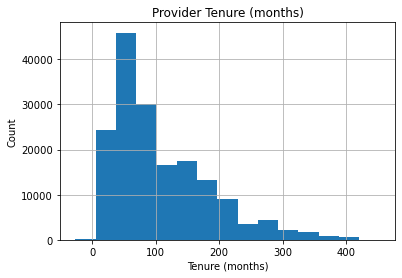

In [12]:
# histogram of tenure in months
fig,ax=plt.subplots()
ax.hist(x=dfPP_working['TenureMonths'], bins = 15)
ax.set_xlabel('Tenure (months)')
ax.set_ylabel('Count')
ax.set_title('Provider Tenure (months)')
ax.ticklabel_format(style='plain')
ax.grid()
#plt.xticks(rotation=45)
plt.show()

In [13]:
dfPP_working[['TenureMonths']].describe()

TenureMonths
count  170072.000000
mean      106.863746
std        77.888722
min       -27.000000
25%        49.000000
50%        82.000000
75%       152.000000
max       453.000000

In [14]:
print(" ".join(["The mean of the unique Tenure in Months values:",str(dfPP_working.TenureMonths.unique().mean())]))

The mean of the unique Tenure in Months values: 211.20594965675056


Confirmed by the descriptive statistics of the Tenure attribute in the dfPP_working dataframe, there is evidence of negative tenures present - aka "time travelers".  Since the calculation for tenure is based on the difference between the provider start date and dispatch date attributes, having a negative tenure is possible but the reality does not make sense.

How many "time traveler" records are there?

In [15]:
# extract the records with a time traveler for a provider and put them in a new dataset (tenure is negative)
dfTimeTravelers=dfPP_working[(dfPP_working["TenureMonths"] < 0)]

print("dfTimeTravelers -> {}".format(len(dfTimeTravelers)))

dfTimeTravelers -> 21


Identify the providers that are time traveling in these 21 records.

In [16]:
# print the provider id for the time travelers
print(dfTimeTravelers.FRDPersonnelID.drop_duplicates())

532       DDB27180-A778-4655-8FC6-F9511F36175B
2380      3FD2C99E-9E01-E211-B5F5-78E7D18CFD3C
9904      6FB584B8-F37D-45E3-8FCC-C820ACF46816
64027     86D2C99E-9E01-E211-B5F5-78E7D18CFD3C
169822    380F3265-F26A-4EF1-A1AD-5D8A9E41D12A
Name: FRDPersonnelID, dtype: object


Remove the time travelers from the working dataset.  Since there are only 21 records, removing the time travelers will only have an impact on the Tenure statistics, but will not have a significant impact on the overall evalution.

In [17]:
# create a new dataframe that does not include the time travelers and will serve as the baseline dataframe
dfPPBaseline = dfPP_working[(dfPP_working['TenureMonths'] >= 0)]

print("dfPPBaseline -> {}".format(len(dfPPBaseline)))

dfPPBaseline -> 170051


In [18]:
# show the difference in the count of records now that the time travelers have been dropped
print("dfPP_working -> {}\ndfPPBaseline -> {}".format(len(dfPP_working),len(dfPPBaseline)))
print("record difference -> {}".format(len(dfPP_working)-len(dfPPBaseline)))

dfPP_working -> 170072
dfPPBaseline -> 170051
record difference -> 21


Rerun the baseline statistics for Tenure after removing the Time Travelers to confirm that the minimum is now 0.

In [19]:
dfPPBaseline[['TenureMonths']].describe()

TenureMonths
count  170051.000000
mean      106.878683
std        77.881907
min         0.000000
25%        49.000000
50%        82.000000
75%       152.000000
max       453.000000

In [20]:
print(" ".join(["The mean of the unique Tenure in Months values (after dropping Time Travelers):",str(dfPPBaseline.TenureMonths.unique().mean())]))

The mean of the unique Tenure in Months values (after dropping Time Travelers): 214.89767441860465


Add a column to hold the value of tenure in years.

Divide the TenureMonths by 12 and drop the remainder.
__Calculation of Tenure in Months results in value that represents number of completed years of service.  (e.g. 35 months -> 2 years, 36 months -> 3 years)__

In [21]:
dfPPBaseline.loc[:,"TenureYears"]=np.floor(dfPPBaseline["TenureMonths"]/12)
dfPPBaseline.shape

C:\Users\gecko\Anaconda3\envs\emspe\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\gecko\Anaconda3\envs\emspe\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


(170051, 8)

In [22]:
print(" ".join(["The mean of the unique Tenure in Years values:",str(dfPPBaseline.TenureYears.unique().mean())]))

The mean of the unique Tenure in Years values: 18.5


Set up a tenure category to identify whether the provider tenure in the record is

0 - less than 5 years, 1 - 5 through 9 years, 2 - 10 through 14 years, 3 - 15 through 19 years, 4 - 20 through 24 years, 5 - 25 through 29 years, 6 - greater than or equal to 30 years

In [23]:
# use the listing to build a Year listing that contains list of unique years
yrVC = dfPPBaseline.TenureYears.unique()
yrVC.sort()
dfYearList = pd.DataFrame(yrVC)
dfYearList.reset_index(inplace=True)
dfYearList.columns=['YearIndex','TenureYears']
dfYearList.set_index(keys=['YearIndex'])
dfYearList.head(10)

YearIndex  TenureYears
0          0          0.0
1          1          1.0
2          2          2.0
3          3          3.0
4          4          4.0
5          5          5.0
6          6          6.0
7          7          7.0
8          8          8.0
9          9          9.0

In [24]:
yr_grp_idx = np.arange(0,7)
dfYrGrp = pd.DataFrame({"YearGroup" : ['< 5','5-9','10-14','15-19', '20-24','25-29','>= 30'],
                          "YearGrpCode": yr_grp_idx},
                          index = yr_grp_idx)
# assign the appropriate procedure category code to the list of procedures
dfYearList["YearGrpCode"]=[0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5,6,6,6,6,6,6,6,6]
# now that dfYrList includes the procedure category keys/index values, merge the two dataframes to also include the labels
dfYearList=pd.merge(dfYearList, dfYrGrp,on="YearGrpCode",how="left")

print(dfYearList.head(3))
print(dfYearList.tail(3))

   YearIndex  TenureYears  YearGrpCode YearGroup
0          0          0.0            0       < 5
1          1          1.0            0       < 5
2          2          2.0            0       < 5
    YearIndex  TenureYears  YearGrpCode YearGroup
35         35         35.0            6     >= 30
36         36         36.0            6     >= 30
37         37         37.0            6     >= 30


In [25]:
# create a procedure order array
YearGrpOrder = np.array(dfYearList['YearGroup'].unique())
YearGrpOrder

array(['< 5', '5-9', '10-14', '15-19', '20-24', '25-29', '>= 30'],
      dtype=object)

In [26]:
# add the category information to the baseline dataframe
dfPPBaselineYr = pd.merge(dfPPBaseline,dfYearList[["TenureYears","YearGrpCode","YearGroup"]]
                          ,on='TenureYears',how="left")
dfPPBaselineYr.head(10)


PatientId                        FRDPersonnelID         DispatchTime  \
0     479853  58D5C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 00:04:06   
1     479853  58D5C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 00:04:06   
2     479853  58D5C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 00:04:06   
3     479853  58D5C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 00:04:06   
4     479862  32D8C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 00:44:31   
5     479862  1D18E8FC-EE92-E211-A596-78E7D18C3D20  2018-01-01 00:44:31   
6     479862  1D18E8FC-EE92-E211-A596-78E7D18C3D20  2018-01-01 00:44:31   
7     479862  1D18E8FC-EE92-E211-A596-78E7D18C3D20  2018-01-01 00:44:31   
8     479876  33D8C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 00:42:53   
9     479889  E4D8C99E-9E01-E211-B5F5-78E7D18CFD3C  2018-01-01 01:15:31   

  FRDPersonnelStartDate  Procedure_Performed_Code  \
0            2004-07-12                 392230005   
1            2004-07-12                 268400002   
2            2004-07-12                 268400002   
3            2004-07-12                 268400002   
4            2006-12-11                 392230005   
5            2012-09-24                 268400002   
6            2012-09-24                 268400002   
7            2012-09-24                 392230005   
8            1995-11-13                 392230005   
9            2002-07-13                 392230005   

          Procedure_Performed_Description  TenureMonths  TenureYears  \
0  IV Start - Extremity Vein (arm or leg)           161         13.0   
1             CV - ECG - 12 Lead Obtained           161         13.0   
2             CV - ECG - 12 Lead Obtained           161         13.0   
3             CV - ECG - 12 Lead Obtained           161         13.0   
4  IV Start - Extremity Vein (arm or leg)           132         11.0   
5             CV - ECG - 12 Lead Obtained            63          5.0   
6             CV - ECG - 12 Lead Obtained            63          5.0   
7  IV Start - Extremity Vein (arm or leg)            63          5.0   
8  IV Start - Extremity Vein (arm or leg)           265         22.0   
9  IV Start - Extremity Vein (arm or leg)           185         15.0   

   YearGrpCode YearGroup  
0            2     10-14  
1            2     10-14  
2            2     10-14  
3            2     10-14  
4            2     10-14  
5            1       5-9  
6            1       5-9  
7            1       5-9  
8            4     20-24  
9            3     15-19

## Initial evaluation of Procedures within the dataset

In [27]:
# check out the value counts for the different procedures
dfPPBaselineYr[["Procedure_Performed_Description","Procedure_Performed_Code"]].value_counts()

Procedure_Performed_Description             Procedure_Performed_Code
CV - ECG - 12 Lead Obtained                 268400002                   66972
IV Start - Extremity Vein (arm or leg)      392230005                   59835
Electrocardiographic monitoring             46825001                     4755
MS - Cervical Spinal Restriction of Motion  398041008                    4693
Assess - Assessment of Patient              422618004                    4192
                                                                        ...  
Laryngoscopy - Indirect                     673005                          4
Intubation - Existing Tracheostomy Stoma    232685002                       3
Infectious - Decontamination of Patient     409530006                       3
Enviro - Hypothermia Induction Therapy      430189000                       3
Cricothyrotomy - Needle                     232689008                       3
Length: 67, dtype: int64

In [28]:
# use the listing to build a Procedures listing that is ordered from largest count to smallest
procVC = dfPPBaselineYr[["Procedure_Performed_Description","Procedure_Performed_Code"]].value_counts()
dfProcList = pd.DataFrame(procVC)
dfProcList.reset_index(inplace=True)
dfProcList.columns=['Procedure_Description','Procedure_Performed_Code','Procedure_Total']
dfProcList.set_index(keys=['Procedure_Description'])
dfProcList

Procedure_Description  Procedure_Performed_Code  \
0                  CV - ECG - 12 Lead Obtained                 268400002   
1       IV Start - Extremity Vein (arm or leg)                 392230005   
2              Electrocardiographic monitoring                  46825001   
3   MS - Cervical Spinal Restriction of Motion                 398041008   
4               Assess - Assessment of Patient                 422618004   
..                                         ...                       ...   
62                     Laryngoscopy - Indirect                    673005   
63    Intubation - Existing Tracheostomy Stoma                 232685002   
64     Infectious - Decontamination of Patient                 409530006   
65      Enviro - Hypothermia Induction Therapy                 430189000   
66                     Cricothyrotomy - Needle                 232689008   

    Procedure_Total  
0             66972  
1             59835  
2              4755  
3              4693  
4              4192  
..              ...  
62                4  
63                3  
64                3  
65                3  
66                3  

[67 rows x 3 columns]

In [29]:
# save the overall procedure count to a variable
proc_count_all = len(dfProcList)
#print(proc_count_all)

# create a procedure order array
ProcOrder = np.array(dfProcList['Procedure_Description'])
ProcOrder

array(['CV - ECG - 12 Lead Obtained',
       'IV Start - Extremity Vein (arm or leg)',
       'Electrocardiographic monitoring',
       'MS - Cervical Spinal Restriction of Motion',
       'Assess - Assessment of Patient',
       'Assess - Blood Glucose Level (BGL)',
       'CV - ECG - Limb Lead Monitoring', 'Assess - Capnography (ETCO2)',
       'IO Start - Intraosseous Access',
       'MS - Full Spinal Restriction of Motion', 'Wound Care - General',
       'CV - Defibrillation - Manual', 'MS - Splinting - General',
       'Resp - Assist Ventilation - BVM Via Mask',
       'Resp - Assisted Ventilation - CPAP',
       'Assess - Capnograph waveform', 'CPR - Manual',
       'Airway - Supraglottic Airway',
       'Enviro - Patient Cooling (Cold Pack or General)',
       'CPR - Mechanical Device', 'IV Start - EJ (External Jugular Vein)',
       'Airway - Oropharyngeal Insertion',
       'Wound Care - Dressing - Pressure Dressing',
       'Airway - Nasopharyngeal Insertion', 'Airway - Clear

Run a baseline histogram of procedures performed.

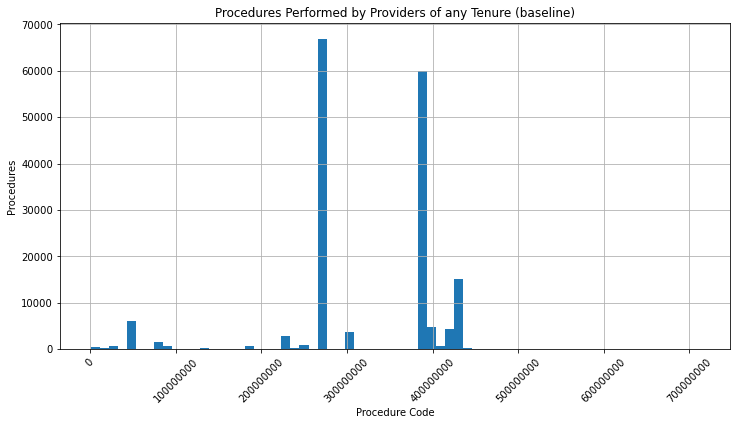

In [30]:
# histogram of procedures performed using original data
fig,ax=plt.subplots(figsize=(12,6))
ax.hist(x=dfPPBaseline['Procedure_Performed_Code'], bins=len(dfProcList))
ax.set_xlabel('Procedure Code')
ax.set_ylabel('Procedures')
ax.set_title('Procedures Performed by Providers of any Tenure (baseline)')
ax.ticklabel_format(style='plain')
ax.grid()
plt.xticks(rotation=45)
plt.show()

Run a baseline pie chart to better see the distribution of the procedures by procedure name.

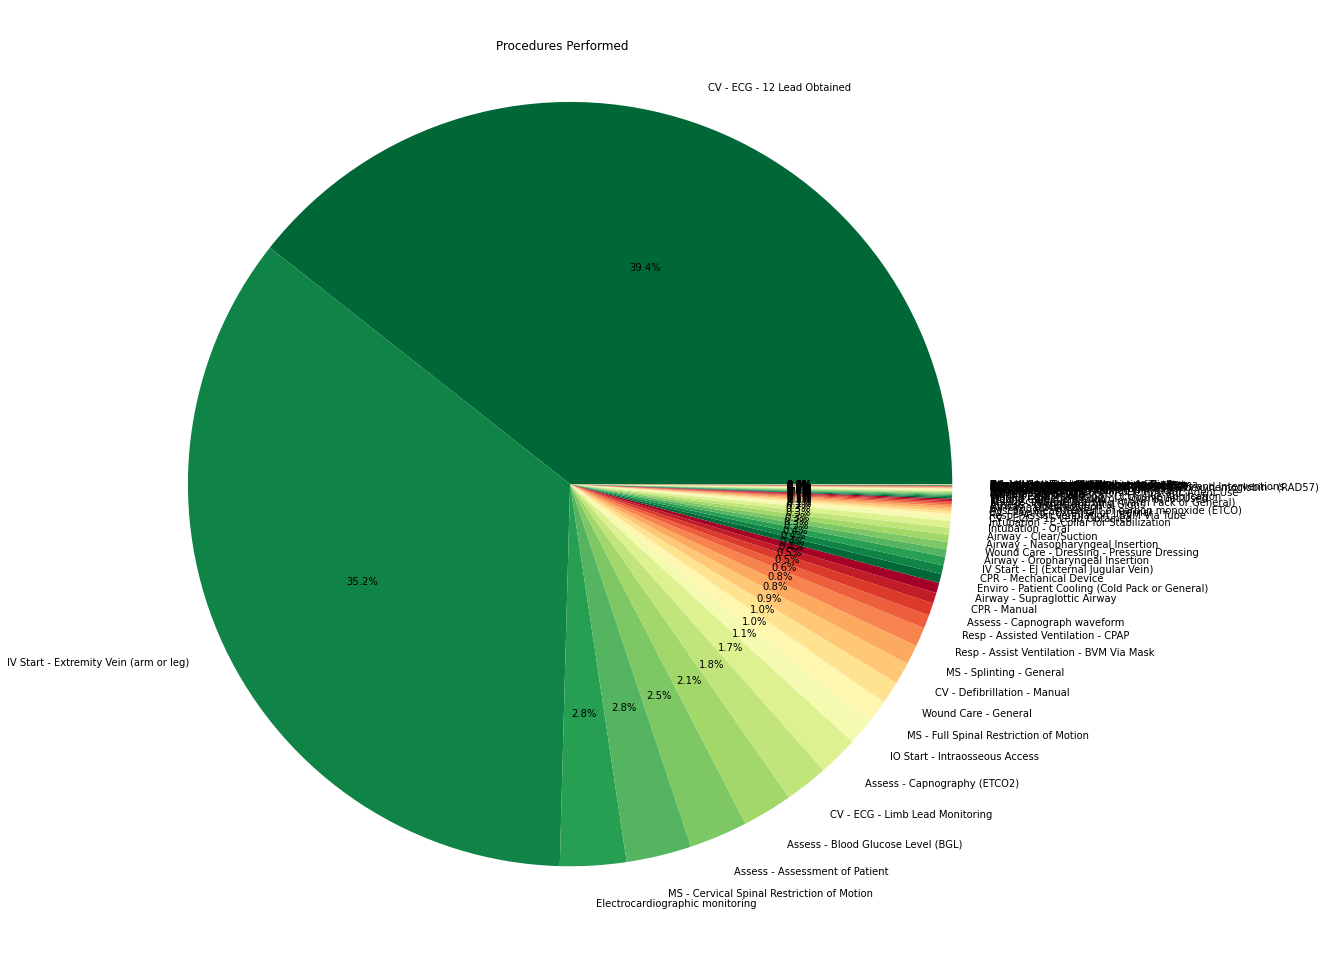

In [31]:
# build the labels and counts to display
# based on https://blog.algorexhealth.com/2018/03/almost-10-pie-charts-in-10-python-libraries/
source_labels = dfProcList.Procedure_Description
source_counts = dfProcList.Procedure_Total

# select the colors to use
cmap = plt.get_cmap(colorMap)
colors = [cmap(i) for i in np.linspace(0, 1, 18)]

fig,ax=plt.subplots(figsize=(14,14))
fig.tight_layout()
fig.subplots_adjust(top=1.05)
fig.suptitle("Procedures Performed")

ax.pie(x=source_counts,labels=source_labels,autopct='%1.1f%%', colors=colors)
#ax.set_title("Procedures Performed")
plt.show()

With so many procedures ocurring very few times, let's group some of them together so a more readable chart is possible

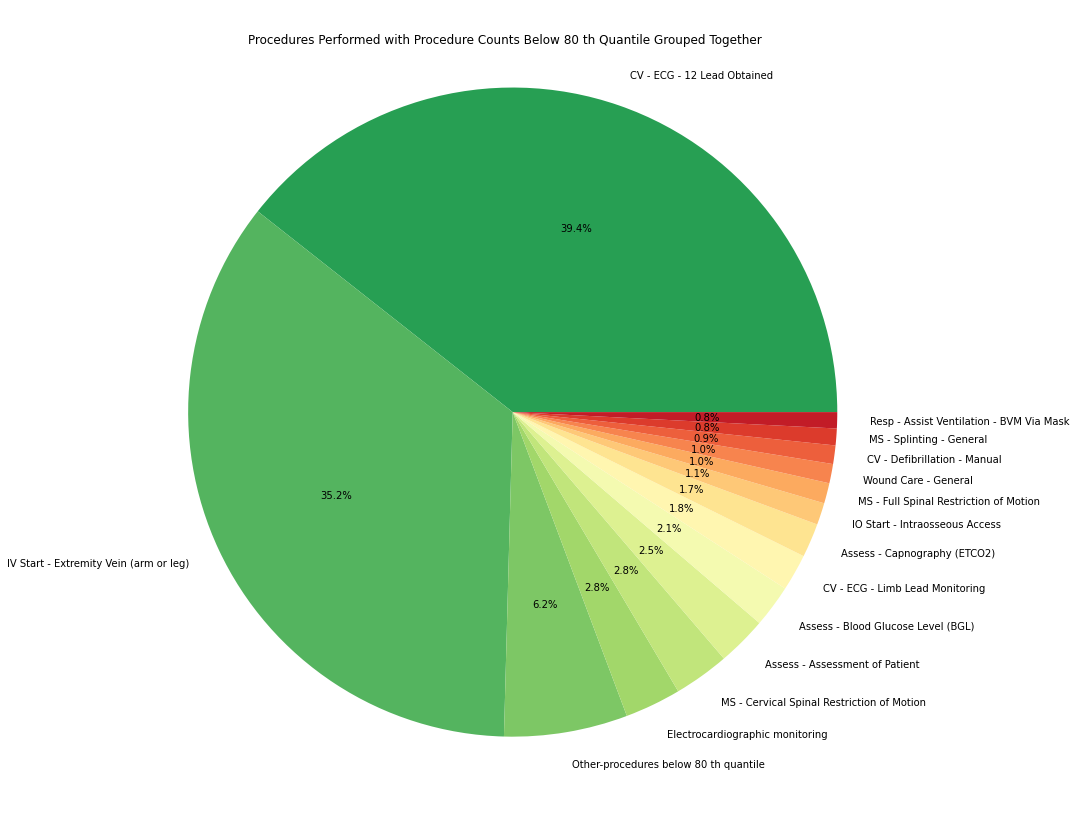

In [32]:
def group_lower_ranking_values(qntl_val,column,df_base):
    # based on https://blog.algorexhealth.com/2018/03/almost-10-pie-charts-in-10-python-libraries/
    col_sum = df_base.groupby(column).agg('sum')
    pct_value = col_sum[lambda df: df.columns[0]].quantile(qntl_val/100)
    values_below_pct_value = col_sum[lambda df: df.columns[0]].loc[lambda s: s < pct_value].index.values
    def fix_values(row):
        if row[column] in values_below_pct_value:
            row[column] = " ".join(['Other-procedures below',str(qntl_val),'th quantile'])
        return row 
    proc_grouped = df_base.apply(fix_values, axis=1).groupby(column).agg('sum')
    return proc_grouped

qntl_val = 80
dfProcGrpPie = group_lower_ranking_values(qntl_val,'Procedure_Description',dfProcList[['Procedure_Description','Procedure_Total']]).sort_values("Procedure_Total", ascending=False).reset_index()

# build the labels and counts to display
source_labels = dfProcGrpPie.Procedure_Description
source_counts = dfProcGrpPie.Procedure_Total
fig,ax=plt.subplots(figsize=(12,12))
fig.tight_layout()
fig.subplots_adjust(top=1.05)
fig.suptitle(" ".join(["Procedures Performed with Procedure Counts Below",str(qntl_val),"th Quantile Grouped Together"]))

ax.pie(x=source_counts,labels=source_labels,autopct='%1.1f%%', colors=colors[2:18])
#ax.set_title(" ".join(["Procedures Performed with Procedure Counts Below",str(qntl_val),"th Quantile Grouped Together"]))
plt.show()

Make the pie chart into a donut chart in order to see elements more easily

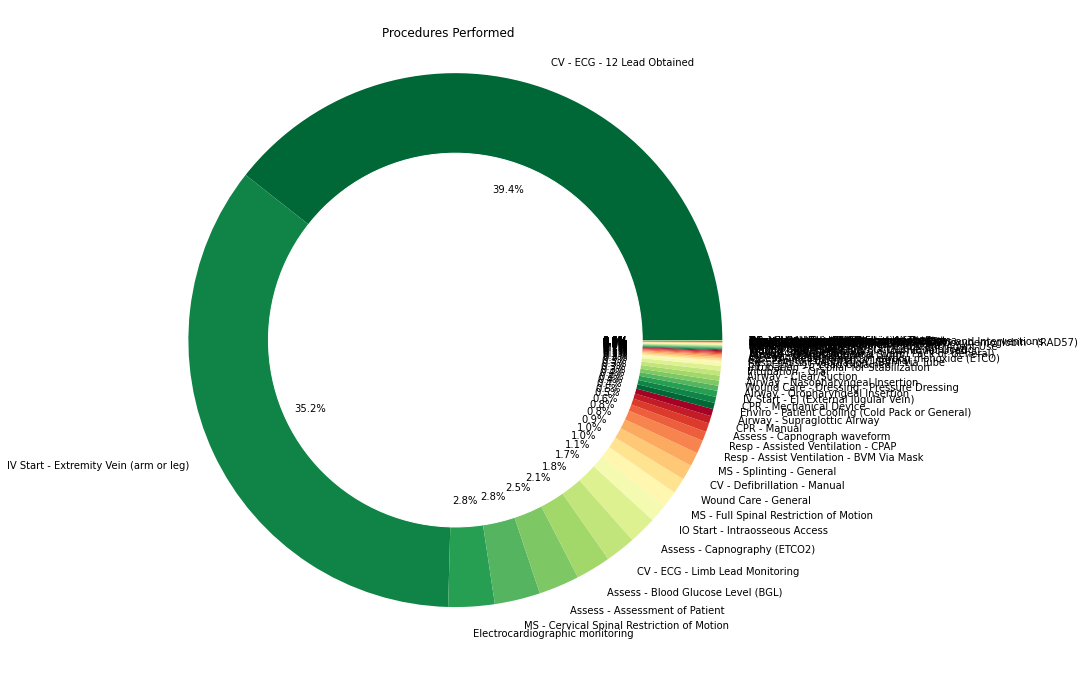

In [33]:
# build the labels and counts to display
source_labels = dfProcList.Procedure_Description
source_counts = dfProcList.Procedure_Total

# select the colors to use
cmap = plt.get_cmap(colorMap)
colors = [cmap(i) for i in np.linspace(0, 1, 18)]

fig,ax=plt.subplots(figsize=(10,10))
fig.tight_layout()
fig.subplots_adjust(top=1.05)
fig.suptitle("Procedures Performed")

ax.pie(x=source_counts,labels=source_labels,autopct='%1.1f%%', colors=colors)
circle1=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle1)
#ax.set_title("Procedures Performed")
plt.show()

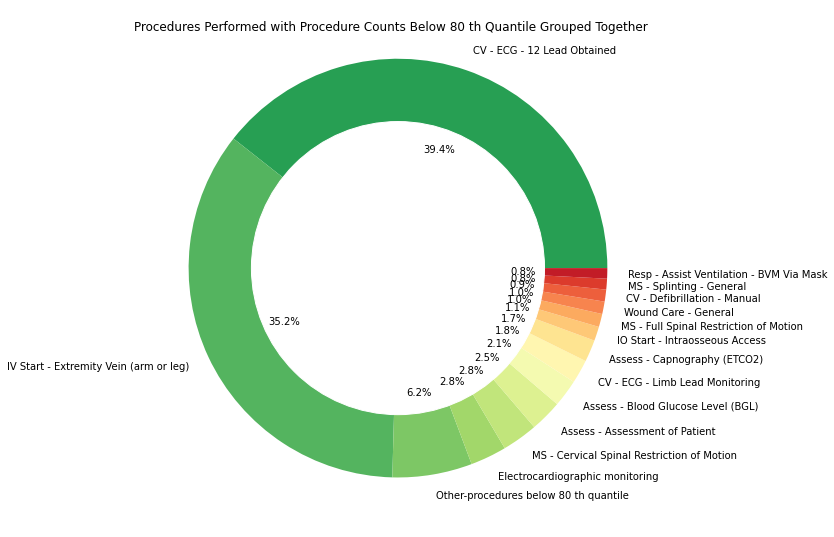

In [34]:
# using the grouped pie chart dataframe, dfProcGrpPie, generated earlier create a donut chart

# build the labels and counts to display
source_labels = dfProcGrpPie.Procedure_Description
source_counts = dfProcGrpPie.Procedure_Total
fig,ax=plt.subplots(figsize=(8,8))
fig.tight_layout()
fig.subplots_adjust(top=1.05)
fig.suptitle(" ".join(["Procedures Performed with Procedure Counts Below",str(qntl_val),"th Quantile Grouped Together"]))

ax.pie(x=source_counts,labels=source_labels,autopct='%1.1f%%', colors=colors[2:18])
circle2=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle2)

plt.show()

Let's build another donut chart that only has 3 sections - 1 for ECG 12 Lead, 1 for IV Start, and 1 for everything else.  It will be easier to see the influence exerted by the ECG 12 Lead and IV Start procedures.

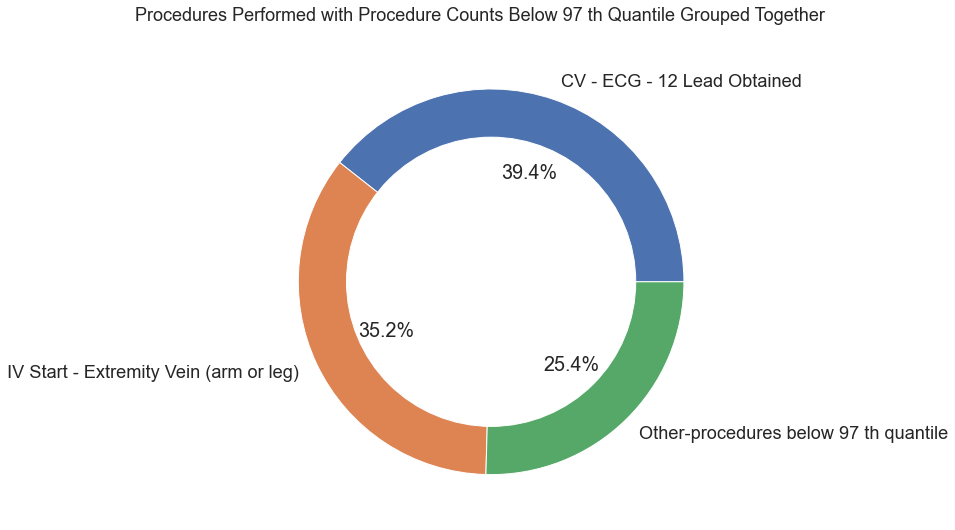

In [200]:
# building a new data source so the donut chart only shows 3 categories ECG 12 Lead, IV Start, and Other
# use default colors
qntl_val = 97
dfProcGrpPie2 = group_lower_ranking_values(qntl_val,'Procedure_Description',
                                          dfProcList[['Procedure_Description',
                                                      'Procedure_Total']]).sort_values("Procedure_Total", 
                                                                                       ascending=False).reset_index()

# build the labels and counts to display
source_labels = dfProcGrpPie2.Procedure_Description
source_counts = dfProcGrpPie2.Procedure_Total
fig,ax=plt.subplots(figsize=(8,8))
fig.tight_layout()
fig.subplots_adjust(top=1.85)
fig.subplots_adjust(top=0.92)
fig.suptitle(" ".join(["Procedures Performed with Procedure Counts Below",str(qntl_val),
                       "th Quantile Grouped Together"]), fontsize=18)

ax.pie(x=source_counts,labels=source_labels,autopct='%1.1f%%')
circle2=plt.Circle( (0,0), 0.75, color='white')
p=plt.gcf()
p.gca().add_artist(circle2)

plt.show()

Using the same dataframes used to generate the donut charts, build some treemaps.  The treemaps will show same unbalance that the donut charts do. However, they show disparity differently based on rectangle size and color (based on scale).

** Note the treemaps will not display when using jupyter lab.

In [152]:
# using the procedure listing dataframe, dfProcList, create a treemap
# if run under jupyter lab, chart will not display
df = dfProcList.copy()
df["start_pt"] = "FCFRD"
fig = px.treemap(df, path=['start_pt','Procedure_Description'], values='Procedure_Total',
                 color="Procedure_Description", color_continuous_scale=colorMap, color_continuous_midpoint=np.average(df["Procedure_Total"]))
fig.show()

In [37]:
# using the grouped pie chart dataframe, dfProcGrpPie, generated earlier create a treemap
# if run under jupyter lab, chart will not display
df = dfProcGrpPie.copy()
df["start_pt"] = "FCFRD"
fig = px.treemap(df, path=['start_pt','Procedure_Description'], values='Procedure_Total',
                 color="Procedure_Description", color_continuous_scale=colorMap, color_continuous_midpoint=np.average(df["Procedure_Total"]))
fig.show()

Using the dfProcList dataframe, are there any descriptive statistics that can be seen with respect to the Procedure Totals?

In [38]:
dfProcList[['Procedure_Total']].describe()

Procedure_Total
count        67.000000
mean       2538.074627
std       10834.920102
min           3.000000
25%          30.000000
50%         106.000000
75%         755.500000
max       66972.000000

The values range from a minimun of 3 to a maximum of 66,972.  The mean of 2,538.1 and standard deviation of 10,834.9 support the chart depictions of an unbalanced dataset.

Dropping the two largest procedure counts, how do the descriptive statistics change?

In [39]:
dfProcList[((dfProcList['Procedure_Description'] != "IV Start - Extremity Vein (arm or leg)") & 
            (dfProcList['Procedure_Description'] != "CV - ECG - 12 Lead Obtained"))][['Procedure_Total']].describe()

Procedure_Total
count        65.000000
mean        665.292308
std        1155.549095
min           3.000000
25%          29.000000
50%         100.000000
75%         647.000000
max        4755.000000

While the mean and standard deviation are now closer, they still indicate a dataset with procedure counts that are widely disparate despite the fact the largest procedure count is now only 4,755.  The value of the 75th percentile has a significant change due to the removal of the two high count values.  The 25th and 50h percentiles, while shifting, are not significantly different.

### Build a category listing for procedures, so similar procedures can be grouped together and used later on


In [40]:
# review current dfProcList
dfProcList.head(5)

Procedure_Description  Procedure_Performed_Code  \
0                 CV - ECG - 12 Lead Obtained                 268400002   
1      IV Start - Extremity Vein (arm or leg)                 392230005   
2             Electrocardiographic monitoring                  46825001   
3  MS - Cervical Spinal Restriction of Motion                 398041008   
4              Assess - Assessment of Patient                 422618004   

   Procedure_Total  
0            66972  
1            59835  
2             4755  
3             4693  
4             4192

In [41]:
# find all of the procedures that are CV - ECG variations
dfProcList[dfProcList['Procedure_Description'].str.contains("CV - ECG")]

Procedure_Description  Procedure_Performed_Code  Procedure_Total
0       CV - ECG - 12 Lead Obtained                 268400002            66972
6   CV - ECG - Limb Lead Monitoring                 428803005             3114
27      CV - ECG - 15 Lead Obtained                 429163003              214

The 12 Lead and 15 Lead ECGs are variations of the same procedure, just with a differnt count of leads involved. However, the Limb Lead Monitoring ECG is an older technique.  Therefore the two types of ECG will be categorized separateley.

The categories to be set up are:

'Exclude','Airway - Clear/Suction','Airway - Foreign Body Removal','BLS Airway','Airway - Supraglottic Airway', 'Assessment','Behavior - Restraint Applied','CPR','Cricothyrotomy','CV - Cardioversion', 'CV - Defibrillation - Manual','CV - ECG','CV - Pacing','CV - Vagal Maneuver','Decompression - Chest Decompression', 'Enviro - Patient Cooling','Enviro - Patient Warming','Gen''l - Irrigation - Eye(s)','Intubation - Existing Tracheostomy Stoma', 'Intubation/Laryngoscopy','IO Start - Intraosseous Access','IV Start - Vein','MS - Restriction of Motion','MS - Splinting', 'Pelvic splint device','Resp - Assist Ventilation','Resp - Assisted Ventilation - CPAP','Warming - Use of IV/IO Fluid Warmer', 'Wound - Bleeding Control','Wound Care - Dressing - Occlusive Application','CV - ECG - Limb Lead Monitoring'

In [42]:
# build a category dataframe for 30 different categories
proc_cat_idx = np.arange(0,31)
dfProcCat = pd.DataFrame({"ProcedureCategory" : ['Exclude','Airway - Clear/Suction','Airway - Foreign Body Removal',
                                                 'Airway - Supraglottic Airway','Assessment',
                                                 'Behavior - Restraint Applied','BLS Airway','CPR','Cricothyrotomy',
                                                 'CV - Cardioversion','CV - Defibrillation - Manual','CV - ECG - 12/15',
                                                 'CV - ECG - Limb','CV - Pacing','CV - Vagal Maneuver','Chest Decompression',
                                                 'Enviro - Patient Cooling','Enviro - Patient Warming',
                                                 'Gen''l - Irrigation - Eye(s)','Intubation - Existing Tracheostomy Stoma',
                                                 'Intubation/Laryngoscopy','IO Start - Intraosseous Access',
                                                 'IV Start - Vein','MS - Restriction of Motion','MS - Splinting',
                                                 'Pelvic splint device','Resp - Assist Ventilation','Resp - Assisted Ventilation - CPAP',
                                                 'Warming - Use of IV/IO Fluid Warmer','Wound - Bleeding Control',
                                                 'Wound Care - Dressing',],
                         "ProcedureCatCode": proc_cat_idx},
                        index = proc_cat_idx)

# assign the appropriate procedure category code to the list of procedures
dfProcList["ProcedureCatCode"]=[11,22,0,23,4,4,12,4,21,23,0,10,24,26,27,4,7,3,16,7,22,6,29,6,1,20,0,11,26,13,
                                4,14,0,0,17,0,0,29,30,0,0,25,29,0,0,5,18,15,24,9,4,5,20,0,2,0,0,0,28,29,
                                0,8,20,19,0,0,8]

# now that dfProcList includes the procedure category keys/index values, merge the two dataframes so the category info will be included
dfProcList=pd.merge(dfProcList, dfProcCat,on="ProcedureCatCode",how="left")

dfProcList

Procedure_Description  Procedure_Performed_Code  \
0                  CV - ECG - 12 Lead Obtained                 268400002   
1       IV Start - Extremity Vein (arm or leg)                 392230005   
2              Electrocardiographic monitoring                  46825001   
3   MS - Cervical Spinal Restriction of Motion                 398041008   
4               Assess - Assessment of Patient                 422618004   
..                                         ...                       ...   
62                     Laryngoscopy - Indirect                    673005   
63    Intubation - Existing Tracheostomy Stoma                 232685002   
64     Infectious - Decontamination of Patient                 409530006   
65      Enviro - Hypothermia Induction Therapy                 430189000   
66                     Cricothyrotomy - Needle                 232689008   

    Procedure_Total  ProcedureCatCode  \
0             66972                11   
1             59835                22   
2              4755                 0   
3              4693                23   
4              4192                 4   
..              ...               ...   
62                4                20   
63                3                19   
64                3                 0   
65                3                 0   
66                3                 8   

                           ProcedureCategory  
0                           CV - ECG - 12/15  
1                            IV Start - Vein  
2                                    Exclude  
3                 MS - Restriction of Motion  
4                                 Assessment  
..                                       ...  
62                   Intubation/Laryngoscopy  
63  Intubation - Existing Tracheostomy Stoma  
64                                   Exclude  
65                                   Exclude  
66                            Cricothyrotomy  

[67 rows x 5 columns]

In [43]:
print(" ".join(["Count of procedures included in the CV - ECG - 12/15 (11) category:",
                str(dfProcList[(dfProcList['ProcedureCatCode'] == 11)].Procedure_Total.sum())]))

# check the category assignment for the ECG procedures
dfProcList[dfProcList['Procedure_Description'].str.contains("CV - ECG")]

Count of procedures included in the CV - ECG - 12/15 (11) category: 67186


Procedure_Description  Procedure_Performed_Code  \
0       CV - ECG - 12 Lead Obtained                 268400002   
6   CV - ECG - Limb Lead Monitoring                 428803005   
27      CV - ECG - 15 Lead Obtained                 429163003   

    Procedure_Total  ProcedureCatCode ProcedureCategory  
0             66972                11  CV - ECG - 12/15  
6              3114                12   CV - ECG - Limb  
27              214                11  CV - ECG - 12/15

In [44]:
print(" ".join(["Count of procedures included in the IV Start - Vein (22) category:",
                str(dfProcList[(dfProcList['ProcedureCatCode'] == 22)].Procedure_Total.sum())]))

# check the category assignment for the IV Start procedures
dfProcList[(dfProcList['ProcedureCategory'] == "IV Start - Vein")]

Count of procedures included in the IV Start - Vein (22) category: 60457


Procedure_Description  Procedure_Performed_Code  \
1   IV Start - Extremity Vein (arm or leg)                 392230005   
20   IV Start - EJ (External Jugular Vein)                 405427009   

    Procedure_Total  ProcedureCatCode ProcedureCategory  
1             59835                22   IV Start - Vein  
20              622                22   IV Start - Vein

In [45]:
# check the category assignment for the Restriction of Motion procedures
dfProcList[(dfProcList['ProcedureCategory'] == "MS - Restriction of Motion")]

Procedure_Description  Procedure_Performed_Code  \
3  MS - Cervical Spinal Restriction of Motion                 398041008   
9      MS - Full Spinal Restriction of Motion                 426498007   

   Procedure_Total  ProcedureCatCode           ProcedureCategory  
3             4693                23  MS - Restriction of Motion  
9             1722                23  MS - Restriction of Motion

In [46]:
# check the category assignment for the Assessment procedures
dfProcList[(dfProcList['ProcedureCategory'] == "Assessment")]

Procedure_Description  \
4                      Assess - Assessment of Patient   
5                  Assess - Blood Glucose Level (BGL)   
7                        Assess - Capnography (ETCO2)   
15                       Assess - Capnograph waveform   
30     Assess - Measurement of carbon monoxide (ETCO)   
50  Assess - SpCO - Carbon Monoxide - Carboxyhemog...   

    Procedure_Performed_Code  Procedure_Total  ProcedureCatCode  \
4                  422618004             4192                 4   
5                  302789003             3590                 4   
7                  425543005             2876                 4   
15                 250863006              907                 4   
30                 442013003              164                 4   
50                  19821003               29                 4   

   ProcedureCategory  
4         Assessment  
5         Assessment  
7         Assessment  
15        Assessment  
30        Assessment  
50        Assessment

In [47]:
# check the category assignment for the Exclude procedures
dfProcList[(dfProcList['ProcedureCategory'] == "Exclude")]

Procedure_Description  \
2                     Electrocardiographic monitoring   
10                               Wound Care - General   
26            Intubation - C-Collar for Stabilization   
32                             Airway - Open/Position   
33                   Assess - Orthostatic Vital Signs   
35                                   IV - Discontinue   
36                            Wound Care - Irrigation   
39                                 CPR - Discontinued   
40                                  Wound - Burn Care   
43                                   Hemorrhage Clamp   
44                          ROSC (Assessment Finding)   
53  Gen'l - Monitoring of Preexisting Devices and ...   
55                                Gen'l - Extrication   
56              Airway - Removal of Adjunct (non-ETT)   
57            OB - Childbirth - EMS Personnel Present   
60              Intubation - Cricoid Pressure Applied   
64            Infectious - Decontamination of Patient   
65             Enviro - Hypothermia Induction Therapy   

    Procedure_Performed_Code  Procedure_Total  ProcedureCatCode  \
2                   46825001             4755                 0   
10                 225358003             1631                 0   
26                  49689007              308                 0   
32                 232664002              120                 0   
33                 425058005              106                 0   
35                 424287005               99                 0   
36                 225116006               97                 0   
39                 427569000               76                 0   
40                 133901003               66                 0   
43                 410025003               54                 0   
44                 711410007               52                 0   
53                 182777000               19                 0   
55                  83887000               16                 0   
56                 232708009               16                 0   
57                 236973005               14                 0   
60                 241726007                5                 0   
64                 409530006                3                 0   
65                 430189000                3                 0   

   ProcedureCategory  
2            Exclude  
10           Exclude  
26           Exclude  
32           Exclude  
33           Exclude  
35           Exclude  
36           Exclude  
39           Exclude  
40           Exclude  
43           Exclude  
44           Exclude  
53           Exclude  
55           Exclude  
56           Exclude  
57           Exclude  
60           Exclude  
64           Exclude  
65           Exclude

In [48]:
# add the category information to the baseline dataframe
dfPPBaselineCat = pd.merge(dfPPBaseline,dfProcList[["Procedure_Performed_Code","ProcedureCatCode","ProcedureCategory"]]
                          ,on='Procedure_Performed_Code',how="left")

# add the category information to the baseline year dataframe
dfPPBaselineYrCat = pd.merge(dfPPBaselineYr,dfProcList[["Procedure_Performed_Code","ProcedureCatCode","ProcedureCategory"]]
                          ,on='Procedure_Performed_Code',how="left")

In [49]:
# compare the lengths of the two dataframes to be sure they are still the same, just a different column count
print(dfPPBaselineCat.shape)
print(dfPPBaselineYrCat.shape)
#dfPPBaselineYrCat.head()

(170051, 10)
(170051, 12)


In [50]:
# use the dfPPBaselineCat dataframe to build a Procedures Category listing that is ordered from largest count to smallest
proc_catVC = dfPPBaselineCat.groupby(["ProcedureCategory",
                                      "ProcedureCatCode"]).size().to_frame(name="Category_Total").reset_index()
dfProcCatList = pd.DataFrame(proc_catVC.sort_values("Category_Total",ascending=False))
#dfProcCatList.reset_index(inplace=True)
dfProcCatList.columns=['ProcedureCategory','ProcedureCatCode','Category_Total']
dfProcCatList.set_index(keys=['ProcedureCatCode'], inplace=True)
dfProcCatList.sort_index(inplace=True)
dfProcCatList.sort_values(by=['Category_Total'], inplace=True, ascending=False)
dfProcCatList.head(15)

ProcedureCategory  Category_Total
ProcedureCatCode                                                    
11                                  CV - ECG - 12/15           67186
22                                   IV Start - Vein           60457
4                                         Assessment           11758
0                                            Exclude            7440
23                        MS - Restriction of Motion            6415
12                                   CV - ECG - Limb            3114
21                    IO Start - Intraosseous Access            1857
10                      CV - Defibrillation - Manual            1567
26                         Resp - Assist Ventilation            1558
24                                    MS - Splinting            1450
7                                                CPR            1399
6                                         BLS Airway            1046
27                Resp - Assisted Ventilation - CPAP             960
3                       Airway - Supraglottic Airway             740
29                          Wound - Bleeding Control             676

In [51]:
# create a procedure order array
ProcCatOrder = np.array(dfProcCatList['ProcedureCategory'])
print(ProcCatOrder)

# reset the df sort order back to the index
dfProcCatList.sort_values(by=['ProcedureCatCode'], inplace=True)
dfProcCatList.head()

['CV - ECG - 12/15' 'IV Start - Vein' 'Assessment' 'Exclude'
 'MS - Restriction of Motion' 'CV - ECG - Limb'
 'IO Start - Intraosseous Access' 'CV - Defibrillation - Manual'
 'Resp - Assist Ventilation' 'MS - Splinting' 'CPR' 'BLS Airway'
 'Resp - Assisted Ventilation - CPAP' 'Airway - Supraglottic Airway'
 'Wound - Bleeding Control' 'Enviro - Patient Cooling'
 'Intubation/Laryngoscopy' 'Airway - Clear/Suction' 'CV - Pacing'
 'CV - Vagal Maneuver' 'Enviro - Patient Warming' 'Wound Care - Dressing'
 'Behavior - Restraint Applied' 'Pelvic splint device'
 'Genl - Irrigation - Eye(s)' 'Chest Decompression' 'CV - Cardioversion'
 'Airway - Foreign Body Removal' 'Warming - Use of IV/IO Fluid Warmer'
 'Cricothyrotomy' 'Intubation - Existing Tracheostomy Stoma']


ProcedureCategory  Category_Total
ProcedureCatCode                                               
0                                       Exclude            7440
1                        Airway - Clear/Suction             504
2                 Airway - Foreign Body Removal              19
3                  Airway - Supraglottic Airway             740
4                                    Assessment           11758

## Evaluate Procedures and Tenure together

See if running a correlation plot reveals any insight

In [52]:
dfPPBaseline.corr()

PatientId  Procedure_Performed_Code  TenureMonths  \
PatientId                  1.000000                  0.112333      0.049640   
Procedure_Performed_Code   0.112333                  1.000000      0.006108   
TenureMonths               0.049640                  0.006108      1.000000   
TenureYears                0.049053                  0.005889      0.999021   

                          TenureYears  
PatientId                    0.049053  
Procedure_Performed_Code     0.005889  
TenureMonths                 0.999021  
TenureYears                  1.000000

Text(0.5, 1.0, 'Correlation Heatmap')

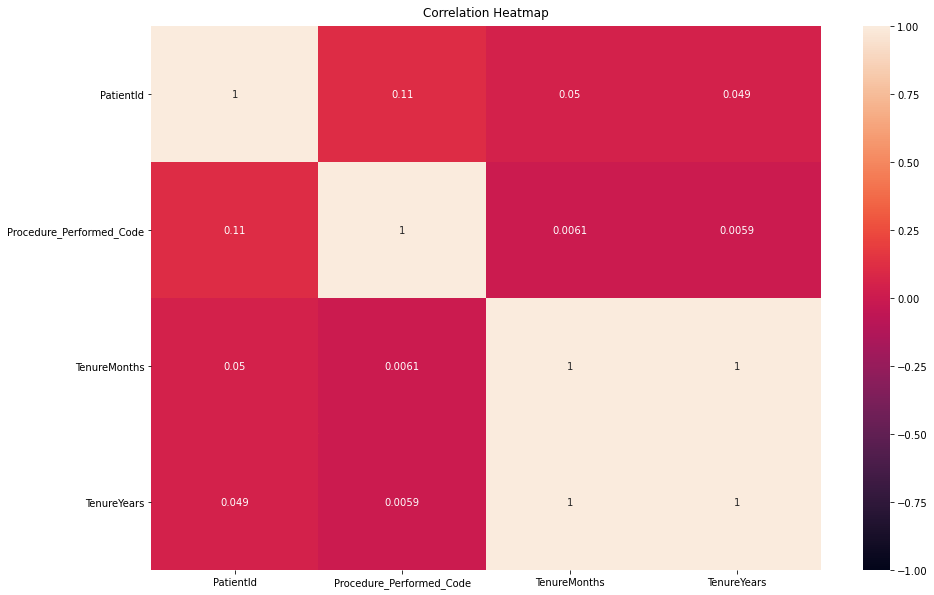

In [53]:
plt.figure(figsize=(15,10))
heatmap=sns.heatmap(dfPPBaseline.corr(),vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12},pad=10)

As would be expected the TenureMonths and TenureYears are correlated since one is derived from the other.  However, with correlation coefficients so low for tenure and procedure pairings, there do not appear to be any relation between Tenure and Procedures performed.

However, we can still compare the two attributes via plots and visualizations to see if there are any other relationships or indicators to find.

Create a pivot-like dataframe using tenure, procedure code and procedure description to get a procedures performed count break down by tenure and procedure in a single dataframe.

In [54]:
dfPP_pvt_mth = dfPPBaseline.groupby(['TenureMonths',
                                     'Procedure_Performed_Code',
                                     'Procedure_Performed_Description']).size().to_frame(name='Procedure_Count').reset_index()

dfPP_pvt_mth.shape

(8793, 4)

In [55]:
# show the first two rows of the dataframe containing tenure in months information
dfPP_pvt_mth.head(2)

TenureMonths  Procedure_Performed_Code     Procedure_Performed_Description  \
0             0                 268400002         CV - ECG - 12 Lead Obtained   
1             0                 302789003  Assess - Blood Glucose Level (BGL)   

   Procedure_Count  
0                1  
1                1

In [56]:
# show the last two rows of the dataframe containing tenure in months information
dfPP_pvt_mth.tail(2)

TenureMonths  Procedure_Performed_Code  \
8791           440                 425447009   
8792           453                 392230005   

               Procedure_Performed_Description  Procedure_Count  
8791  Resp - Assist Ventilation - BVM Via Mask                2  
8792    IV Start - Extremity Vein (arm or leg)                1

In [57]:
dfPP_pvt_mth.columns

Index(['TenureMonths', 'Procedure_Performed_Code',
       'Procedure_Performed_Description', 'Procedure_Count'],
      dtype='object')

In order to see the distribution of procedures against tenure, generate a hex bin plot using tenure, procedure code, and procedure count from dfPatProc_pvt as the x, y and C values, respectively.

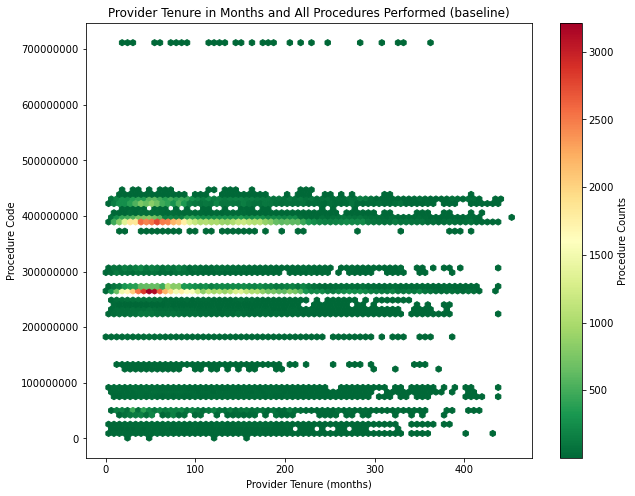

In [58]:
fig, axs = plt.subplots(figsize=(10, 8))
ax = axs
hb1 = ax.hexbin(    x = dfPP_pvt_mth["TenureMonths"], 
                    y = dfPP_pvt_mth["Procedure_Performed_Code"], 
                    C = dfPP_pvt_mth["Procedure_Count"],
                    reduce_C_function=np.sum, 
                    gridsize=75, 
                    cmap=colorMap_scale
                    #sharex=False)
               )
ax.set_title("Provider Tenure in Months and All Procedures Performed (baseline)")
ax.set_xlabel("Provider Tenure (months)")
ax.set_ylabel("Procedure Code")
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Procedure Counts')

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
plt.show()

Using dfPP_pvt_mth, generate descriptive statistics about the tenure, procedure count, and procedure description attributes. Remember, the procedure counts represent the number of procedures performed by type and month.

In [59]:
dfPP_pvt_mth[['TenureMonths','Procedure_Count']].describe()

TenureMonths  Procedure_Count
count   8793.000000      8793.000000
mean     152.901285        19.339361
std      102.830456        66.260006
min        0.000000         1.000000
25%       66.000000         1.000000
50%      137.000000         3.000000
75%      220.000000         7.000000
max      453.000000       697.000000

In [60]:
dfPP_pvt_mth[['Procedure_Performed_Description']].describe(include='all')

Procedure_Performed_Description
count                                     8793
unique                                      67
top     IV Start - Extremity Vein (arm or leg)
freq                                       421

Do a quick check to be sure that that top ten totals calculated in dfProcList still match those pulled from dfPP_pvt_mth

In [61]:
dfPP_pvt_mth.groupby(["Procedure_Performed_Code",
                        "Procedure_Performed_Description"])[["Procedure_Count"]].sum().nlargest(10,["Procedure_Count"])

Procedure_Count
Procedure_Performed_Code Procedure_Performed_Description                            
268400002                CV - ECG - 12 Lead Obtained                           66972
392230005                IV Start - Extremity Vein (arm or leg)                59835
46825001                 Electrocardiographic monitoring                        4755
398041008                MS - Cervical Spinal Restriction of Motion             4693
422618004                Assess - Assessment of Patient                         4192
302789003                Assess - Blood Glucose Level (BGL)                     3590
428803005                CV - ECG - Limb Lead Monitoring                        3114
425543005                Assess - Capnography (ETCO2)                           2876
430824005                IO Start - Intraosseous Access                         1857
426498007                MS - Full Spinal Restriction of Motion                 1722

Rerun the Tenure histogram to get an idea of the most frequent monthly tenure values.

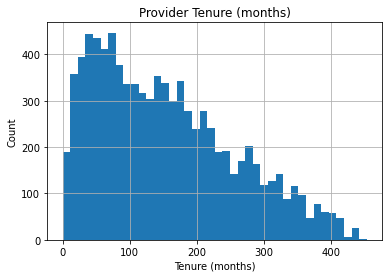

In [62]:
#dfPP_pvt_mth.hist(column='TenureMonths', bins=40)
fig,ax=plt.subplots()
ax.hist(x=dfPP_pvt_mth['TenureMonths'], bins = 40)
ax.set_xlabel('Tenure (months)')
ax.set_ylabel('Count')
ax.set_title('Provider Tenure (months)')
ax.ticklabel_format(style='plain')
ax.grid()
#plt.xticks(rotation=45)
plt.show()

This histogram, taken with the mean of Tenure, shows that most of the providers are found between 0 and 100 months.

In [63]:
# create a dataframe for repeated use in analysis including only records with 100 or less months of tenure
dfPP_pvt_mth_lte100 = dfPP_pvt_mth[(dfPP_pvt_mth['TenureMonths'] <= 100)]
print(" ".join(["Number of rows with tenure less than or equal to 100 months:",str(len(dfPP_pvt_mth_lte100))]))

Number of rows with tenure less than or equal to 100 months: 3361


Generate the respective descriptive statistics for rows with tenure less than or equal to 100 months.

In [64]:
dfPP_pvt_mth_lte100[['TenureMonths','Procedure_Count']].describe()

TenureMonths  Procedure_Count
count   3361.000000      3361.000000
mean      52.940494        29.905980
std       26.465938        94.333732
min        0.000000         1.000000
25%       31.000000         2.000000
50%       53.000000         4.000000
75%       75.000000        11.000000
max      100.000000       697.000000

What are the top 10 procedures by count for procedures performed by providers with 100 or less months of tenure?

In [65]:
dfPP_pvt_mth_lte100.groupby(['Procedure_Performed_Code',
     'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

Procedure_Count
Procedure_Performed_Code Procedure_Performed_Description                            
268400002                CV - ECG - 12 Lead Obtained                           39043
392230005                IV Start - Extremity Vein (arm or leg)                33944
422618004                Assess - Assessment of Patient                         3596
46825001                 Electrocardiographic monitoring                        3035
398041008                MS - Cervical Spinal Restriction of Motion             2621
302789003                Assess - Blood Glucose Level (BGL)                     2571
425543005                Assess - Capnography (ETCO2)                           1998
428803005                CV - ECG - Limb Lead Monitoring                        1966
430824005                IO Start - Intraosseous Access                         1121
426220008                CV - Defibrillation - Manual                            998

The mean of the tenure values for those providers with 100 months or less, is 52.9 months. When compared to the total number of ECG 12 Lead and IV Start procedures, it can be seen that more than half of those procedures are performed by providers with 100 or less months of tenure.

What are the top 10 procedures by count for procedures performed by providers with 52 or 53 months (mean = 52.9) of tenure?

In [66]:
dfPP_pvt_mth[(dfPP_pvt_mth['TenureMonths'] >= 52) & 
             (dfPP_pvt_mth['TenureMonths'] <= 53)].groupby(['Procedure_Performed_Code', 
                    'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

Procedure_Count
Procedure_Performed_Code Procedure_Performed_Description                            
268400002                CV - ECG - 12 Lead Obtained                            1221
392230005                IV Start - Extremity Vein (arm or leg)                  925
422618004                Assess - Assessment of Patient                          164
46825001                 Electrocardiographic monitoring                         112
428803005                CV - ECG - Limb Lead Monitoring                          86
425543005                Assess - Capnography (ETCO2)                             84
398041008                MS - Cervical Spinal Restriction of Motion               81
302789003                Assess - Blood Glucose Level (BGL)                       58
225358003                Wound Care - General                                     39
430824005                IO Start - Intraosseous Access                           28

Evaluate influence of highest procedure counts by starting with the two highest procedure counts overall and how they influence the hexbin plots.

How does the hexbin plot change when the 2 highest procedure counts are not plotted?

In [67]:
dfPP_pvt_mth.groupby(["Procedure_Performed_Code",
                        "Procedure_Performed_Description"])[["Procedure_Count"]].sum().nlargest(2,["Procedure_Count"])

Procedure_Count
Procedure_Performed_Code Procedure_Performed_Description                        
268400002                CV - ECG - 12 Lead Obtained                       66972
392230005                IV Start - Extremity Vein (arm or leg)            59835

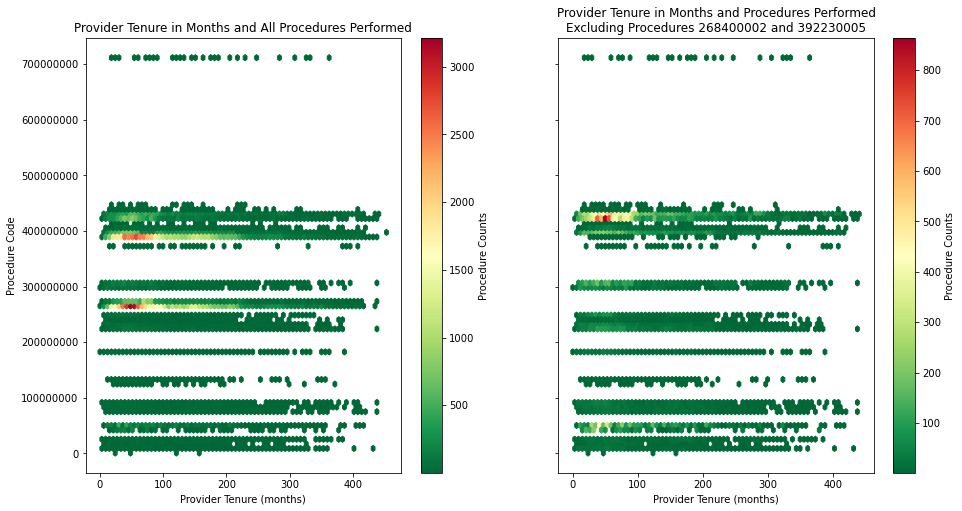

In [68]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(14, 8))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs[0]
hb1 = ax.hexbin(    x = dfPP_pvt_mth["TenureMonths"], 
                    y = dfPP_pvt_mth["Procedure_Performed_Code"], 
                    C = dfPP_pvt_mth["Procedure_Count"],
                    reduce_C_function=np.sum, 
                    gridsize=75, 
                    cmap=colorMap_scale, 
               )
#ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.set_title("Provider Tenure in Months and All Procedures Performed")
ax.set_xlabel("Provider Tenure (months)")
ax.set_ylabel("Procedure Code")
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Procedure Counts')

ax = axs[1]
hb2 = ax.hexbin(    x = dfPP_pvt_mth[(dfPP_pvt_mth['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_mth['Procedure_Performed_Code'] != 392230005)]["TenureMonths"],
                    y = dfPP_pvt_mth[(dfPP_pvt_mth['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_mth['Procedure_Performed_Code'] != 392230005)]["Procedure_Performed_Code"],
                    C = dfPP_pvt_mth[(dfPP_pvt_mth['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_mth['Procedure_Performed_Code'] != 392230005)]["Procedure_Count"],
                    reduce_C_function=np.sum,
                    gridsize=75,
                    cmap=colorMap_scale,
               )
#ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.set_title("Provider Tenure in Months and Procedures Performed\nExcluding Procedures 268400002 and 392230005")
ax.set_xlabel("Provider Tenure (months)")
cb = fig.colorbar(hb2, ax=ax)
cb.set_label('Procedure Counts')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
plt.show()

In addition to the Procedure Count scale changing, the "hot spots" of color change.  Areas that were hinting at some variation with the lighter green coloring in the left plot are now showing distinct color changes in the yellow to red range.

### Evaluate procedures and tenure again using the yearly tenure values

Create a new pivot dataframe using TenureYears instead of TenureMonths

In [69]:
dfPP_pvt_yr = dfPPBaselineYrCat.groupby(['TenureYears',
                                    'Procedure_Performed_Code',
                                    'Procedure_Performed_Description',
                                    'ProcedureCategory',
                                    'ProcedureCatCode']).size().to_frame(name='Procedure_Count').reset_index()

dfPP_pvt_yr.shape

(1508, 6)

In [70]:
# show the first two rows of the new pivot dataframe
dfPP_pvt_yr.head(2)

TenureYears  Procedure_Performed_Code     Procedure_Performed_Description  \
0          0.0                   7443007    Airway - Oropharyngeal Insertion   
1          0.0                  18590009  CV - Pacing - External or Internal   

  ProcedureCategory  ProcedureCatCode  Procedure_Count  
0        BLS Airway                 6               23  
1       CV - Pacing                13                1

In [71]:
# show the last two rows of the new pivot dataframe
dfPP_pvt_yr.tail(2)

TenureYears  Procedure_Performed_Code  \
1506         36.0                 428803005   
1507         37.0                 392230005   

             Procedure_Performed_Description ProcedureCategory  \
1506         CV - ECG - Limb Lead Monitoring   CV - ECG - Limb   
1507  IV Start - Extremity Vein (arm or leg)   IV Start - Vein   

      ProcedureCatCode  Procedure_Count  
1506                12                8  
1507                22                1

How do the descriptive statistics change using tenure values in years versus months?

In [72]:
dfPP_pvt_yr[['TenureYears','Procedure_Count']].describe()

TenureYears  Procedure_Count
count  1508.000000      1508.000000
mean     14.310345       112.765915
std       9.403890       559.910856
min       0.000000         1.000000
25%       6.000000         2.000000
50%      13.000000         7.000000
75%      21.000000        33.000000
max      37.000000      7741.000000

What are the 10 largest procedures? The answer should match the same call made using the dfPP_pvt_mth dataframe since summing the data by procedure code and description drops any tenure component.

In [73]:
# 10 largest procedures, should match the same call made using the dfPP_pvt_mth dataframe
dfPP_pvt_yr.groupby(["Procedure_Performed_Code",
                        "Procedure_Performed_Description"])[["Procedure_Count"]].sum().nlargest(10,["Procedure_Count"])

Procedure_Count
Procedure_Performed_Code Procedure_Performed_Description                            
268400002                CV - ECG - 12 Lead Obtained                           66972
392230005                IV Start - Extremity Vein (arm or leg)                59835
46825001                 Electrocardiographic monitoring                        4755
398041008                MS - Cervical Spinal Restriction of Motion             4693
422618004                Assess - Assessment of Patient                         4192
302789003                Assess - Blood Glucose Level (BGL)                     3590
428803005                CV - ECG - Limb Lead Monitoring                        3114
425543005                Assess - Capnography (ETCO2)                           2876
430824005                IO Start - Intraosseous Access                         1857
426498007                MS - Full Spinal Restriction of Motion                 1722

Now that it has been confirmed that the counts match, proving no data has been lost through the manipulation of the tenure, generate a histogram of the tenure in years.

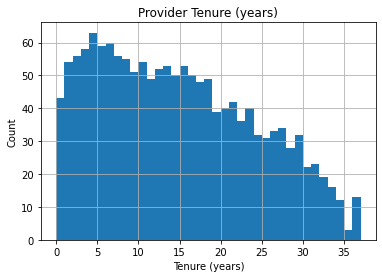

In [74]:
fig,ax=plt.subplots()
ax.hist(x=dfPP_pvt_yr['TenureYears'], bins = int(dfPP_pvt_yr['TenureYears'].max()))
ax.set_xlabel('Tenure (years)')
ax.set_ylabel('Count')
ax.set_title('Provider Tenure (years)')
ax.ticklabel_format(style='plain')
ax.grid()
#plt.xticks(rotation=45)
plt.show()

The high point is now identified as 4 yrs, which corresponds to the previously identified high point of 52-53 months.

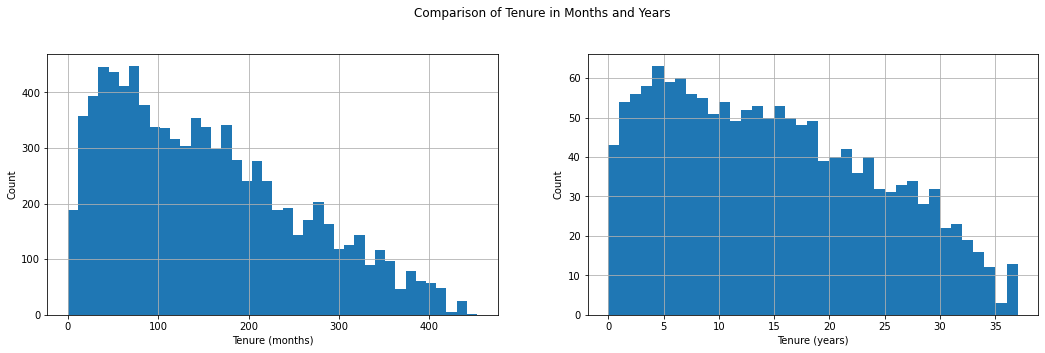

In [75]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
fig.suptitle("Comparison of Tenure in Months and Years")
fig.subplots_adjust(top=0.85)

ax = axs[0]
ax.hist(x=dfPP_pvt_mth['TenureMonths'], bins = 40)
ax.set_xlabel('Tenure (months)')
ax.set_ylabel('Count')
#ax.set_title('Provider Tenure (months)')
ax.ticklabel_format(style='plain')
ax.grid()
#plt.xticks(rotation=45)
#plt.show()

ax = axs[1]
ax.hist(x=dfPP_pvt_yr['TenureYears'], bins = int(dfPP_pvt_yr['TenureYears'].max()))
ax.set_xlabel('Tenure (years)')
ax.set_ylabel('Count')
#ax.set_title('Provider Tenure (years)')
ax.ticklabel_format(style='plain')
ax.grid()
#plt.xticks(rotation=45)

plt.show()

In [76]:
# show the count of rows assigned to each year
#dfPP_pvt_yr.groupby(['TenureYears']).size().to_frame(name='Count')

In [77]:
# make a copy of the yearly pivot dataframe and use a name that better describes the content
dfPP_pvt_yr_cat = dfPP_pvt_yr.copy()

In [78]:
dfPP_pvt_yr_cat

TenureYears  Procedure_Performed_Code  \
0             0.0                   7443007   
1             0.0                  18590009   
2             0.0                  20655006   
3             0.0                  22206003   
4             0.0                  26906007   
...           ...                       ...   
1503         36.0                 422618004   
1504         36.0                 425058005   
1505         36.0                 425447009   
1506         36.0                 428803005   
1507         37.0                 392230005   

                    Procedure_Performed_Description  \
0                  Airway - Oropharyngeal Insertion   
1                CV - Pacing - External or Internal   
2        Wound - Bleeding Control - Tourniquet Used   
3     Wound Care - Dressing - Occlusive Application   
4         Wound Care - Dressing - Pressure Dressing   
...                                             ...   
1503                 Assess - Assessment of Patient   
1504               Assess - Orthostatic Vital Signs   
1505       Resp - Assist Ventilation - BVM Via Mask   
1506                CV - ECG - Limb Lead Monitoring   
1507         IV Start - Extremity Vein (arm or leg)   

              ProcedureCategory  ProcedureCatCode  Procedure_Count  
0                    BLS Airway                 6               23  
1                   CV - Pacing                13                1  
2      Wound - Bleeding Control                29                2  
3         Wound Care - Dressing                30                2  
4      Wound - Bleeding Control                29                4  
...                         ...               ...              ...  
1503                 Assessment                 4                4  
1504                    Exclude                 0                3  
1505  Resp - Assist Ventilation                26                3  
1506            CV - ECG - Limb                12                8  
1507            IV Start - Vein                22                1  

[1508 rows x 6 columns]

Run the hexbin plot using the pivot by tenure in years.

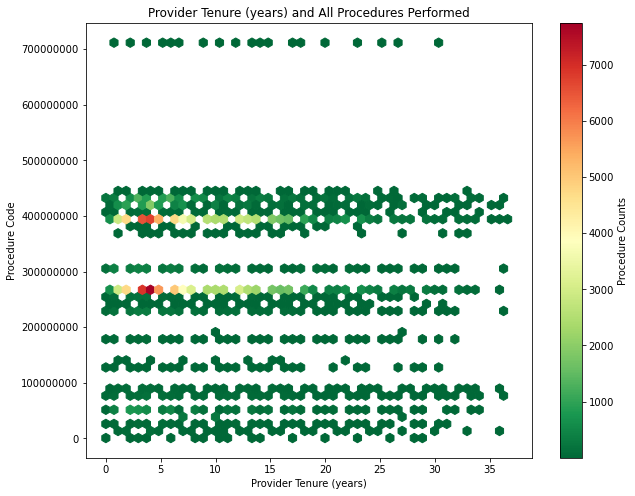

In [79]:
fig, axs = plt.subplots(figsize=(10, 8))
ax = axs
hb1 = ax.hexbin(    x = dfPP_pvt_yr_cat["TenureYears"], 
                    y = dfPP_pvt_yr_cat["Procedure_Performed_Code"], 
                    C = dfPP_pvt_yr_cat["Procedure_Count"],
                    reduce_C_function=np.sum, 
                    gridsize=50, 
                    cmap=colorMap_scale
                    #sharex=False)
               )
ax.set_title("Provider Tenure (years) and All Procedures Performed")
ax.set_xlabel("Provider Tenure (years)")
ax.set_ylabel("Procedure Code")
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Procedure Counts')

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
plt.show()

In [80]:
# check the 2 largest procedures
dfPP_pvt_yr_cat.groupby(["Procedure_Performed_Code",
                        "Procedure_Performed_Description",
                        "ProcedureCatCode",
                         "ProcedureCategory"])[["Procedure_Count"]].sum().nlargest(2,["Procedure_Count"])

Procedure_Count
Procedure_Performed_Code Procedure_Performed_Description        ProcedureCatCode ProcedureCategory                 
268400002                CV - ECG - 12 Lead Obtained            11               CV - ECG - 12/15             66972
392230005                IV Start - Extremity Vein (arm or leg) 22               IV Start - Vein              59835

Compare the hexbin plots, where the second plot does not include the two highest count procedures.

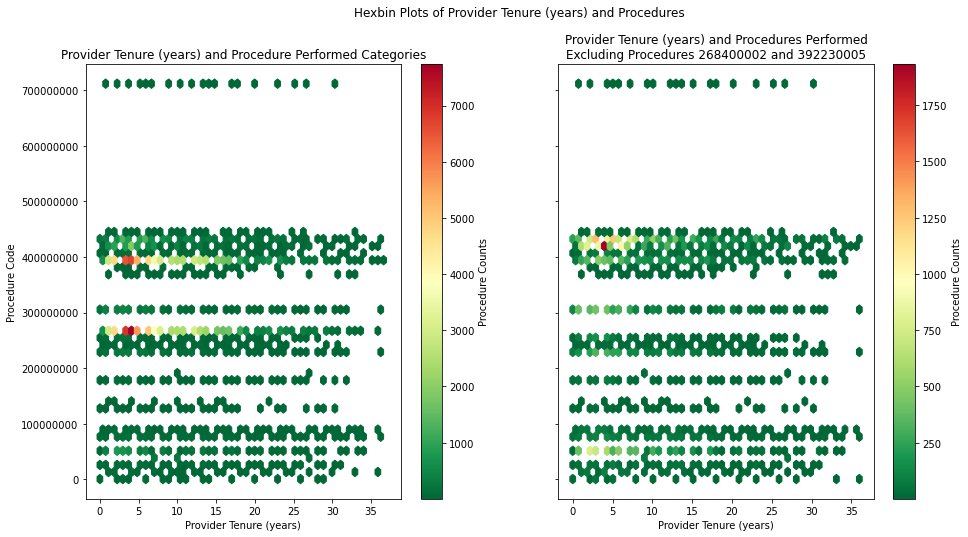

In [81]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(14, 8))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
fig.suptitle("Hexbin Plots of Provider Tenure (years) and Procedures")
ax = axs[0]
hb1 = ax.hexbin(    x = dfPP_pvt_yr_cat["TenureYears"], 
                    y = dfPP_pvt_yr_cat["Procedure_Performed_Code"], 
                    C = dfPP_pvt_yr_cat["Procedure_Count"],
                    reduce_C_function=np.sum, 
                    gridsize=50, 
                    cmap=colorMap_scale, 
                    #xlabel="Provider Tenure", 
                    #ylabel="Procedure Code", 
                    #title="Provider Tenure and All Procedures Performed",
                    #sharex=False)
               )
#ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.set_title("Provider Tenure (years) and Procedure Performed Categories")
ax.set_xlabel("Provider Tenure (years)")
ax.set_ylabel("Procedure Code")
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Procedure Counts')

ax = axs[1]
hb2 = ax.hexbin(    x = dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 392230005)]["TenureYears"],
                    y = dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 392230005)]["Procedure_Performed_Code"],
                    C = dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 268400002) &
                        (dfPP_pvt_yr_cat['Procedure_Performed_Code'] != 392230005)]["Procedure_Count"],
                    reduce_C_function=np.sum,
                    gridsize=50,
                    cmap=colorMap_scale,
                    #xlabel="Provider Tenure",
                    #ylabel="Procedure Code",
                    #title="Provider Tenure and Procedures Performed",
                    #sharex=False)
               )
#ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.set_title("Provider Tenure (years) and Procedures Performed\nExcluding Procedures 268400002 and 392230005")
ax.set_xlabel("Provider Tenure (years)")
cb = fig.colorbar(hb2, ax=ax)
cb.set_label('Procedure Counts')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
plt.show()

Using the tenure in years, makes it much easier to see potential gaps in procedures occuring for certain tenures.  However, since the hexbin plot only shows the Procedure Codes, let's take a different look in a way that will allow the procedure title to be utilized.

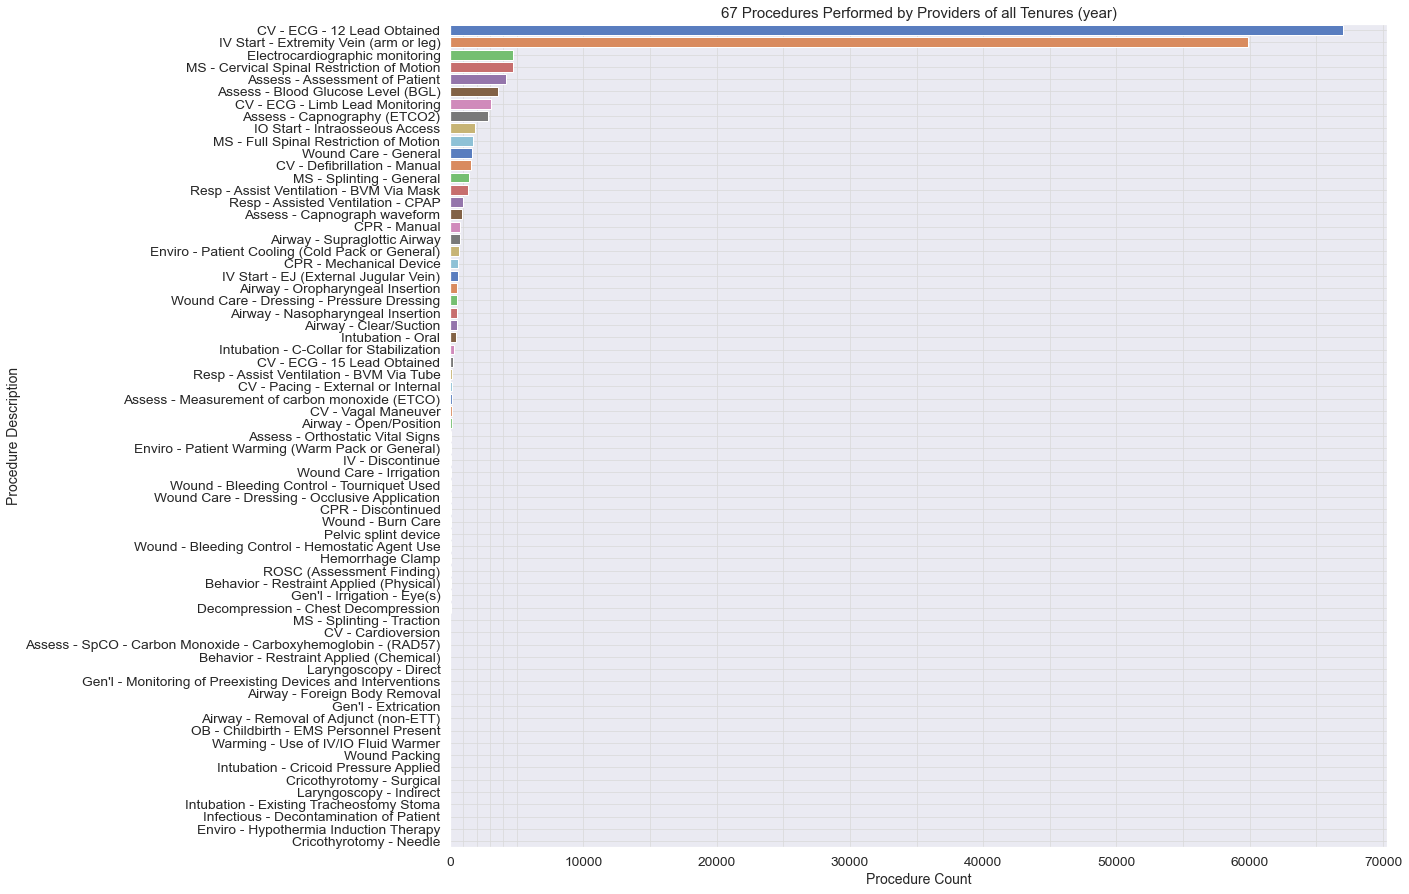

In [183]:
dfPP_pvt_yr_tot = BuildQntlTotDf(dfPP_pvt_yr,'Procedure_Performed_Code', 'Procedure_Performed_Description')
title = " ".join([str(proc_count_all),'Procedures Performed by Providers of all Tenures (year)'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0
tick_list = ticklst_70000 
x_range = xrng_70000  

fig, axs = plt.subplots(figsize=(14, 13))
#fig.suptitle("All Procedures by Tenure, ordered by total count")
fig.tight_layout()
fig.subplots_adjust(top=0.92)
sns.set(font_scale = 1.25)
# all tenures and all procedures
sns.barplot(ax=axs, x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette=colorMap,
                 order=ProcOrder,
                 data=dfPP_pvt_yr_tot)
axs.set_ylabel('Procedure Description',fontsize=14)
axs.set_xlabel('Procedure Count',fontsize=14)
axs.set_title(title)
axs.set_xticks(minor=True, ticks=tick_list)
#axs.grid(axis='both', alpha=.75, which='both', color='0.85')
axs.grid(b=True, axis='both', alpha=.75, which='both', color='0.85')


# show plots
plt.show()


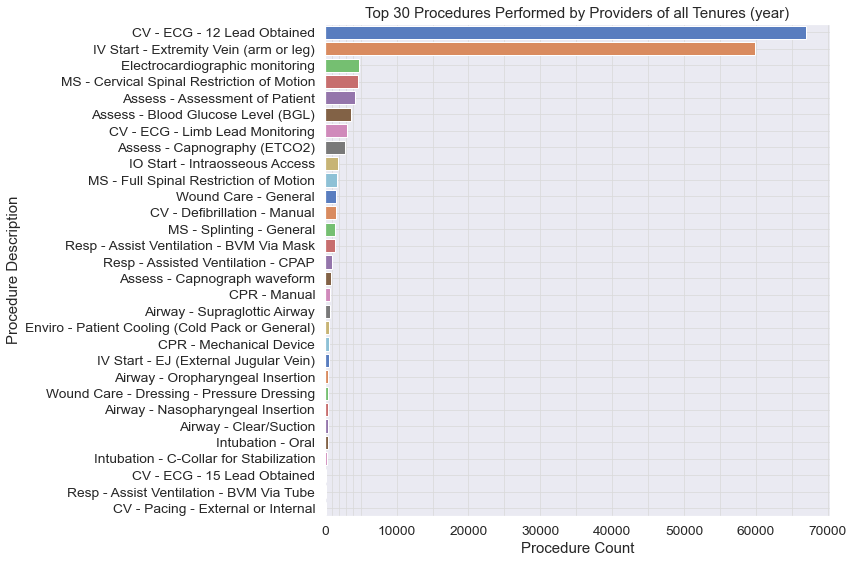

In [182]:
#### dfPP_pvt_yr_tot = BuildQntlTotDf(dfPP_pvt_yr,'Procedure_Performed_Code', 'Procedure_Performed_Description')
#title = " ".join([str(proc_count_all),'Procedures Performed by Providers of all Tenures (year)'])
title = 'Top 30 Procedures Performed by Providers of all Tenures (year)'

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0
tick_list = ticklst_70000 
x_range = xrng_70000  

fig, axs = plt.subplots(figsize=(8, 8))
#fig.suptitle("All Procedures by Tenure, ordered by total count")
fig.tight_layout()
fig.subplots_adjust(top=0.92)
sns.set(font_scale = 1.25)
# all tenures and all procedures
sns.barplot(ax=axs, x='Procedure_Count', 
                 y='Procedure_Performed_Description', 
                 palette=colorMap,
                 order=ProcOrder[0:30],
                 data=dfPP_pvt_yr_tot.nlargest(30,["Procedure_Count"]))
axs.set_ylabel('Procedure Description')
axs.set_xlabel('Procedure Count')
axs.set_title(title)
axs.set_xticks(minor=True, ticks=tick_list)
#axs.grid(axis='both', alpha=.75, which='both', color='0.85')
axs.grid(b=True, axis='both', alpha=.75, which='both', color='0.85')


# show plots
plt.show()


Now going to take a look at how the procedure distribution looks when taking the pivot by tenure in years in quantile slices.

Create dataframes for each quantile < 0.25, between 0.25 and 0.5, between 0.5 and 0.75, and between 0.75 and 1 

In [84]:
# create the first quantile dataframe
dfPP_pvt_yr_q1 = BuildTenureQntlDf(dfPP_pvt_yr_cat,0.0,0.25)
print(dfPP_pvt_yr_q1.shape)
dfPP_pvt_yr_q1.groupby(['TenureYears']).size().to_frame(name='Count')

(333, 6)


Count
TenureYears       
0.0             43
1.0             54
2.0             56
3.0             58
4.0             63
5.0             59

In [85]:
# count the number of procedures included
q1_proc_count = dfPP_pvt_yr_q1['Procedure_Performed_Code'].nunique()
print(q1_proc_count)
# get year ranges
q1_low_yr = dfPP_pvt_yr_q1['TenureYears'].min()
print(q1_low_yr)
q1_high_yr = dfPP_pvt_yr_q1['TenureYears'].max()
print(q1_high_yr)

66
0.0
5.0


In [86]:
# create the second quantile dataframe
dfPP_pvt_yr_q2 = BuildTenureQntlDf(dfPP_pvt_yr_cat,0.25,0.5)
print(dfPP_pvt_yr_q2.shape)
#dfPP_pvt_yr_q2.groupby(['TenureYears']).size().to_frame(name='Row Count')

(377, 6)


In [87]:
# count the number of procedures included
q2_proc_count = dfPP_pvt_yr_q2['Procedure_Performed_Code'].nunique()
print(q2_proc_count)
# get year ranges
q2_low_yr = dfPP_pvt_yr_q2['TenureYears'].min()
print(q2_low_yr)
q2_high_yr = dfPP_pvt_yr_q2['TenureYears'].max()
print(q2_high_yr)

64
6.0
12.0


In [88]:
# create the third quantile dataframe
dfPP_pvt_yr_q3 = BuildTenureQntlDf(dfPP_pvt_yr_cat,0.5,0.75)
print(dfPP_pvt_yr_q3.shape)
#dfPP_pvt_yr_q3.groupby(['TenureYears']).size().to_frame(name='Count')

(382, 6)


In [89]:
# count the number of procedures included
q3_proc_count = dfPP_pvt_yr_q3['Procedure_Performed_Code'].nunique()
print(q3_proc_count)
# get year ranges
q3_low_yr = dfPP_pvt_yr_q3['TenureYears'].min()
print(q3_low_yr)
q3_high_yr = dfPP_pvt_yr_q3['TenureYears'].max()
print(q3_high_yr)

64
13.0
20.0


In [90]:
# create the fourth quantile dataframe
dfPP_pvt_yr_q4 = BuildTenureQntlDf(dfPP_pvt_yr_cat,0.75,1.0)
print(dfPP_pvt_yr_q4.shape)
#dfPP_pvt_yr_q4.groupby(['TenureYears']).size().to_frame(name='Count')

(415, 6)


In [91]:
# count the number of procedures included
q4_proc_count = dfPP_pvt_yr_q4['Procedure_Performed_Code'].nunique()
print(q4_proc_count)
# get year ranges
q4_low_yr = dfPP_pvt_yr_q4['TenureYears'].min()
print(q4_low_yr)
q4_high_yr = dfPP_pvt_yr_q4['TenureYears'].max()
print(q4_high_yr)

56
21.0
36.0


In [92]:
# set up dataframes that only have the total sum of procedures using the quantile dataframes as starting points
dfPP_pvt_yr_q1tot = BuildQntlTotDf(dfPP_pvt_yr_q1,'Procedure_Performed_Code', 'Procedure_Performed_Description')
dfPP_pvt_yr_q2tot = BuildQntlTotDf(dfPP_pvt_yr_q2,'Procedure_Performed_Code', 'Procedure_Performed_Description')
dfPP_pvt_yr_q3tot = BuildQntlTotDf(dfPP_pvt_yr_q3,'Procedure_Performed_Code', 'Procedure_Performed_Description')
dfPP_pvt_yr_q4tot = BuildQntlTotDf(dfPP_pvt_yr_q4,'Procedure_Performed_Code', 'Procedure_Performed_Description')

Using these dataframes, build a side by side barchart to see if there are any indicators.

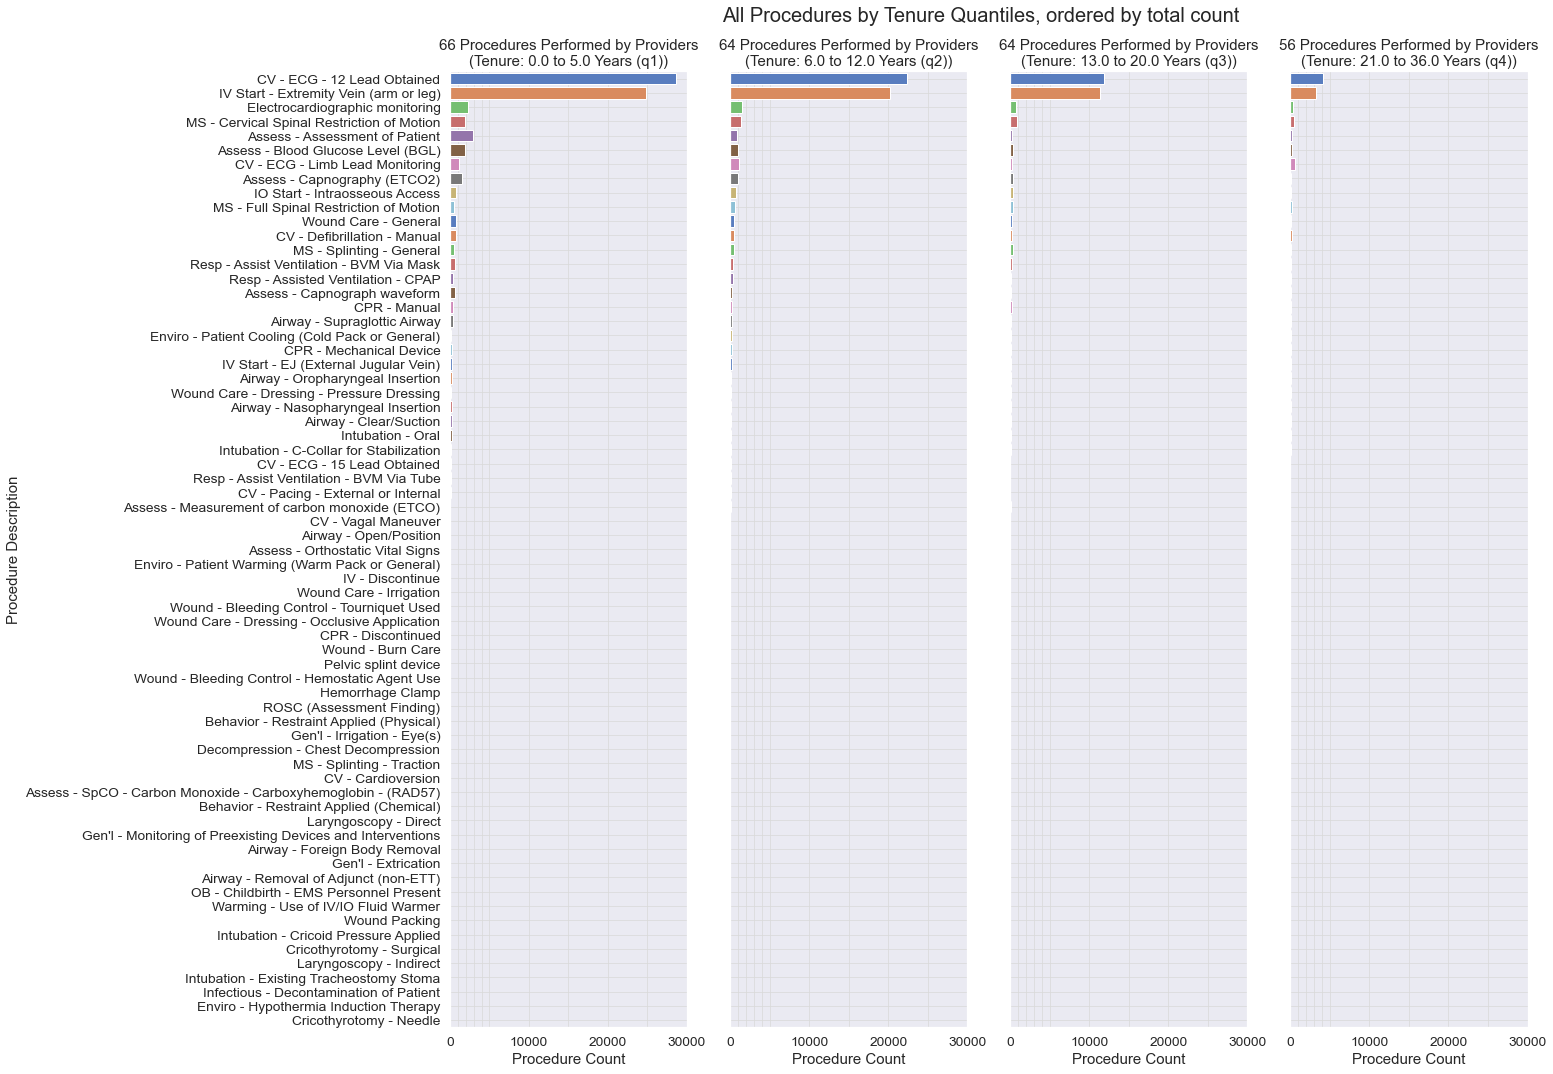

In [181]:
title_q4 = " ".join([str(q4_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0
tick_list = ticklst_30000 
x_range = xrng_30000  

fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(16, 15))
fig.suptitle("All Procedures by Tenure Quantiles, ordered by total count", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.xlim(x_range)


df_array = [dfPP_pvt_yr_q1tot,dfPP_pvt_yr_q2tot,dfPP_pvt_yr_q3tot,dfPP_pvt_yr_q4tot]
title_array = [title_q1,title_q2,title_q3,title_q4]
ylabel_text = 'Procedure Description'
sns.set(font_scale = 1.25)
for cht in range(0,4):
    sns.barplot(ax=axs[cht], x='Procedure_Count', 
                y='Procedure_Performed_Description', 
                palette=colorMap, 
                order=ProcOrder,
                data=df_array[cht])
    axs[cht].set_ylabel(ylabel_text)
    axs[cht].set_xlabel('Procedure Count')
    axs[cht].set_title(title_array[cht])
    axs[cht].set_xticks(minor=True, ticks=tick_list)
    #axs[cht].grid(axis='both', alpha=.75, which='both', color='0.85')
    axs[cht].grid(b=True, axis='both', alpha=.75, which='both', color='0.85')
    ylabel_text = ' '

# show plots
plt.show()

Use the quantile dataframes to create a quad donut chart to see if any additional indicators can be found.

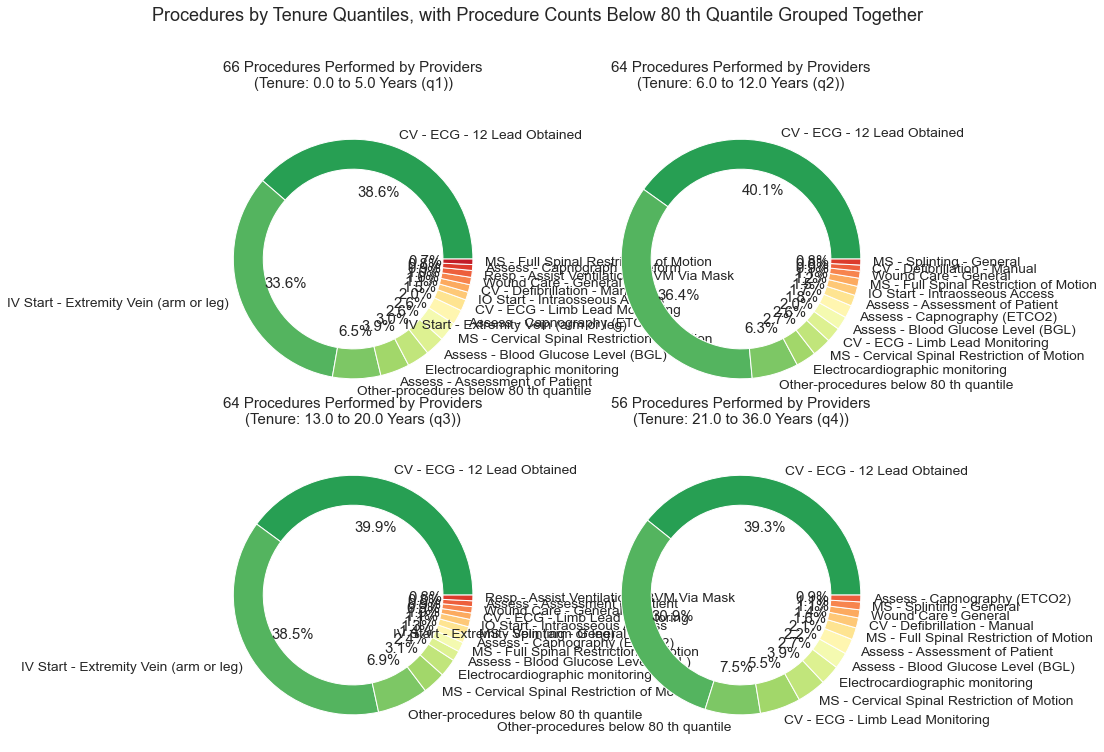

In [94]:
qntl_val = 80

title_q1 = " ".join([str(q1_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))\n'])
dfProcGrpPie_q1 = group_lower_ranking_values(qntl_val,'Procedure_Performed_Description',dfPP_pvt_yr_q1tot[['Procedure_Performed_Description','Procedure_Count']]).sort_values("Procedure_Count", ascending=False).reset_index()
title_q2 = " ".join([str(q2_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))\n'])
dfProcGrpPie_q2 = group_lower_ranking_values(qntl_val,'Procedure_Performed_Description',dfPP_pvt_yr_q2tot[['Procedure_Performed_Description','Procedure_Count']]).sort_values("Procedure_Count", ascending=False).reset_index()
title_q3 = " ".join([str(q3_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))\n'])
dfProcGrpPie_q3 = group_lower_ranking_values(qntl_val,'Procedure_Performed_Description',dfPP_pvt_yr_q3tot[['Procedure_Performed_Description','Procedure_Count']]).sort_values("Procedure_Count", ascending=False).reset_index()
title_q4 = " ".join([str(q4_proc_count),'Procedures Performed by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))\n'])
dfProcGrpPie_q4 = group_lower_ranking_values(qntl_val,'Procedure_Performed_Description',dfPP_pvt_yr_q4tot[['Procedure_Performed_Description','Procedure_Count']]).sort_values("Procedure_Count", ascending=False).reset_index()

# build the labels and counts to display
source_labels_q1 = dfProcGrpPie_q1.Procedure_Performed_Description
source_counts_q1 = dfProcGrpPie_q1.Procedure_Count
source_labels_q2 = dfProcGrpPie_q2.Procedure_Performed_Description
source_counts_q2 = dfProcGrpPie_q2.Procedure_Count
source_labels_q3 = dfProcGrpPie_q3.Procedure_Performed_Description
source_counts_q3 = dfProcGrpPie_q3.Procedure_Count
source_labels_q4 = dfProcGrpPie_q4.Procedure_Performed_Description
source_counts_q4 = dfProcGrpPie_q4.Procedure_Count

fig,axs=plt.subplots(ncols=2, nrows=2, figsize=(11,11))
#fig,axs=plt.subplots(ncols=2)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.suptitle(" ".join(["Procedures by Tenure Quantiles, with Procedure Counts Below",
                       str(qntl_val),"th Quantile Grouped Together"]))

inner_radius = 0.7
chart_radius = 1.2
wedge_props = dict(width=0.25) #chart_radius-inner_radius)

# show donut charts from all 4 quantiles side by side
# q1 tenure
axs[0,0].pie(x=source_counts_q1,labels=source_labels_q1,autopct='%1.1f%%', colors=colors[2:18], wedgeprops=wedge_props)
axs[0,0].set_title(title_q1)

# q2 tenure
axs[0,1].pie(x=source_counts_q2,labels=source_labels_q2,autopct='%1.1f%%', colors=colors[2:18], wedgeprops=wedge_props)
axs[0,1].set_title(title_q2)

# q3 tenure
axs[1,0].pie(x=source_counts_q3,labels=source_labels_q3,autopct='%1.1f%%', colors=colors[2:18], wedgeprops=wedge_props)
axs[1,0].set_title(title_q3)

# q2 tenure
axs[1,1].pie(x=source_counts_q4,labels=source_labels_q4,autopct='%1.1f%%', colors=colors[2:18], wedgeprops=wedge_props)
axs[1,1].set_title(title_q4)

# show plots
plt.show()


Unfortunately, since the order of procedures changes for each donut chart there is no easy way to compare them.

So let's stick with bar charts for now.

Create new dataframes that do not include the top 2 procedures.  This change will result in a scale change on the x-axis and additional indicators may be found.

In [95]:
# set up dataframes that DO NOT contain the top two procedures
dfPP_pvt_yr_q1tota = dfPP_pvt_yr_q1tot[(dfPP_pvt_yr_q1tot['Procedure_Performed_Code'] != 268400002) & 
                                     (dfPP_pvt_yr_q1tot['Procedure_Performed_Code'] != 392230005)]
dfPP_pvt_yr_q2tota = dfPP_pvt_yr_q2tot[(dfPP_pvt_yr_q2tot['Procedure_Performed_Code'] != 268400002) & 
                                     (dfPP_pvt_yr_q2tot['Procedure_Performed_Code'] != 392230005)]
dfPP_pvt_yr_q3tota = dfPP_pvt_yr_q3tot[(dfPP_pvt_yr_q3tot['Procedure_Performed_Code'] != 268400002) & 
                                     (dfPP_pvt_yr_q3tot['Procedure_Performed_Code'] != 392230005)]
dfPP_pvt_yr_q4tota = dfPP_pvt_yr_q4tot[(dfPP_pvt_yr_q4tot['Procedure_Performed_Code'] != 268400002) & 
                                     (dfPP_pvt_yr_q4tot['Procedure_Performed_Code'] != 392230005)]


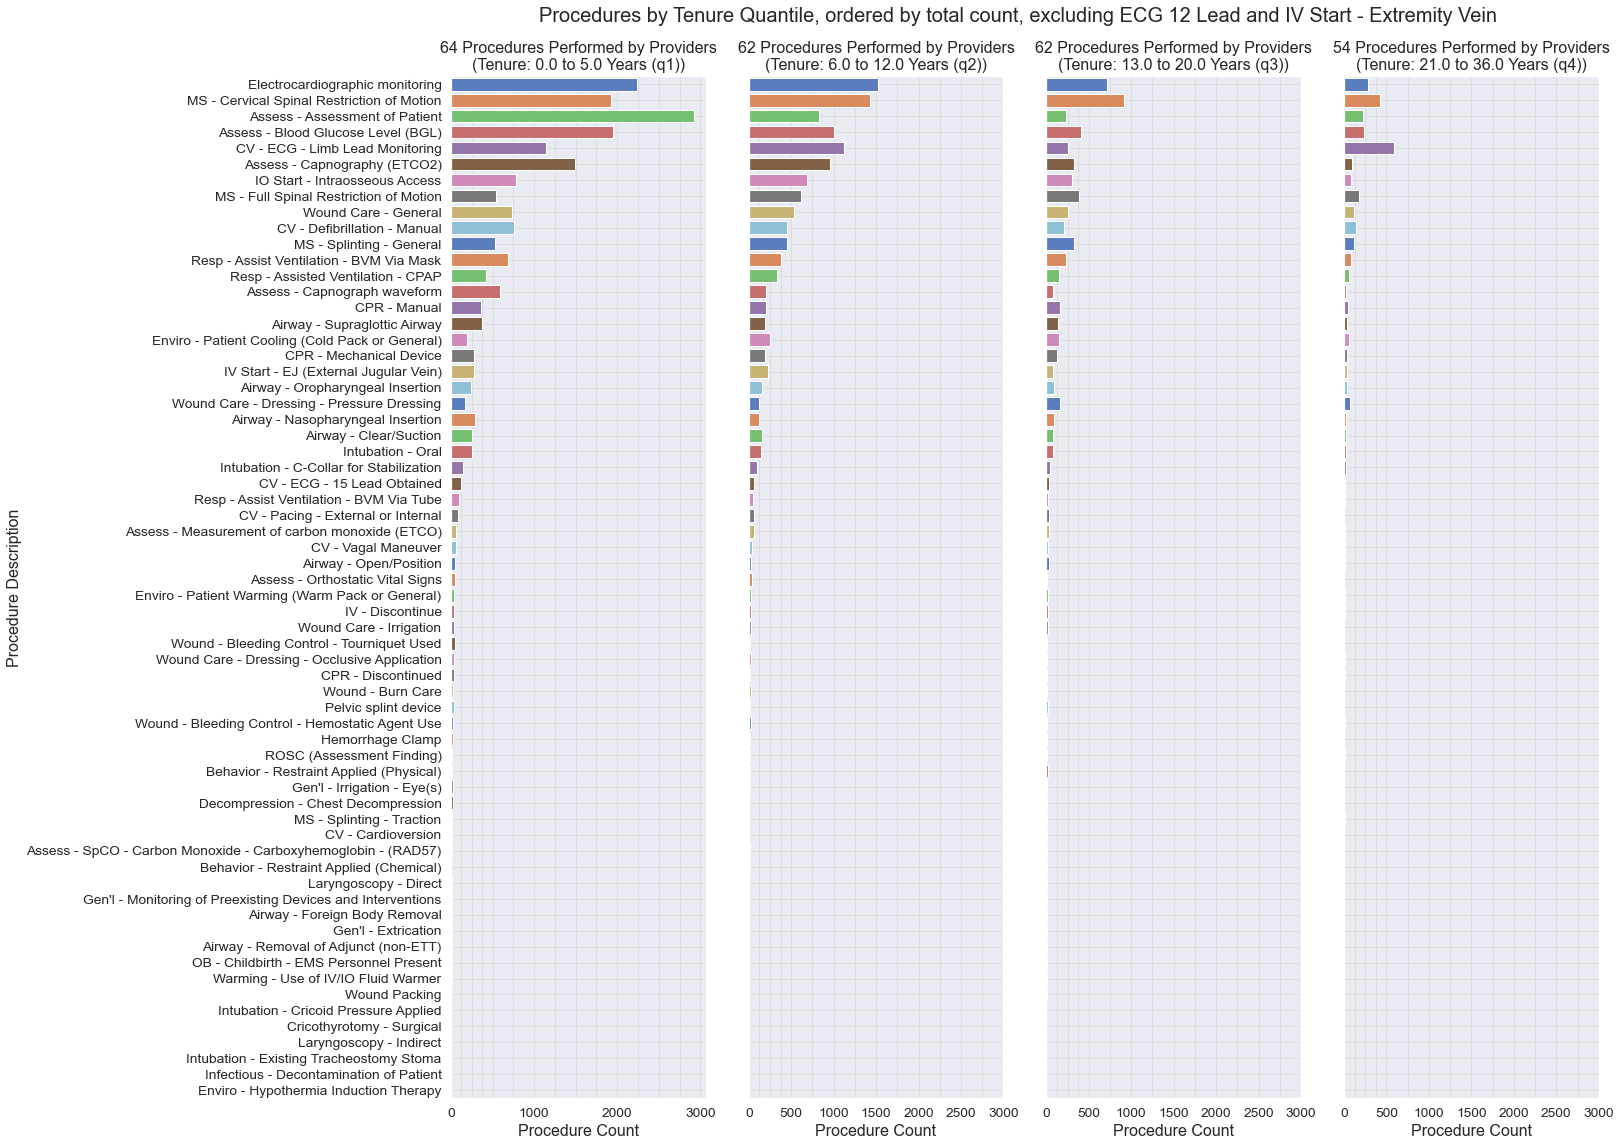

In [180]:
title_q4 = " ".join([str(q4_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0

tick_list = ticklst_3000
x_range = xrng_3000

fig, axs = plt.subplots(ncols=4, sharey='row', figsize=(17, 16))
plt.xlim(x_range)
fig.suptitle("Procedures by Tenure Quantile, ordered by total count, excluding ECG 12 Lead and IV Start - Extremity Vein",fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)

df_array = [dfPP_pvt_yr_q1tota,dfPP_pvt_yr_q2tota,dfPP_pvt_yr_q3tota,dfPP_pvt_yr_q4tota]
title_array = [title_q1,title_q2,title_q3,title_q4]
ylabel_text = 'Procedure Description'
sns.set(font_scale = 1.25)
for cht in range(0,4):
    sns.barplot(ax=axs[cht], x='Procedure_Count', 
                y='Procedure_Performed_Description', 
                palette=colorMap, 
                order=ProcOrder[2:66],
                data=df_array[cht])
    axs[cht].set_ylabel(ylabel_text, fontsize=16)
    axs[cht].set_xlabel('Procedure Count', fontsize=16)
    axs[cht].set_title(title_array[cht], fontsize=16)
    axs[cht].set_xticks(minor=True, ticks=tick_list)
    #axs[cht].grid(axis='both', alpha=.75, which='both', color='0.85')
    axs[cht].grid(b=True, axis='both', alpha=.75, which='both', color='0.85')
    ylabel_text = ' '


# show the plots
plt.show()

With the long list of procedures it hard to see anything other than the fact that when the procedure count gets below 100 there is little to be seen. By limiting the display to the top 30 procedures, may be more can be seen.

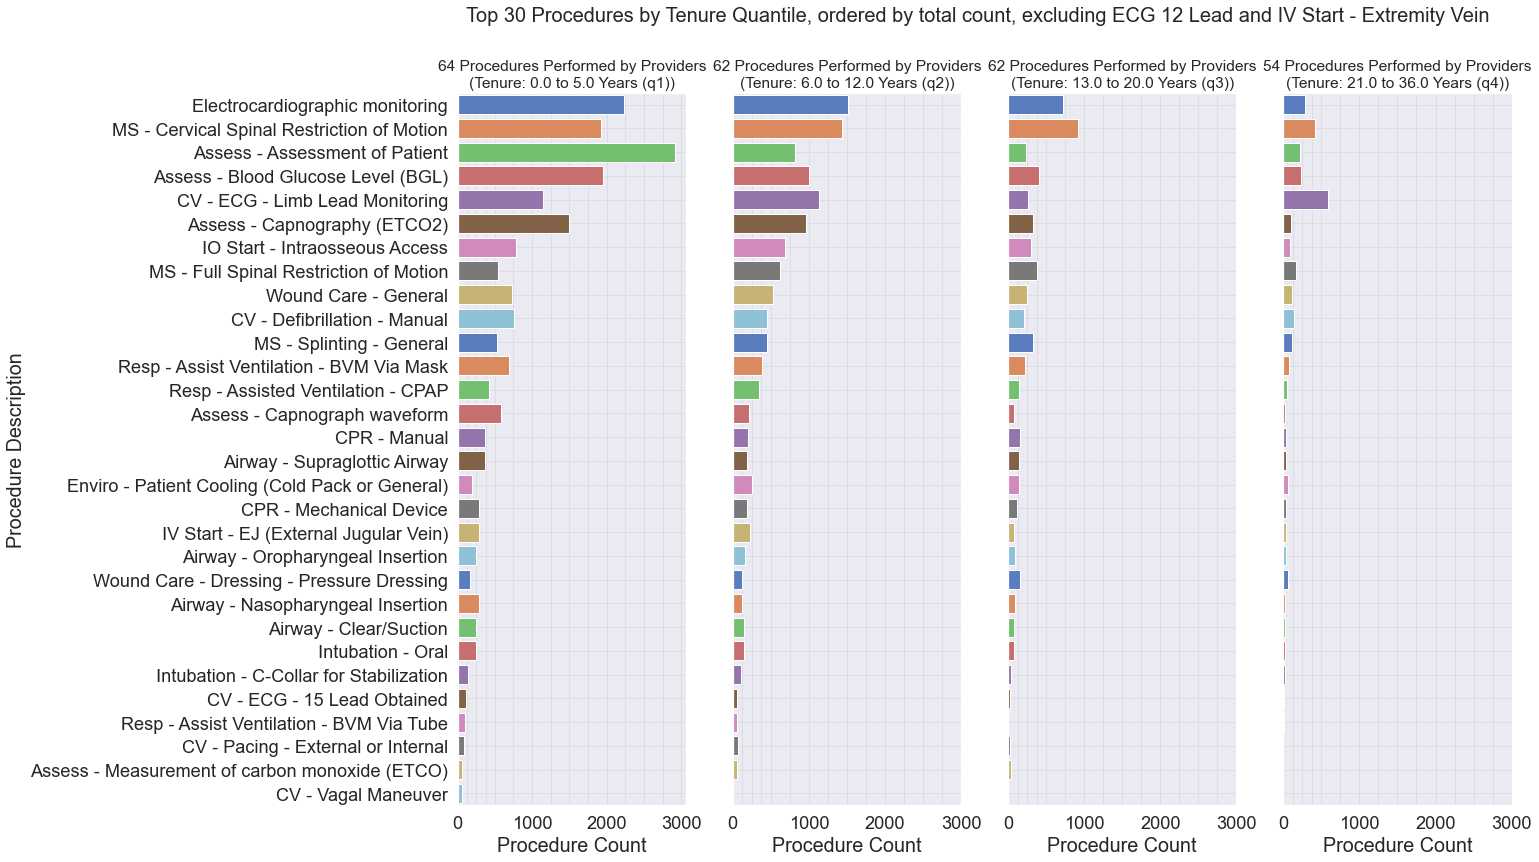

In [197]:
# build plots that exclude the top two highest procedure counts and only show the next 25 highest
title_q4 = " ".join([str(q4_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_proc_count-2),'Procedures Performed by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0

tick_list = ticklst_3000
x_range = xrng_3000

fig, axs = plt.subplots(ncols=4, sharey='row', figsize=(16, 12))
plt.xlim(x_range)
fig.suptitle("Top 30 Procedures by Tenure Quantile, ordered by total count, excluding ECG 12 Lead and IV Start - Extremity Vein",
             fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.88)


df_array = [dfPP_pvt_yr_q1tota.nlargest(30,["Procedure_Count"]),dfPP_pvt_yr_q2tota.nlargest(30,["Procedure_Count"]),
            dfPP_pvt_yr_q3tota.nlargest(30,["Procedure_Count"]),dfPP_pvt_yr_q4tota.nlargest(30,["Procedure_Count"])]
title_array = [title_q1,title_q2,title_q3,title_q4]
ylabel_text = 'Procedure Description'
sns.set(font_scale = 1.65)
for cht in range(0,4):
    sns.barplot(ax=axs[cht], x='Procedure_Count', 
                y='Procedure_Performed_Description', 
                palette=colorMap, 
                order=ProcOrder[2:32],
                data=df_array[cht])
    axs[cht].set_ylabel(ylabel_text)
    axs[cht].set_xlabel('Procedure Count')
    axs[cht].set_title(title_array[cht], fontsize=15.5)
    axs[cht].set_xticks(minor=True, ticks=tick_list)
    #axs[cht].grid(axis='both', alpha=.75, which='both', color='0.85')
    axs[cht].grid(b=True, axis='both', alpha=.75, which='both', color='0.85')
    ylabel_text = ' '

# show the plots
plt.show()


Using this plot, there are two items that are now visible.  

1. For the procedure "Assess - Assessment of Patient", the count displayed in the first quantile chart is the highest of all other procedures in that chart.  In contrast, in the other 3 quantile charts this procedure's count is lower than at least 5 other procedures

2. For the procedure "CV - ECG - Limb Lead Monitoring", the count displayed in the fourth quantile chart is the highest of all other procedures in that chart.  This procedure in the other charts, while still having one of the higher counts, is nowhere near the highest.

Use the procedure categories to see if anything new can be seen

First going to take a look at how the procedure distribution looks when taking the pivot by tenure in years in quantile slices.

Regenerate the plots for the four quantiles, but this time use the full listing of procedure categories.

In [98]:
# build category based quantile total dataframes
dfPP_pvt_yr_q1totcat = BuildQntlTotDf(dfPP_pvt_yr_q1,'ProcedureCatCode', 'ProcedureCategory')
dfPP_pvt_yr_q2totcat = BuildQntlTotDf(dfPP_pvt_yr_q2,'ProcedureCatCode', 'ProcedureCategory')
dfPP_pvt_yr_q3totcat = BuildQntlTotDf(dfPP_pvt_yr_q3,'ProcedureCatCode', 'ProcedureCategory')
dfPP_pvt_yr_q4totcat = BuildQntlTotDf(dfPP_pvt_yr_q4,'ProcedureCatCode', 'ProcedureCategory')

# count the number of procedures included
q1_cat_count = dfPP_pvt_yr_q1['ProcedureCatCode'].nunique()
q2_cat_count = dfPP_pvt_yr_q2['ProcedureCatCode'].nunique()
q3_cat_count = dfPP_pvt_yr_q3['ProcedureCatCode'].nunique()
q4_cat_count = dfPP_pvt_yr_q4['ProcedureCatCode'].nunique()

In [99]:
# review the content of dfPP_pvt_yr_q1totcat
#dfPP_pvt_yr_q1totcat

In [100]:
# review the content of the ProcCatOrder array
ProcCatOrder

array(['CV - ECG - 12/15', 'IV Start - Vein', 'Assessment', 'Exclude',
       'MS - Restriction of Motion', 'CV - ECG - Limb',
       'IO Start - Intraosseous Access', 'CV - Defibrillation - Manual',
       'Resp - Assist Ventilation', 'MS - Splinting', 'CPR', 'BLS Airway',
       'Resp - Assisted Ventilation - CPAP',
       'Airway - Supraglottic Airway', 'Wound - Bleeding Control',
       'Enviro - Patient Cooling', 'Intubation/Laryngoscopy',
       'Airway - Clear/Suction', 'CV - Pacing', 'CV - Vagal Maneuver',
       'Enviro - Patient Warming', 'Wound Care - Dressing',
       'Behavior - Restraint Applied', 'Pelvic splint device',
       'Genl - Irrigation - Eye(s)', 'Chest Decompression',
       'CV - Cardioversion', 'Airway - Foreign Body Removal',
       'Warming - Use of IV/IO Fluid Warmer', 'Cricothyrotomy',
       'Intubation - Existing Tracheostomy Stoma'], dtype=object)

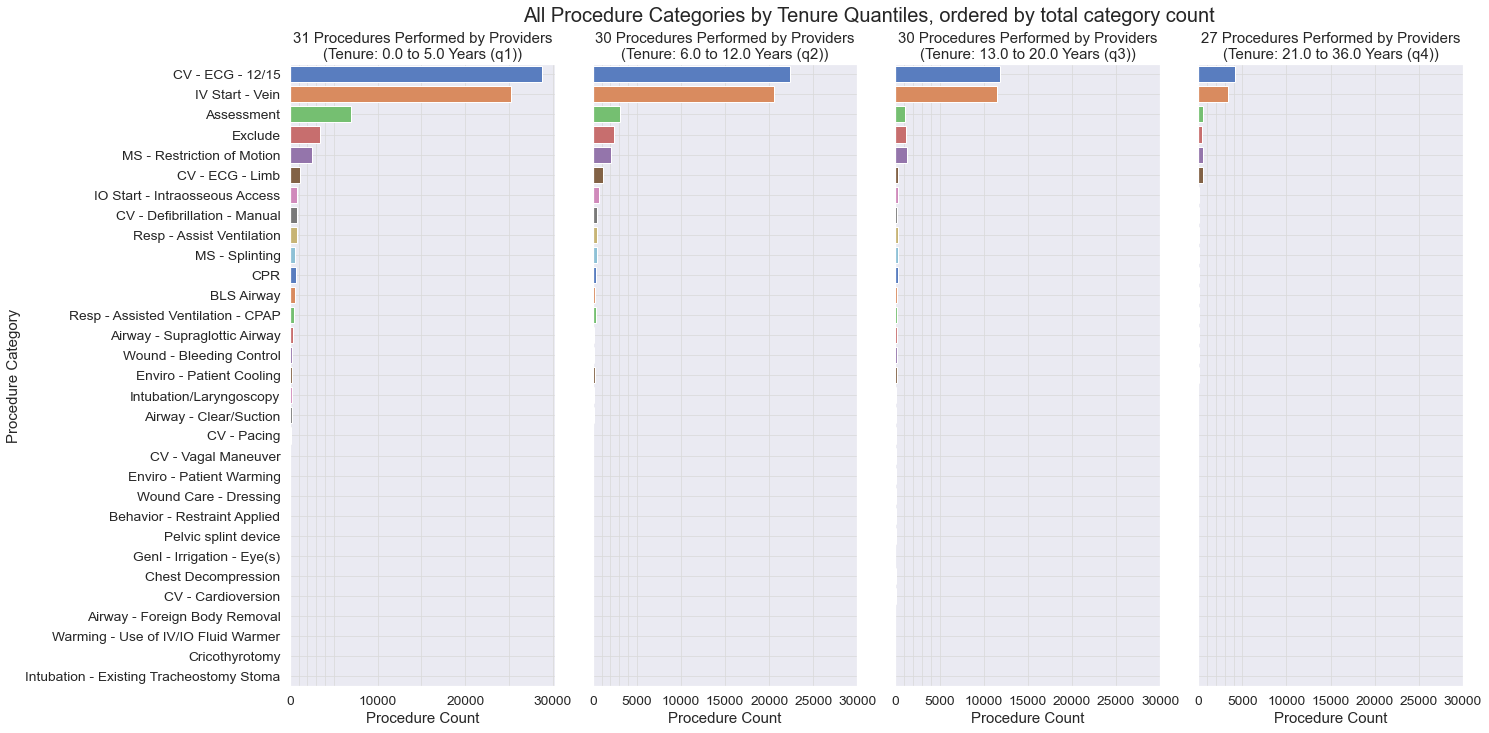

In [178]:
title_q4 = " ".join([str(q4_cat_count),'Procedures Performed by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_cat_count),'Procedures Performed by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_cat_count),'Procedures Performed by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_cat_count),'Procedures Performed by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# build and show procedure category bar charts from all 4 quantiles side by side
bar_width = 1.0
tick_list = ticklst_30000 
x_range = xrng_30000  

fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(17, 10))
fig.suptitle("All Procedure Categories by Tenure Quantiles, ordered by total category count",fontsize=20)
fig.tight_layout(pad=0.3, w_pad=0.75, h_pad=1.0)
fig.subplots_adjust(top=0.90)
plt.xlim(x_range)

df_array = [dfPP_pvt_yr_q1totcat,dfPP_pvt_yr_q2totcat,dfPP_pvt_yr_q3totcat,dfPP_pvt_yr_q4totcat]
title_array = [title_q1,title_q2,title_q3,title_q4]
ylabel_text = 'Procedure Category'
sns.set(font_scale = 1.25)
for cht in range(0,4):
    sns.barplot(ax=axs[cht], x='Procedure_Count', 
                y='ProcedureCategory', 
                palette=colorMap, 
                order=ProcCatOrder,
                data=df_array[cht])
    axs[cht].set_ylabel(ylabel_text)
    axs[cht].set_xlabel('Procedure Count')
    axs[cht].set_title(title_array[cht])
    axs[cht].set_xticks(minor=True, ticks=tick_list)
    #axs[cht].grid(axis='both', alpha=.75, which='both', color='0.85')
    axs[cht].grid(b=True, axis='both', alpha=.75, which='both', color='0.85')
    ylabel_text = ' '


# show plots
plt.show()

Similar to before, the two categories CV - ECG - 12/15 (11) and IV Start - Vein (22) are significantly higher in count than any other categories. This circumstance makes sense since these 2 categories include the 2 highest count procedures.

So, let's drop these categories and rerun the bar chart.

In [102]:
# set up dataframes that DO NOT contain the top two procedures
dfPP_pvt_yr_q1totcata = dfPP_pvt_yr_q1totcat[(dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 11) & 
                                     (dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 22)]
dfPP_pvt_yr_q2totcata = dfPP_pvt_yr_q2totcat[(dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 11) & 
                                     (dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 22)]
dfPP_pvt_yr_q3totcata = dfPP_pvt_yr_q3totcat[(dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 11) & 
                                     (dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 22)]
dfPP_pvt_yr_q4totcata = dfPP_pvt_yr_q4totcat[(dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 11) & 
                                     (dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 22)]

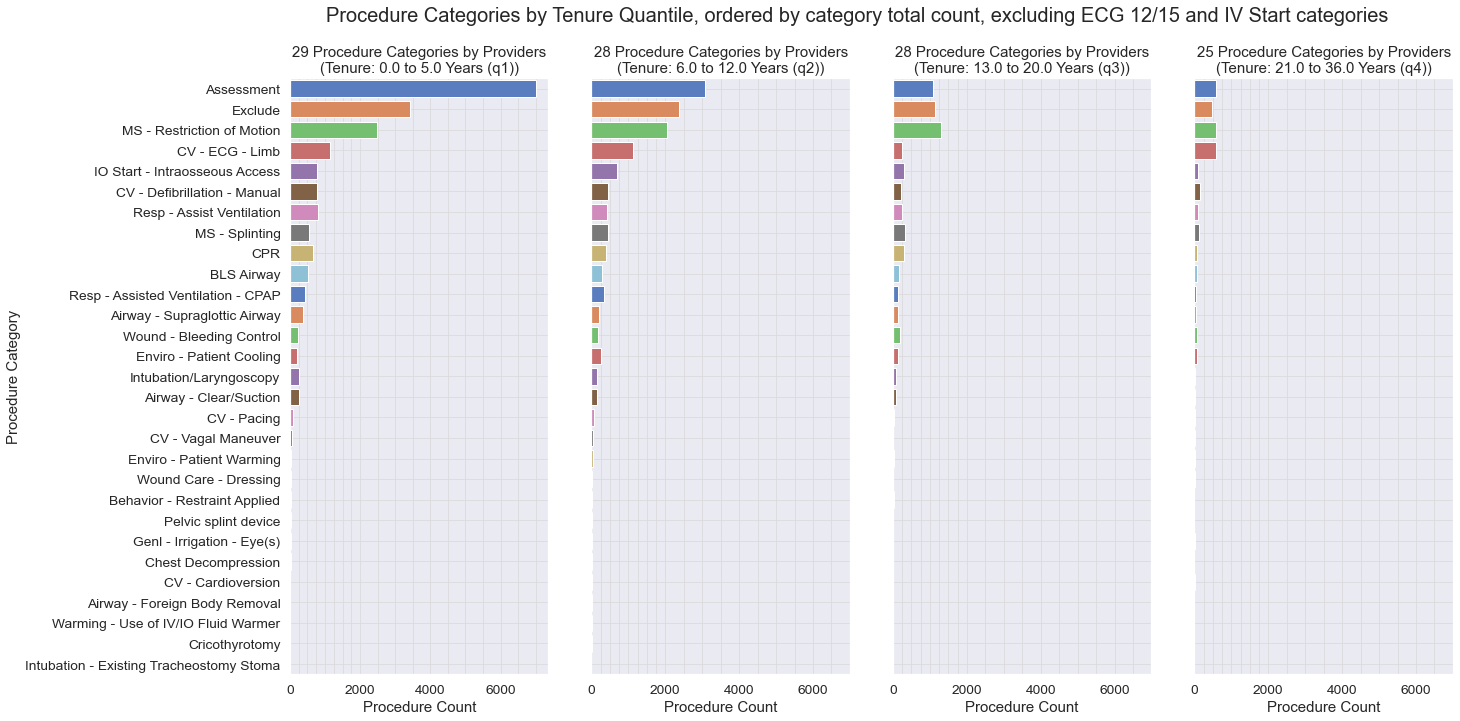

In [177]:
# build plots that exclude the top two highest procedure counts and only show the next 25 highest
title_q4 = " ".join([str(q4_cat_count-2),'Procedure Categories by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_cat_count-2),'Procedure Categories by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_cat_count-2),'Procedure Categories by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_cat_count-2),'Procedure Categories by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# show procedure category bar charts from all 4 quantiles side by side
bar_width = 1.0

tick_list = ticklst_7000
x_range = xrng_7000

fig, axs = plt.subplots(ncols=4, sharey='row', figsize=(17, 10))
plt.xlim(x_range)
fig.suptitle("Procedure Categories by Tenure Quantile, ordered by category total count, excluding ECG 12/15 and IV Start categories",
            fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

df_array = [dfPP_pvt_yr_q1totcata,dfPP_pvt_yr_q2totcata,dfPP_pvt_yr_q3totcata,dfPP_pvt_yr_q4totcata]
title_array = [title_q1,title_q2,title_q3,title_q4]
ylabel_text = 'Procedure Category'
sns.set(font_scale = 1.25)
for cht in range(0,4):
    sns.barplot(ax=axs[cht], x='Procedure_Count', 
                y='ProcedureCategory', 
                palette=colorMap, 
                order=ProcCatOrder[2:32],
                data=df_array[cht])
    axs[cht].set_ylabel(ylabel_text)
    axs[cht].set_xlabel('Procedure Count')
    axs[cht].set_title(title_array[cht])
    axs[cht].set_xticks(minor=True, ticks=tick_list)
    #axs[cht].grid(axis='both', alpha=.75, which='both', color='0.85')
    axs[cht].grid(b=True, axis='both', alpha=.75, which='both', color='0.85')

    
    ylabel_text = ' '


# show the plots
plt.show()



Following what was seen previously, it makes sense that the Assessment category is the highest in the first quantile chart since it was the "Assessment of Patient" procedure that was seen to be high before when the top ECG and IV Start procedures were dropped.

What is included in the "Assesment" category? And, how many procedures are accounted for in the category across all quantiles?

In [104]:
# what procedure make up the Assessment category
print(dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'Assessment')].Procedure_Performed_Description.unique())

['Assess - Capnograph waveform' 'Assess - Blood Glucose Level (BGL)'
 'Assess - Assessment of Patient' 'Assess - Capnography (ETCO2)'
 'Assess - Measurement of carbon monoxide (ETCO)'
 'Assess - SpCO - Carbon Monoxide - Carboxyhemoglobin - (RAD57)']


In [105]:
# how many total Assessment procedures performed across all quantiles
print(" ".join(["Number of Assessment procedures performed across all quantiles:",
                str(dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'Assessment')].Procedure_Count.sum())]))

Number of Assessment procedures performed across all quantiles: 11758


What is included in the "Exclude" category? And, how many procedures are accounted for in the category across all quantiles?

In [106]:
# what procedure make up the Exclude category
print(dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'Exclude')].Procedure_Performed_Description.unique())

['Electrocardiographic monitoring'
 'Intubation - C-Collar for Stabilization'
 "Gen'l - Monitoring of Preexisting Devices and Interventions"
 'Wound Care - Irrigation' 'Wound Care - General' 'Airway - Open/Position'
 'Airway - Removal of Adjunct (non-ETT)' 'Hemorrhage Clamp'
 'IV - Discontinue' 'Assess - Orthostatic Vital Signs'
 "Gen'l - Extrication" 'Wound - Burn Care'
 'Intubation - Cricoid Pressure Applied' 'CPR - Discontinued'
 'ROSC (Assessment Finding)' 'OB - Childbirth - EMS Personnel Present'
 'Infectious - Decontamination of Patient'
 'Enviro - Hypothermia Induction Therapy']


In [107]:
# how many total Exclude procedures across all quantiles
print(" ".join(["Number of Exclude procedures performed across all quantiles:",
                str(dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'Exclude')].Procedure_Count.sum())]))

Number of Exclude procedures performed across all quantiles: 7440


Now there are 4 categories that make it hard to see anything else. By removing CV - ECG - 12/15 (11), IV Start - Vein (22), Exclude (0), and Assessment (4) categories from the quantile-based dataframes we may be able see something new.

In [108]:
# set up dataframes that DO NOT contain the top two procedures, in addition to dropping Assessment and Exclude categories
dfPP_pvt_yr_q1totcatb = dfPP_pvt_yr_q1totcat[(dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 11) & 
                                             (dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 0)  &
                                             (dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 4)  &
                                             (dfPP_pvt_yr_q1totcat['ProcedureCatCode'] != 22)]
dfPP_pvt_yr_q2totcatb = dfPP_pvt_yr_q2totcat[(dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 11) & 
                                             (dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 0)  &
                                             (dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 4)  &
                                             (dfPP_pvt_yr_q2totcat['ProcedureCatCode'] != 22)]
dfPP_pvt_yr_q3totcatb = dfPP_pvt_yr_q3totcat[(dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 11) & 
                                             (dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 0)  &
                                             (dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 4)  &
                                             (dfPP_pvt_yr_q3totcat['ProcedureCatCode'] != 22)]
dfPP_pvt_yr_q4totcatb = dfPP_pvt_yr_q4totcat[(dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 11) & 
                                             (dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 0)  &
                                             (dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 4)  &
                                             (dfPP_pvt_yr_q4totcat['ProcedureCatCode'] != 22)]

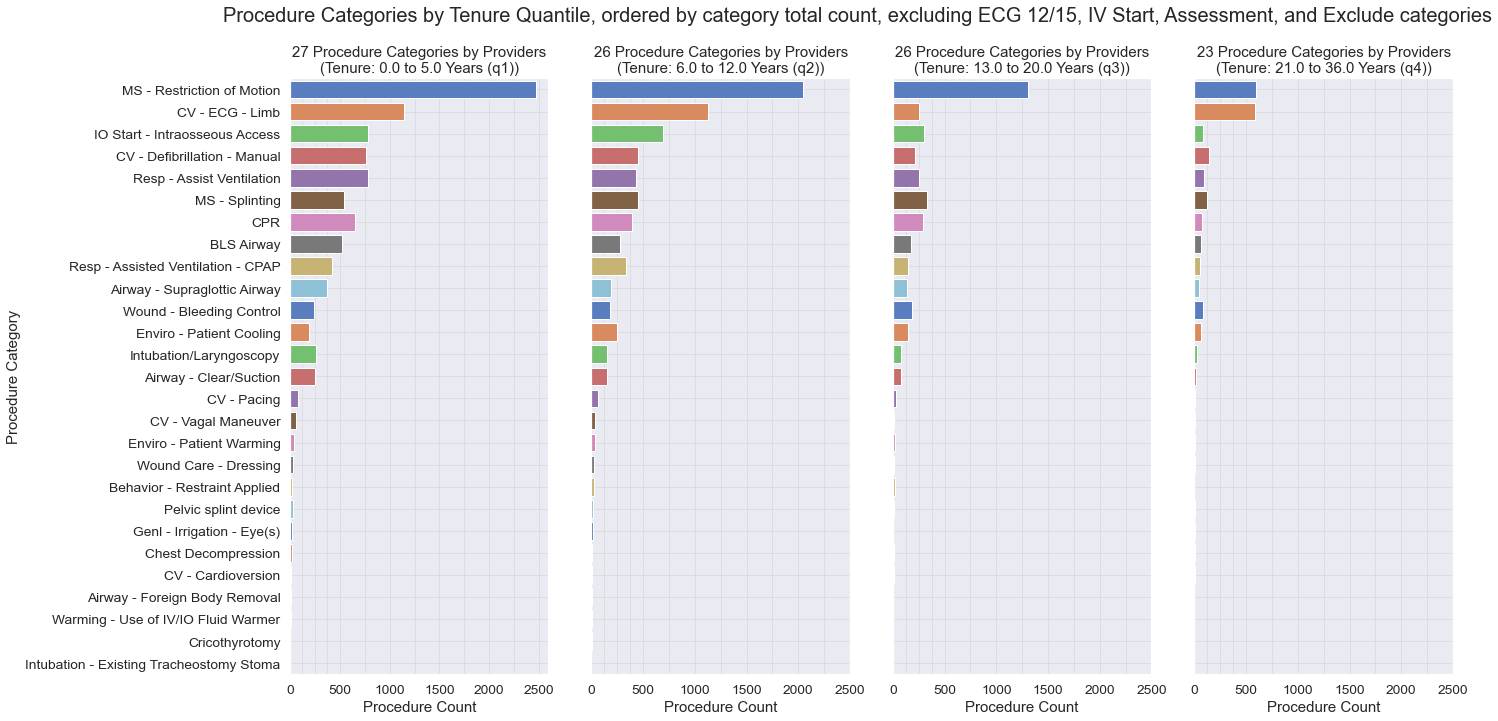

In [176]:
# build plots that exclude the top two highest procedure counts and only show the next 25 highest
title_q4 = " ".join([str(q4_cat_count-4),'Procedure Categories by Providers\n(Tenure:',str(q4_low_yr),'to',str(q4_high_yr),'Years (q4))'])
title_q3 = " ".join([str(q3_cat_count-4),'Procedure Categories by Providers\n(Tenure:',str(q3_low_yr),'to',str(q3_high_yr),'Years (q3))'])
title_q2 = " ".join([str(q2_cat_count-4),'Procedure Categories by Providers\n(Tenure:',str(q2_low_yr),'to',str(q2_high_yr),'Years (q2))'])
title_q1 = " ".join([str(q1_cat_count-4),'Procedure Categories by Providers\n(Tenure:',str(q1_low_yr),'to',str(q1_high_yr),'Years (q1))'])

# show procedure bar charts from all 4 quantiles side by side
bar_width = 1.0

ticklst_2500 = [125,250,375,500,750,1000,1250,1500,1750,2000,2250,2500]
ticklst_2500_mj = ['','','',500,'',1000,'',1500,'',2000,'',2500]
ticklst_2500_mn = [125,250,375,750,1250,1750,2250]

#ticklst_2500 = [125,250,375,750,1250,1750,2250]
xrng_2500 = [0,2500]

tick_list = ticklst_2500
x_range = xrng_2500

fig, axs = plt.subplots(ncols=4, sharey='row', figsize=(17, 10))
plt.xlim(x_range)
fig.suptitle("Procedure Categories by Tenure Quantile, ordered by category total count, excluding ECG 12/15, IV Start, Assessment, and Exclude categories",
            fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.88)


df_array = [dfPP_pvt_yr_q1totcatb,dfPP_pvt_yr_q2totcatb,dfPP_pvt_yr_q3totcatb,dfPP_pvt_yr_q4totcatb]
title_array = [title_q1,title_q2,title_q3,title_q4]
ylabel_text = 'Procedure Category'
sns.set(font_scale = 1.25)
for cht in range(0,4):
    sns.barplot(ax=axs[cht], x='Procedure_Count', 
                y='ProcedureCategory', 
                palette=colorMap, 
                order=ProcCatOrder[4:32],
                data=df_array[cht])
    axs[cht].set_ylabel(ylabel_text)
    axs[cht].set_xlabel('Procedure Count')
    axs[cht].set_title(title_array[cht])
    axs[cht].set_xticks(minor=True, ticks=tick_list)
#    axs[cht].set_xticks(minor=True, ticks=ticklst_2500_mn)
#    axs[cht].set_xticks(ticklst_2500)
#    axs[cht].set_xticklabels(ticklst_2500_mj)
    axs[cht].grid(b=True, axis='both', alpha=.75, which='both', color='0.85')

    ylabel_text = ' '


# show the plots
plt.show()

The most obvious item is that in the 4th quantile plot CV - ECG - Limb appears to contain the same, or almost the same, number of procedures that MS - Restriction of Motion does.  

This pattern is different than the other 3 quantiles.  However, it is supported by the evidence seen earlier that showed CV - ECG - Limb Lead Monitoring (the primary procedure in the CV - ECG - Limb category) was the procedure with the highest count after removing the high IV Start and CV - ECG - 12 Lead procedures.

Taking a look at the MS - Restriction of Motion and CV - ECG - Limb categories, let's see what the actual numbers and category members show.

In [110]:
# how many total Restriction of Motion categorized procedures across all quantiles
print(" ".join(["Number of MS - Restriction of Motion procedures performed across all quantiles:",
                str(dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'MS - Restriction of Motion')].Procedure_Count.sum())]))

# what procedures make up the Restriction of Motion category
print(dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'MS - Restriction of Motion')].Procedure_Performed_Description.unique())

Number of MS - Restriction of Motion procedures performed across all quantiles: 6415
['MS - Cervical Spinal Restriction of Motion'
 'MS - Full Spinal Restriction of Motion']


In [111]:
# how many total CV - ECG - Limb categorized procedures across all quantiles
print(" ".join(["Number of CV - ECG - Limb procedures performed across all quantiles:",
                str(dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'CV - ECG - Limb')].Procedure_Count.sum())]))

Number of CV - ECG - Limb procedures performed across all quantiles: 3114


In [112]:
# how many total Restriction of Motion categorized procedures performed in 4th quantile
print(" ".join(["Number of MS - Restriction of Motion procedures performed in 4th quantile:",
                str(dfPP_pvt_yr_q4totcatb[(dfPP_pvt_yr_q4totcatb['ProcedureCategory'] == 'MS - Restriction of Motion')].Procedure_Count.sum())]))
# what procedures make up the Restriction of Motion category
print(dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'MS - Restriction of Motion')].Procedure_Performed_Description.unique())
print("\n")
# how many total CV - ECG - Limb categorized procedures performed in 4th quantile
print(" ".join(["Number of CV - ECG - Limb procedures performed performed in 4th quantile:",
                str(dfPP_pvt_yr_q4totcatb[(dfPP_pvt_yr_q4totcatb['ProcedureCategory'] == 'CV - ECG - Limb')].Procedure_Count.sum())]))
# what procedures make up the CV - ECG - Limb category
print(dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'CV - ECG - Limb')].Procedure_Performed_Description.unique())

Number of MS - Restriction of Motion procedures performed in 4th quantile: 591
['MS - Cervical Spinal Restriction of Motion'
 'MS - Full Spinal Restriction of Motion']


Number of CV - ECG - Limb procedures performed performed in 4th quantile: 584
['CV - ECG - Limb Lead Monitoring']


In [113]:
# what is the count composition of the procedures that make up the Restriction of Motion category in the 4th quantile
print(" ".join(["Number of MS - Cervical Spinal Restriction of Motion procedures performed in 4th quantile:",
                str(dfPP_pvt_yr_q4tot[(dfPP_pvt_yr_q4tot['Procedure_Performed_Description'] == 'MS - Cervical Spinal Restriction of Motion')].Procedure_Count.sum())]))
print(" ".join(["Number of MS - Full Spinal Restriction of Motion procedures performed in 4th quantile:",
                str(dfPP_pvt_yr_q4tot[(dfPP_pvt_yr_q4tot['Procedure_Performed_Description'] == 'MS - Full Spinal Restriction of Motion')].Procedure_Count.sum())]))

Number of MS - Cervical Spinal Restriction of Motion procedures performed in 4th quantile: 418
Number of MS - Full Spinal Restriction of Motion procedures performed in 4th quantile: 173


In [114]:
# how many total CV - ECG - 12/15 categorized procedures across all quantiles
print(" ".join(["Number of CV - ECG - 12/15 procedures performed across all quantiles:",
                str(dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'CV - ECG - 12/15')].Procedure_Count.sum())]))
# how many total IV Start - Vein categorized procedures across all quantiles
print(" ".join(["Number of IV Start - Vein procedures performed across all quantiles:",
                str(dfPP_pvt_yr_cat[(dfPP_pvt_yr_cat['ProcedureCategory'] == 'IV Start - Vein')].Procedure_Count.sum())]))

Number of CV - ECG - 12/15 procedures performed across all quantiles: 67186
Number of IV Start - Vein procedures performed across all quantiles: 60457


We can see that while the overall count of MS - Restriction of Motion procedures is higher than that of the CV - ECG - Limb by almost 2x, when just comparing the counts in the 4th quantile, there is only a difference of 7.

Now, let's take a look at the Procedure Categories plotted in a violin plot using area to normalize the values.  We are looking at the categories since there are only 31 of those versus 67 distinct procedures.

In [115]:
dfProcCatList

ProcedureCategory  Category_Total
ProcedureCatCode                                                          
0                                                  Exclude            7440
1                                   Airway - Clear/Suction             504
2                            Airway - Foreign Body Removal              19
3                             Airway - Supraglottic Airway             740
4                                               Assessment           11758
5                             Behavior - Restraint Applied              67
6                                               BLS Airway            1046
7                                                      CPR            1399
8                                           Cricothyrotomy               8
9                                       CV - Cardioversion              31
10                            CV - Defibrillation - Manual            1567
11                                        CV - ECG - 12/15           67186
12                                         CV - ECG - Limb            3114
13                                             CV - Pacing             178
14                                     CV - Vagal Maneuver             120
15                                     Chest Decompression              42
16                                Enviro - Patient Cooling             647
17                                Enviro - Patient Warming             100
18                              Genl - Irrigation - Eye(s)              42
19                Intubation - Existing Tracheostomy Stoma               3
20                                 Intubation/Laryngoscopy             512
21                          IO Start - Intraosseous Access            1857
22                                         IV Start - Vein           60457
23                              MS - Restriction of Motion            6415
24                                          MS - Splinting            1450
25                                    Pelvic splint device              66
26                               Resp - Assist Ventilation            1558
27                      Resp - Assisted Ventilation - CPAP             960
28                     Warming - Use of IV/IO Fluid Warmer              12
29                                Wound - Bleeding Control             676
30                                   Wound Care - Dressing              77

Text(0.5, 1.0, 'Procedure Categories by Tenure (years)')

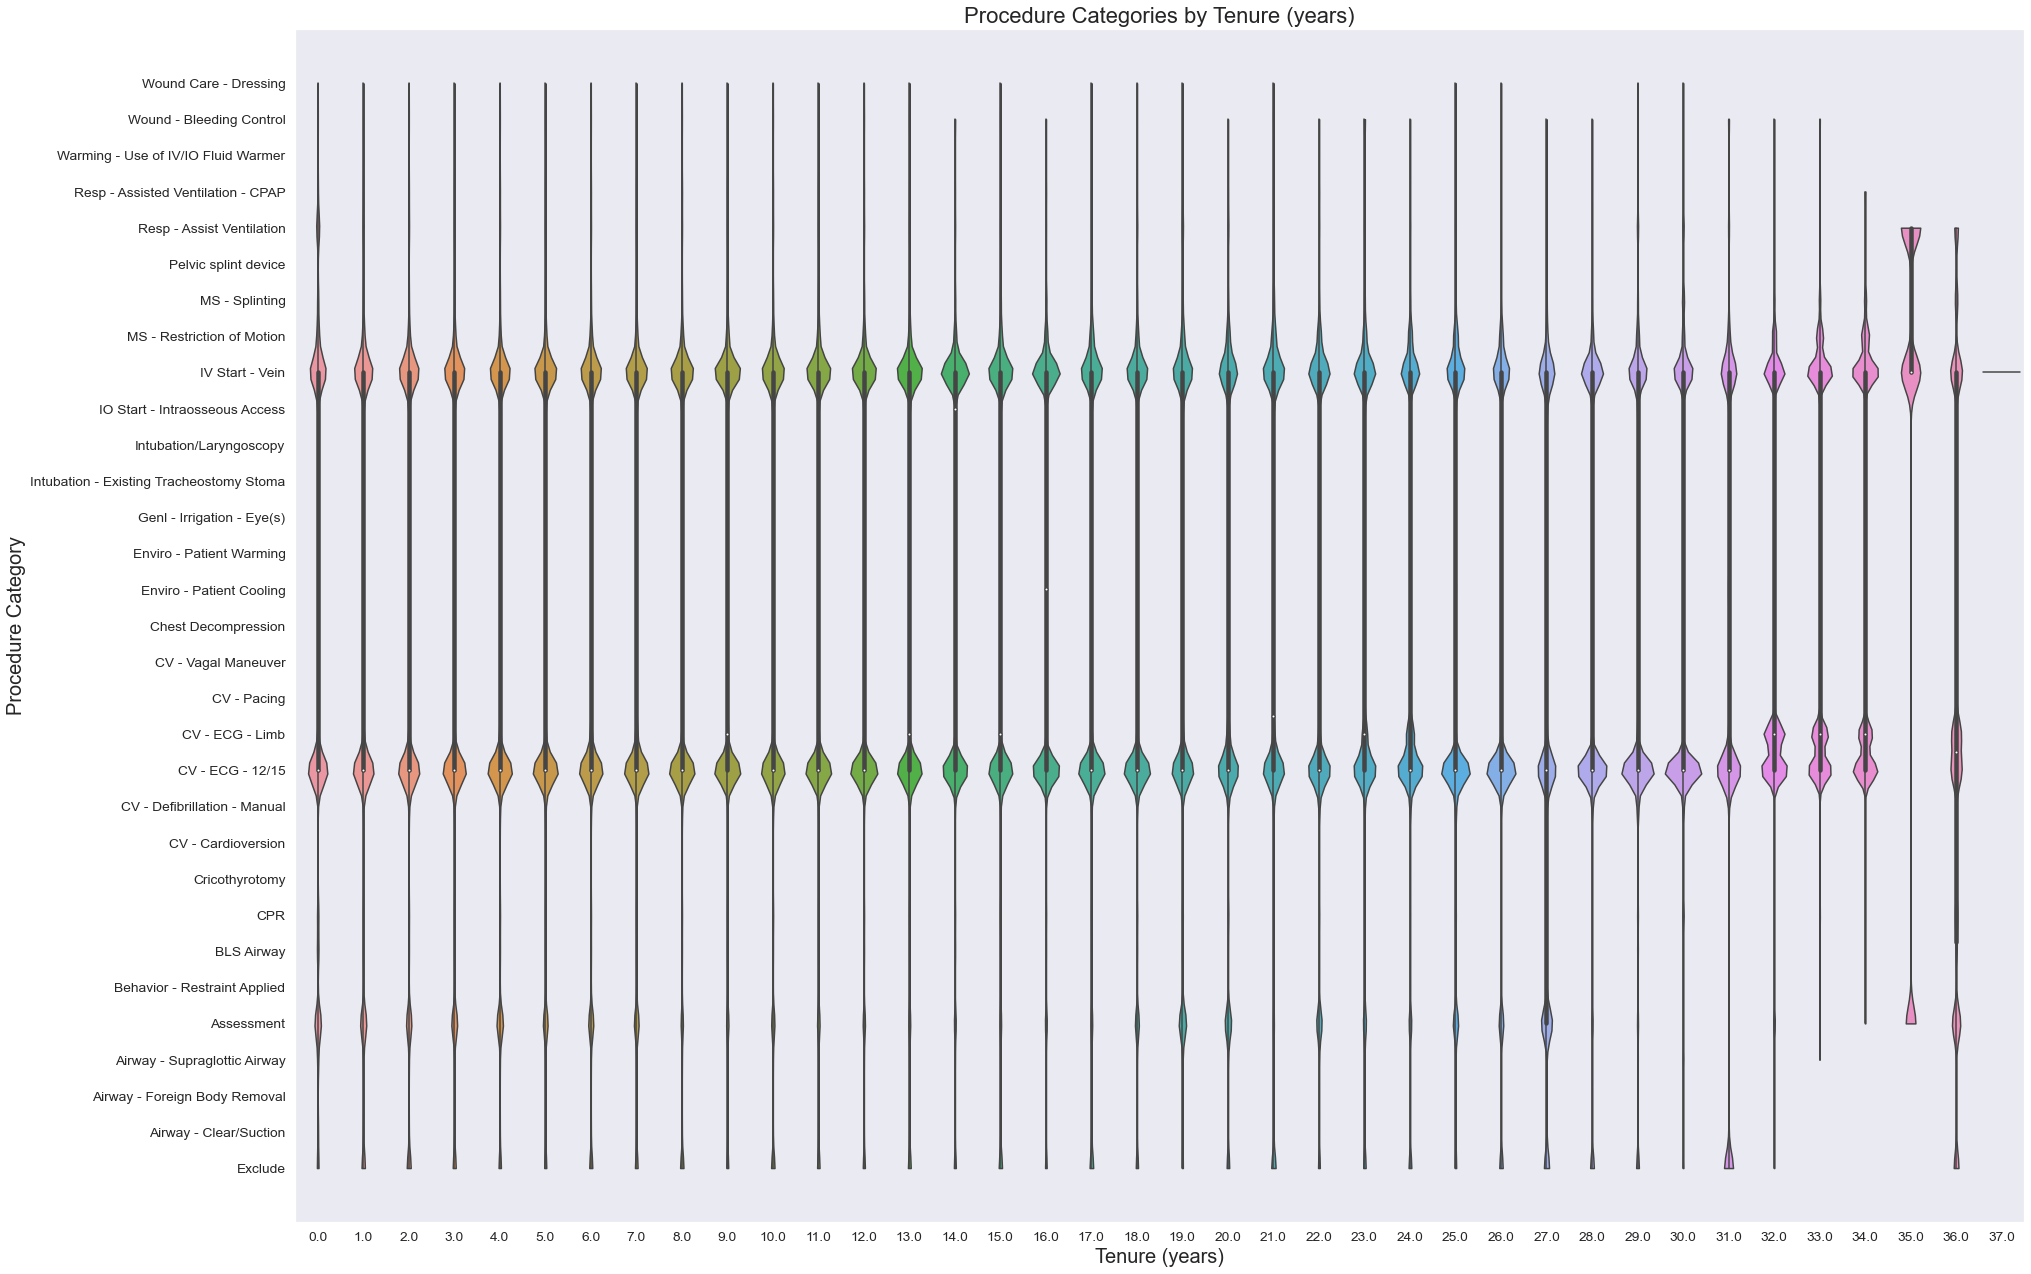

In [116]:
# plot procedures using violin plot
fig, axs = plt.subplots(figsize=(25,18))
#fig.suptitle("Procedure Categories by Tenure (years)")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
sns.set(font_scale = 1.5)
sns.violinplot(ax=axs, y="ProcedureCatCode",x="TenureYears",
               data=dfPPBaselineCat, 
               scale='area',
               bw=.05,
               cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList.index)
axs.set_yticklabels(dfProcCatList.ProcedureCategory.to_list())
axs.set_ylabel("Procedure Category", fontsize=20)
axs.set_xlabel("Tenure (years)", fontsize=20)
axs.set_title("Procedure Categories by Tenure (years)", fontsize=22)


There is nothing new that has not already been seen with respect to the distribution of the procedure categories over tenure.  However what is new is the fact that it can be readily seen that those providers of high tenure (i.e., over 30 years), do not perform all of the possible 31 procedure categories.  In fact there are instances where very few procedures are completed. As noted in prior bar chart evaluation, the other most distinctive element seen is the use of the procedures in the MS - Restriction of Motion and CV - ECG - Limb categories again by those providers with over 30 years of tenure.

Let's take a look at dropping those high count categories again and see how their absence changes the plots.

In [117]:
print("Drop Exclude Category")
dfPPBCat_dropexcl = dfPPBaselineYrCat[(dfPPBaselineYrCat['ProcedureCatCode'] != 0)]
print(dfPPBCat_dropexcl[(dfPPBCat_dropexcl['ProcedureCategory'] == 'Exclude')].value_counts())
#print(dfPPBCat_dropexcl[(dfPPBCat_dropexcl['ProcedureCatCode'] == 11)].value_counts())

print("Drop Assessment Category")
dfPPBCat_dropexcl_assess = dfPPBaselineYrCat[(dfPPBaselineYrCat['ProcedureCatCode'] != 0) & 
                                                  (dfPPBaselineYrCat['ProcedureCatCode'] != 4)]
print(dfPPBCat_dropexcl_assess[(dfPPBCat_dropexcl_assess['ProcedureCategory'] == 'Assessment')].value_counts())
#print(dfPPBCat_dropexcl_assess[(dfPPBCat_dropexcl_assess['ProcedureCatCode'] == 11)].value_counts())

print("Drop IV Start and ECG 12/15 Categories")
dfPPBCat_dropexcl_assess_t2 = dfPPBaselineYrCat[(dfPPBaselineYrCat['ProcedureCatCode'] != 0) & 
                                                (dfPPBaselineYrCat['ProcedureCatCode'] != 4) &
                                                (dfPPBaselineYrCat['ProcedureCatCode'] != 11) & 
                                                (dfPPBaselineYrCat['ProcedureCatCode'] != 22)]
print(dfPPBCat_dropexcl_assess_t2[(dfPPBCat_dropexcl_assess_t2['ProcedureCategory'] == 'IV Start - Vein')].value_counts())
print(dfPPBCat_dropexcl_assess_t2[(dfPPBCat_dropexcl_assess_t2['ProcedureCategory'] == 'CV - ECG - 12/15')].value_counts())


Drop Exclude Category
Series([], dtype: int64)
Drop Assessment Category
Series([], dtype: int64)
Drop IV Start and ECG 12/15 Categories
Series([], dtype: int64)
Series([], dtype: int64)


Starting with just dropping the Exclude category, the most discernable change is seen at 31 and 36 years of tenure where there had been a noticeable count of procedures performed.

In [118]:
#dfPP_pvt_yr_cat_dropexcl_assess

In [119]:
dfProcCatList_dropexcl = dfProcCatList.drop(index = 0)
dfProcCatList_dropexcl_assess = dfProcCatList.drop(index=[0,4])
dfProcCatList_dropexcl_assess_t2 = dfProcCatList.drop(index=[0,4,11,22])

Text(0.5, 1.0, 'Procedure Categories by Tenure (years), excluding Exclude category')

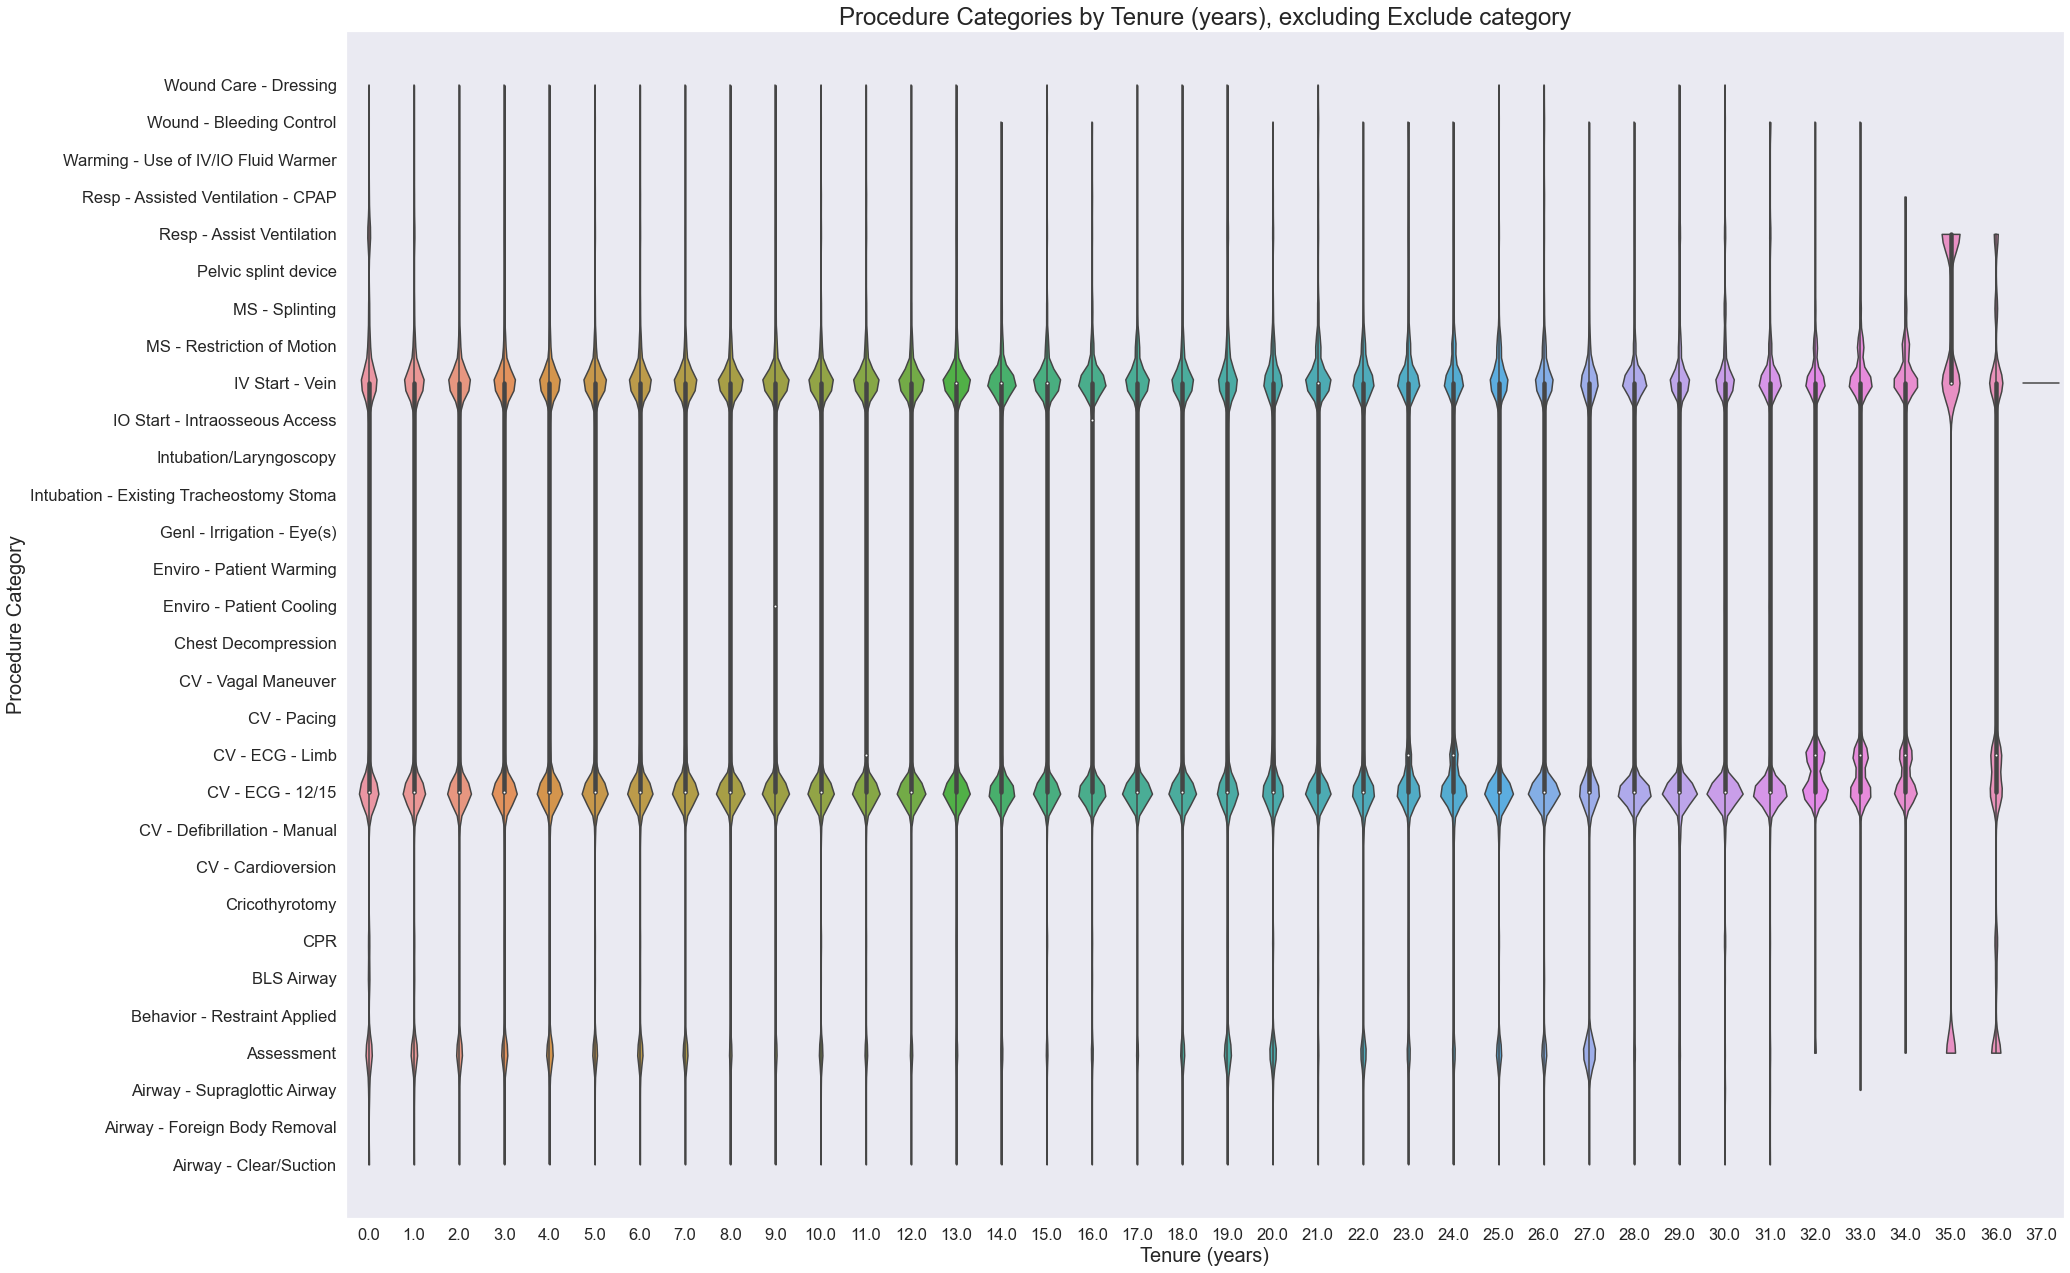

In [120]:
fig, axs = plt.subplots(figsize=(25,18))
#fig.suptitle("Procedure Categories by Tenure (years), excluding Exclude category")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
sns.set(font_scale = 1.5)
sns.violinplot(ax = axs, y="ProcedureCatCode",x="TenureYears",
               data=dfPPBCat_dropexcl, 
               scale='area',
               bw=.05,
               cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList_dropexcl.index)
axs.set_yticklabels(dfProcCatList_dropexcl.ProcedureCategory.to_list())
axs.set_ylabel("Procedure Category", fontsize=20)
axs.set_xlabel("Tenure (years)", fontsize=20)
axs.set_title("Procedure Categories by Tenure (years), excluding Exclude category", fontsize=24)


Dropping the Assessment category, the plot adjusts again for the loss of procedure counts, however the overall patterns around the CV - ECG - 12/15, IV Start - Vein, and Restriction of Motion categories can still be seen.  Supporting indicators already seen.  The most obvious change is the fact that providers with 35 years of tenure now only show obvious procedure counts in two categories - IV Start - Vein and Resp - Assist Ventilation.

Text(0.5, 1.0, 'Procedure Categories by Tenure (years), excluding Assessment and Exclude categories')

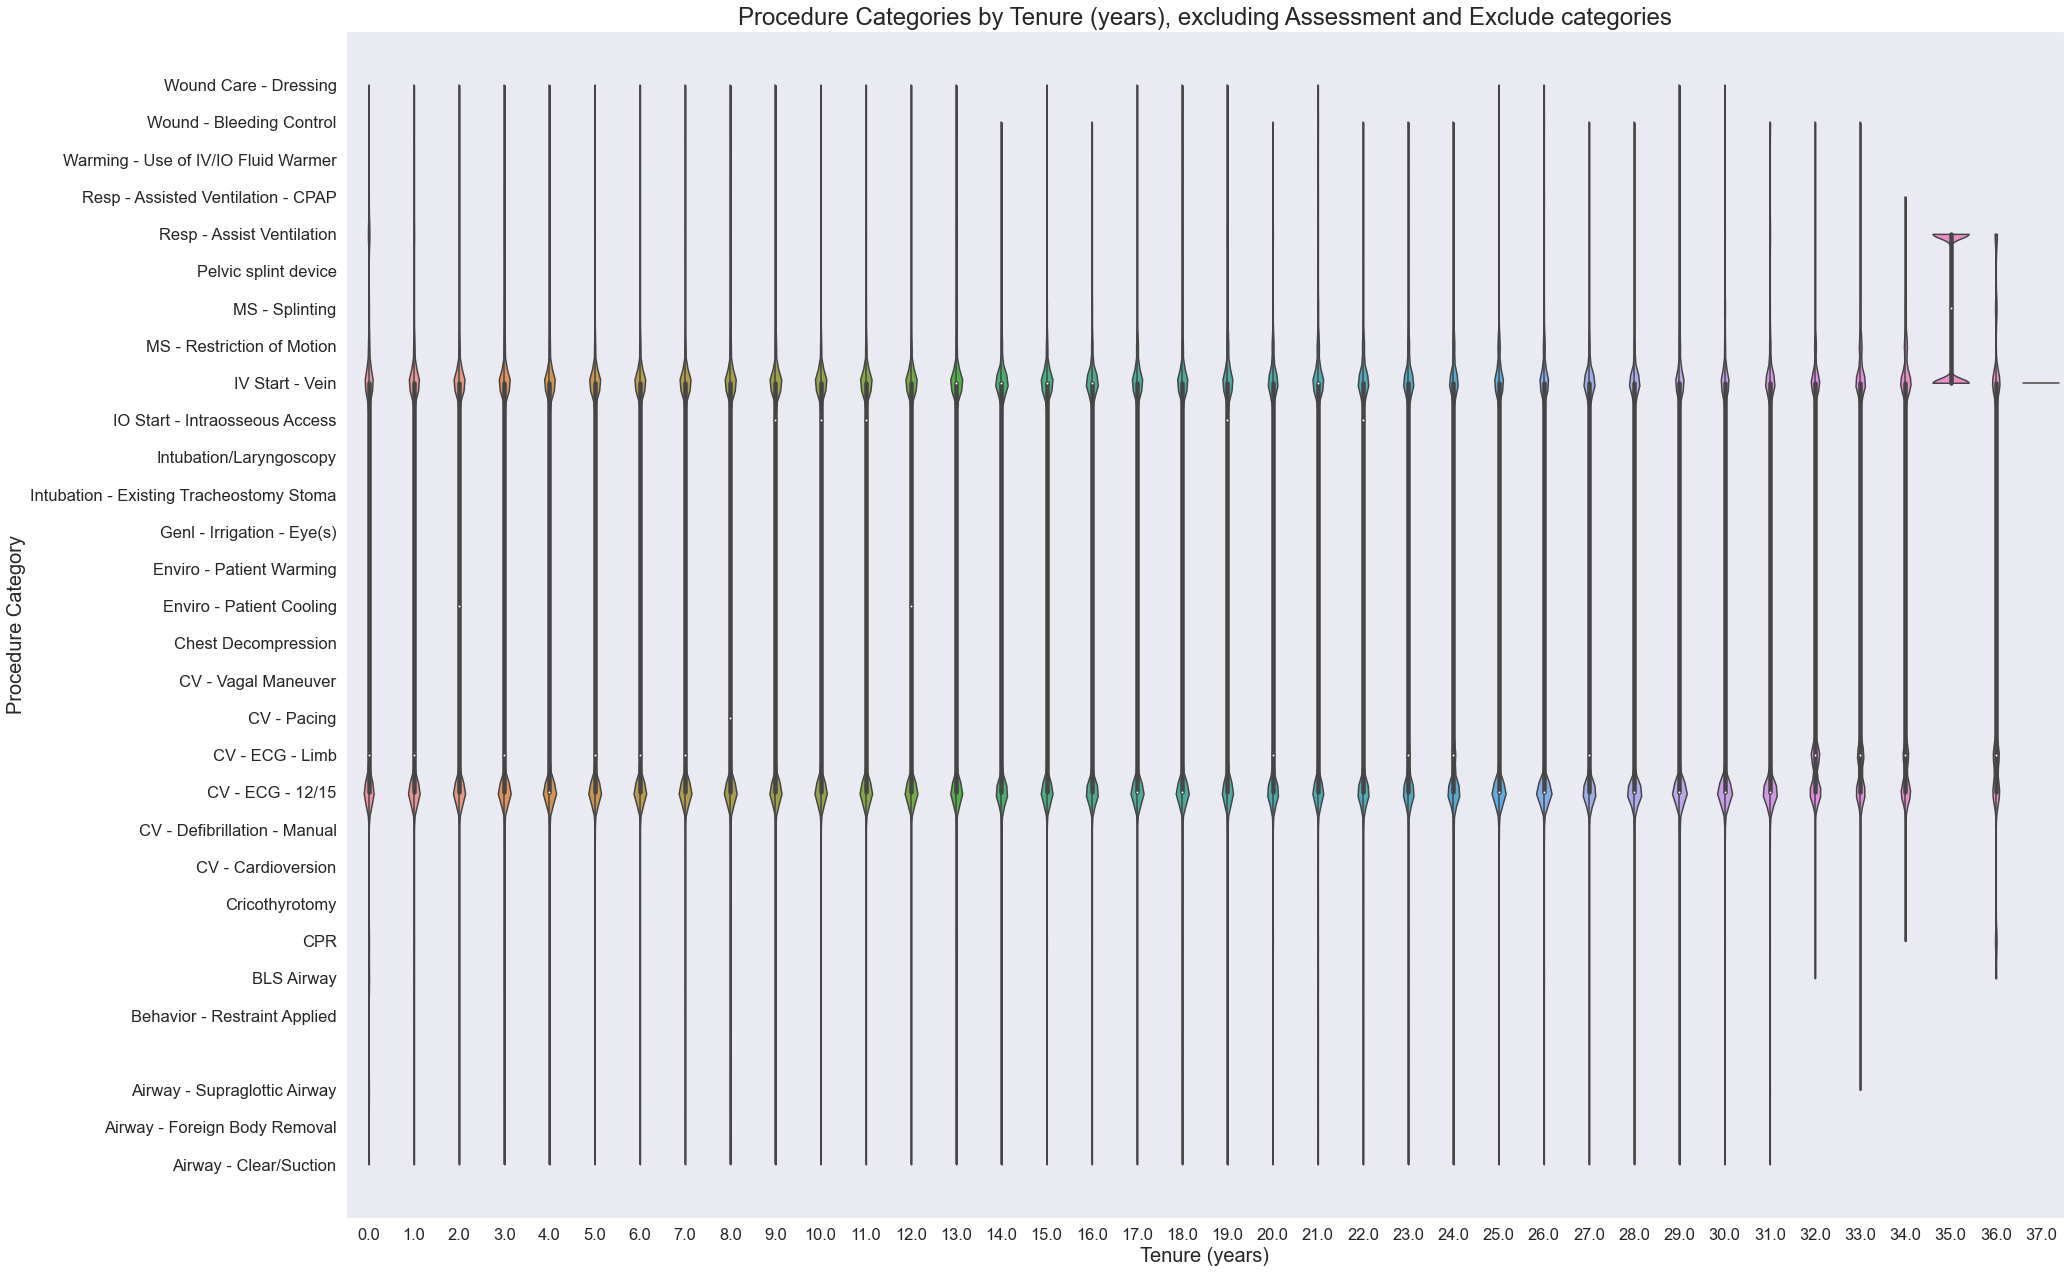

In [121]:
fig, axs = plt.subplots(figsize=(25,18))
#fig.suptitle("Procedure Categories by Tenure (years), excluding Assessment and Exclude categories")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
sns.set(font_scale = 1.5)
sns.violinplot(ax = axs, y="ProcedureCatCode",x="TenureYears",
               data=dfPPBCat_dropexcl_assess, 
               scale='area',
               bw=.05,
               cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList_dropexcl_assess.index)
axs.set_yticklabels(dfProcCatList_dropexcl_assess.ProcedureCategory.to_list())
axs.set_ylabel("Procedure Category", fontsize=20)
axs.set_xlabel("Tenure (years)", fontsize=20)
axs.set_title("Procedure Categories by Tenure (years), excluding Assessment and Exclude categories", fontsize=24)


After a reminder of the number of procedures included in the CV - ECG - 12/15 and IV Start - Vein, taking a look at the violin plot without these two categories included now emphasises the count of CV - ECG - Limb procedures, especially by those providers with more than 30 years tenure.  Additionally, it shows that without the 4 categories now removed from the plot the only procedures performed by providers with 35 years tenure are part of the Resp - Assist Ventilation category. Similarly, providers with 37 years tenure are no longer represented since the only procedures recorded were those in the IV Start - Vein category.

In [122]:
# how many total CV - ECG - 12/15 categorized procedures
print(" ".join(["Number of CV - ECG - 12/15 procedures performed:",
                str(len(dfPPBCat_dropexcl_assess[(dfPPBCat_dropexcl_assess['ProcedureCategory'] == 'CV - ECG - 12/15')]))]))
# how many total IV Start - Vein categorized procedures
print(" ".join(["Number of IV Start - Vein procedures performed:",
                str(len(dfPPBCat_dropexcl_assess[(dfPPBCat_dropexcl_assess['ProcedureCategory'] == 'IV Start - Vein')]))]))

Number of CV - ECG - 12/15 procedures performed: 67186
Number of IV Start - Vein procedures performed: 60457


Text(0.5, 1.0, 'Procedure Categories by Tenure (years), excluding IV Start - Vein, ECG 12/15,\nAssessment and Exclude categories')

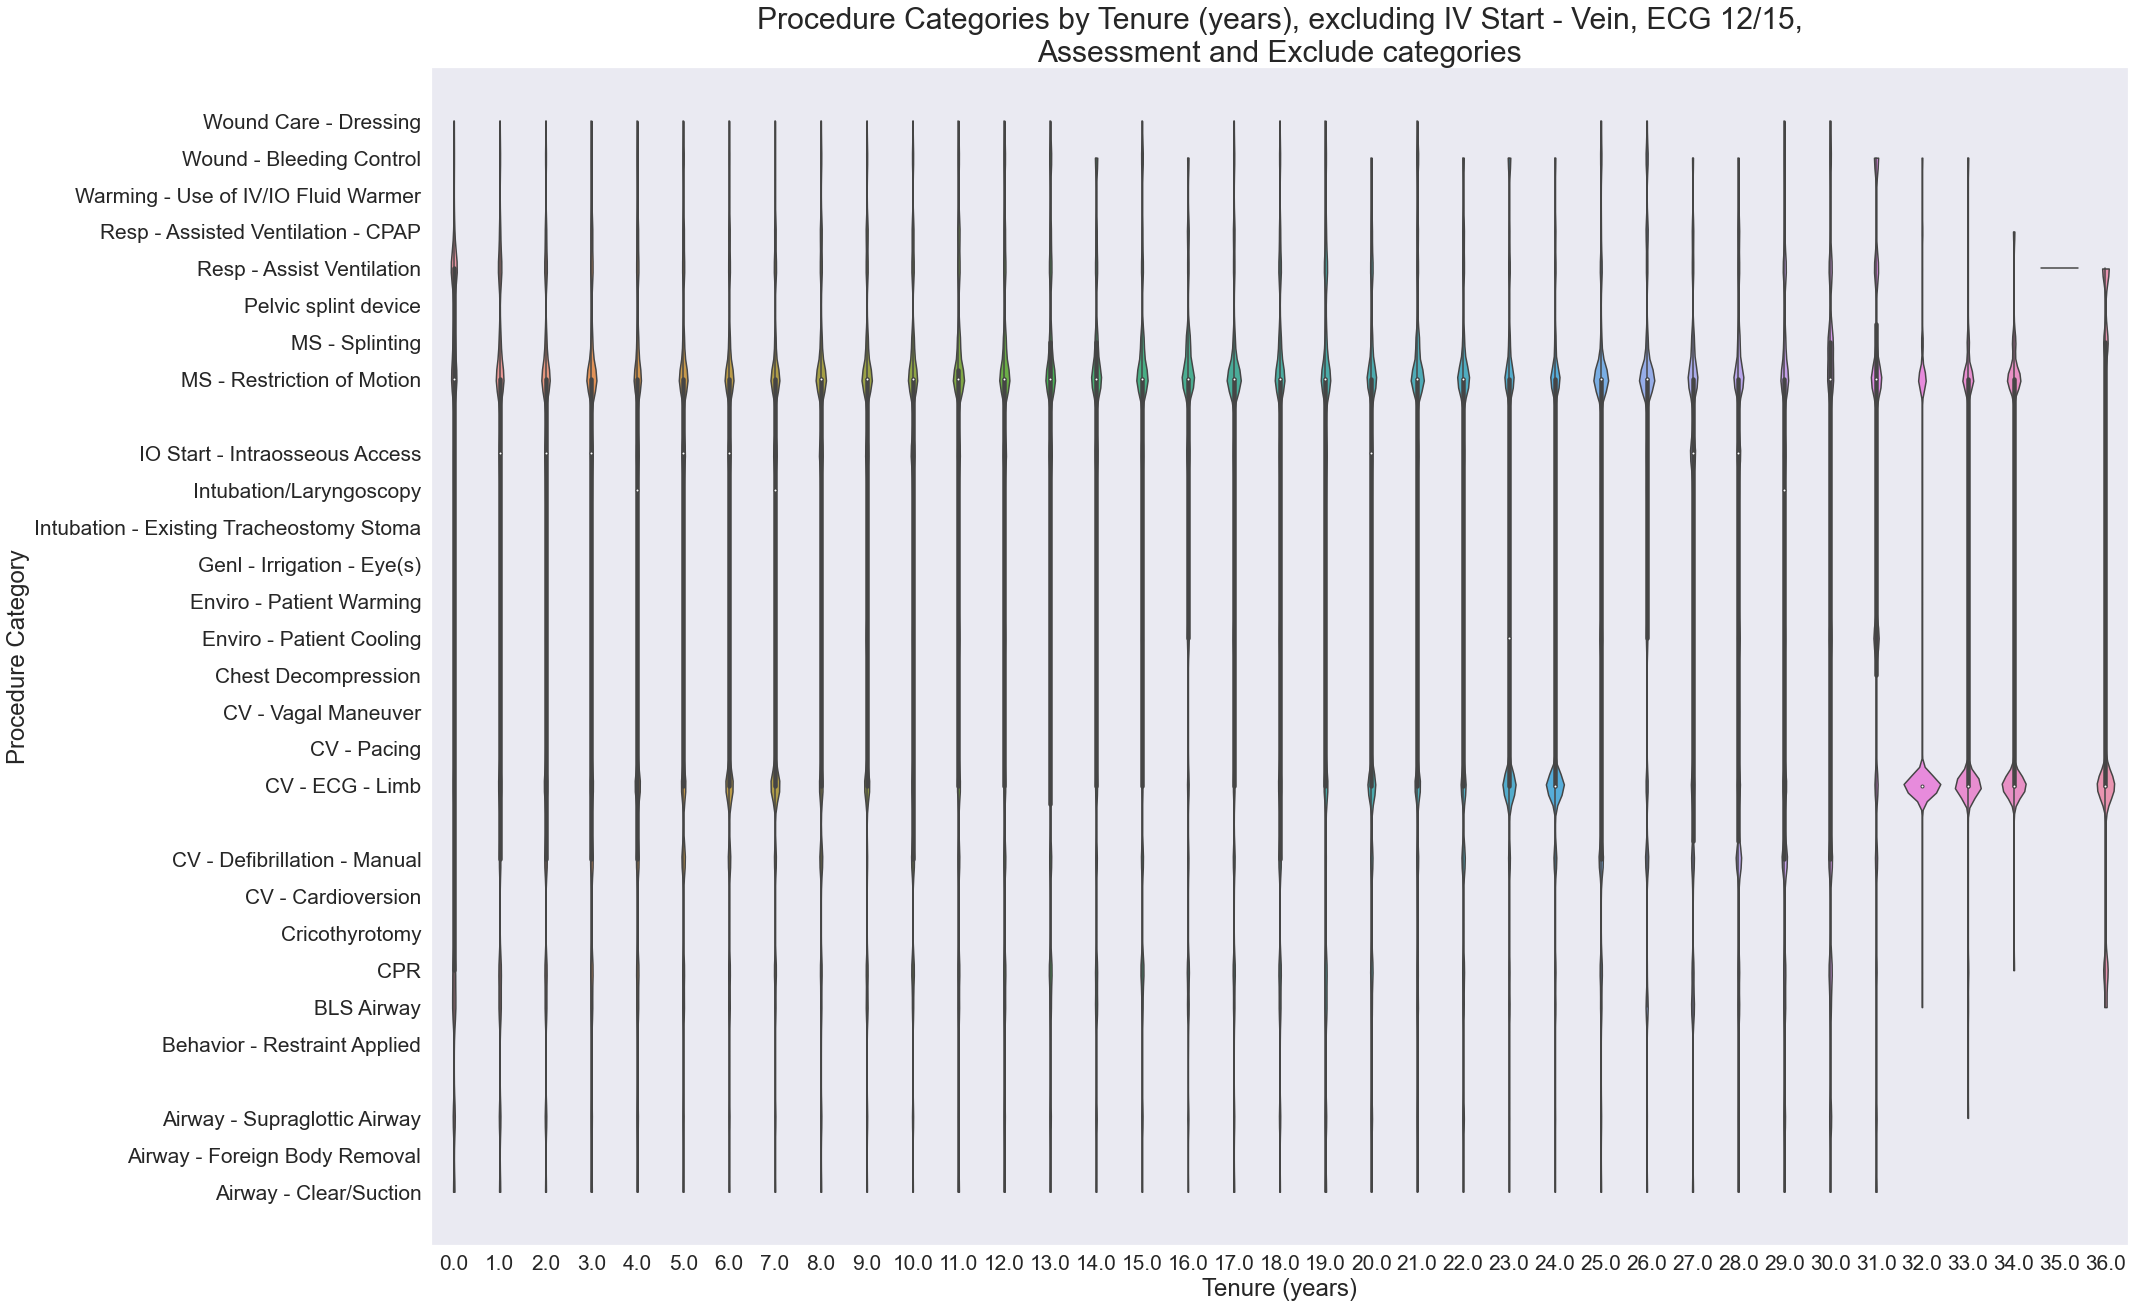

In [236]:
fig, axs = plt.subplots(figsize=(25,18))
#fig.suptitle("Procedure Categories by Tenure (years), excluding Iv Start, CV - ECG, Assessment and Exclude categories")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
sns.set(font_scale = 1.9)
sns.violinplot(ax = axs, y="ProcedureCatCode",x="TenureYears",
               data=dfPPBCat_dropexcl_assess_t2, 
               scale='area',
               bw=.05,
               cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList_dropexcl_assess_t2.index)
axs.set_yticklabels(dfProcCatList_dropexcl_assess_t2.ProcedureCategory.to_list())
axs.set_xticks(minor=False, ticks=dfPPBCat_dropexcl_assess_t2.TenureYears.unique())
axs.set_xticklabels(dfPPBCat_dropexcl_assess_t2.TenureYears.unique())
axs.set_ylabel("Procedure Category",fontsize=24)
axs.set_xlabel("Tenure (years)",fontsize=24)
axs.set_title("Procedure Categories by Tenure (years), excluding IV Start - Vein, ECG 12/15,\nAssessment and Exclude categories",
              fontsize=30)


In [124]:
# how many total Resp - Assist Ventilation related procedures
print(" ".join(["Number of Resp - Assist Ventilation procedures performed:",
                str(len(dfPPBCat_dropexcl_assess_t2[(dfPPBCat_dropexcl_assess_t2['ProcedureCategory'] == 'Resp - Assist Ventilation')]))]))
# how many total Resp - Assist Ventilation - CPAP categorized procedures
print(" ".join(["Number of Resp - Assist Ventilation - CPAP procedures performed:",
                str(len(dfPPBCat_dropexcl_assess_t2[(dfPPBCat_dropexcl_assess_t2['ProcedureCategory'] == 'Resp - Assist Ventilation - CPAP')]))]))


Number of Resp - Assist Ventilation procedures performed: 1558
Number of Resp - Assist Ventilation - CPAP procedures performed: 0


In [125]:
# how many total CV - ECG - Limb procedures
print(" ".join(["Number of CV - ECG - Limb procedures performed:",
                str(len(dfPPBCat_dropexcl_assess_t2[(dfPPBCat_dropexcl_assess_t2['ProcedureCategory'] == 'CV - ECG - Limb')]))]))

Number of CV - ECG - Limb procedures performed: 3114


In order to see how including providers with 30 or more years of tenure affects the plot, let's drop them and plot all categories except Assessment and Exclude.

In [126]:
print("Drop Years 30-37")
dfPPBCat_dropexcl_assess_yr = dfPPBCat_dropexcl_assess[(dfPPBCat_dropexcl_assess['TenureYears'] < 30)]

# quick check that there are no records for tenure years >= 30
print(dfPPBCat_dropexcl_assess_yr[(dfPPBCat_dropexcl_assess_yr['TenureYears'] == 30)].value_counts())
print(dfPPBCat_dropexcl_assess_yr[(dfPPBCat_dropexcl_assess_yr['TenureYears'] == 32)].value_counts())
print(dfPPBCat_dropexcl_assess_yr[(dfPPBCat_dropexcl_assess_yr['TenureYears'] == 34)].value_counts())
print(dfPPBCat_dropexcl_assess_yr[(dfPPBCat_dropexcl_assess_yr['TenureYears'] == 36)].value_counts())


Drop Years 30-37
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


Text(0.5, 1.0, 'Procedure Categories by Tenure (years) <= 31 Years, excluding Assessment and Exclude categories')

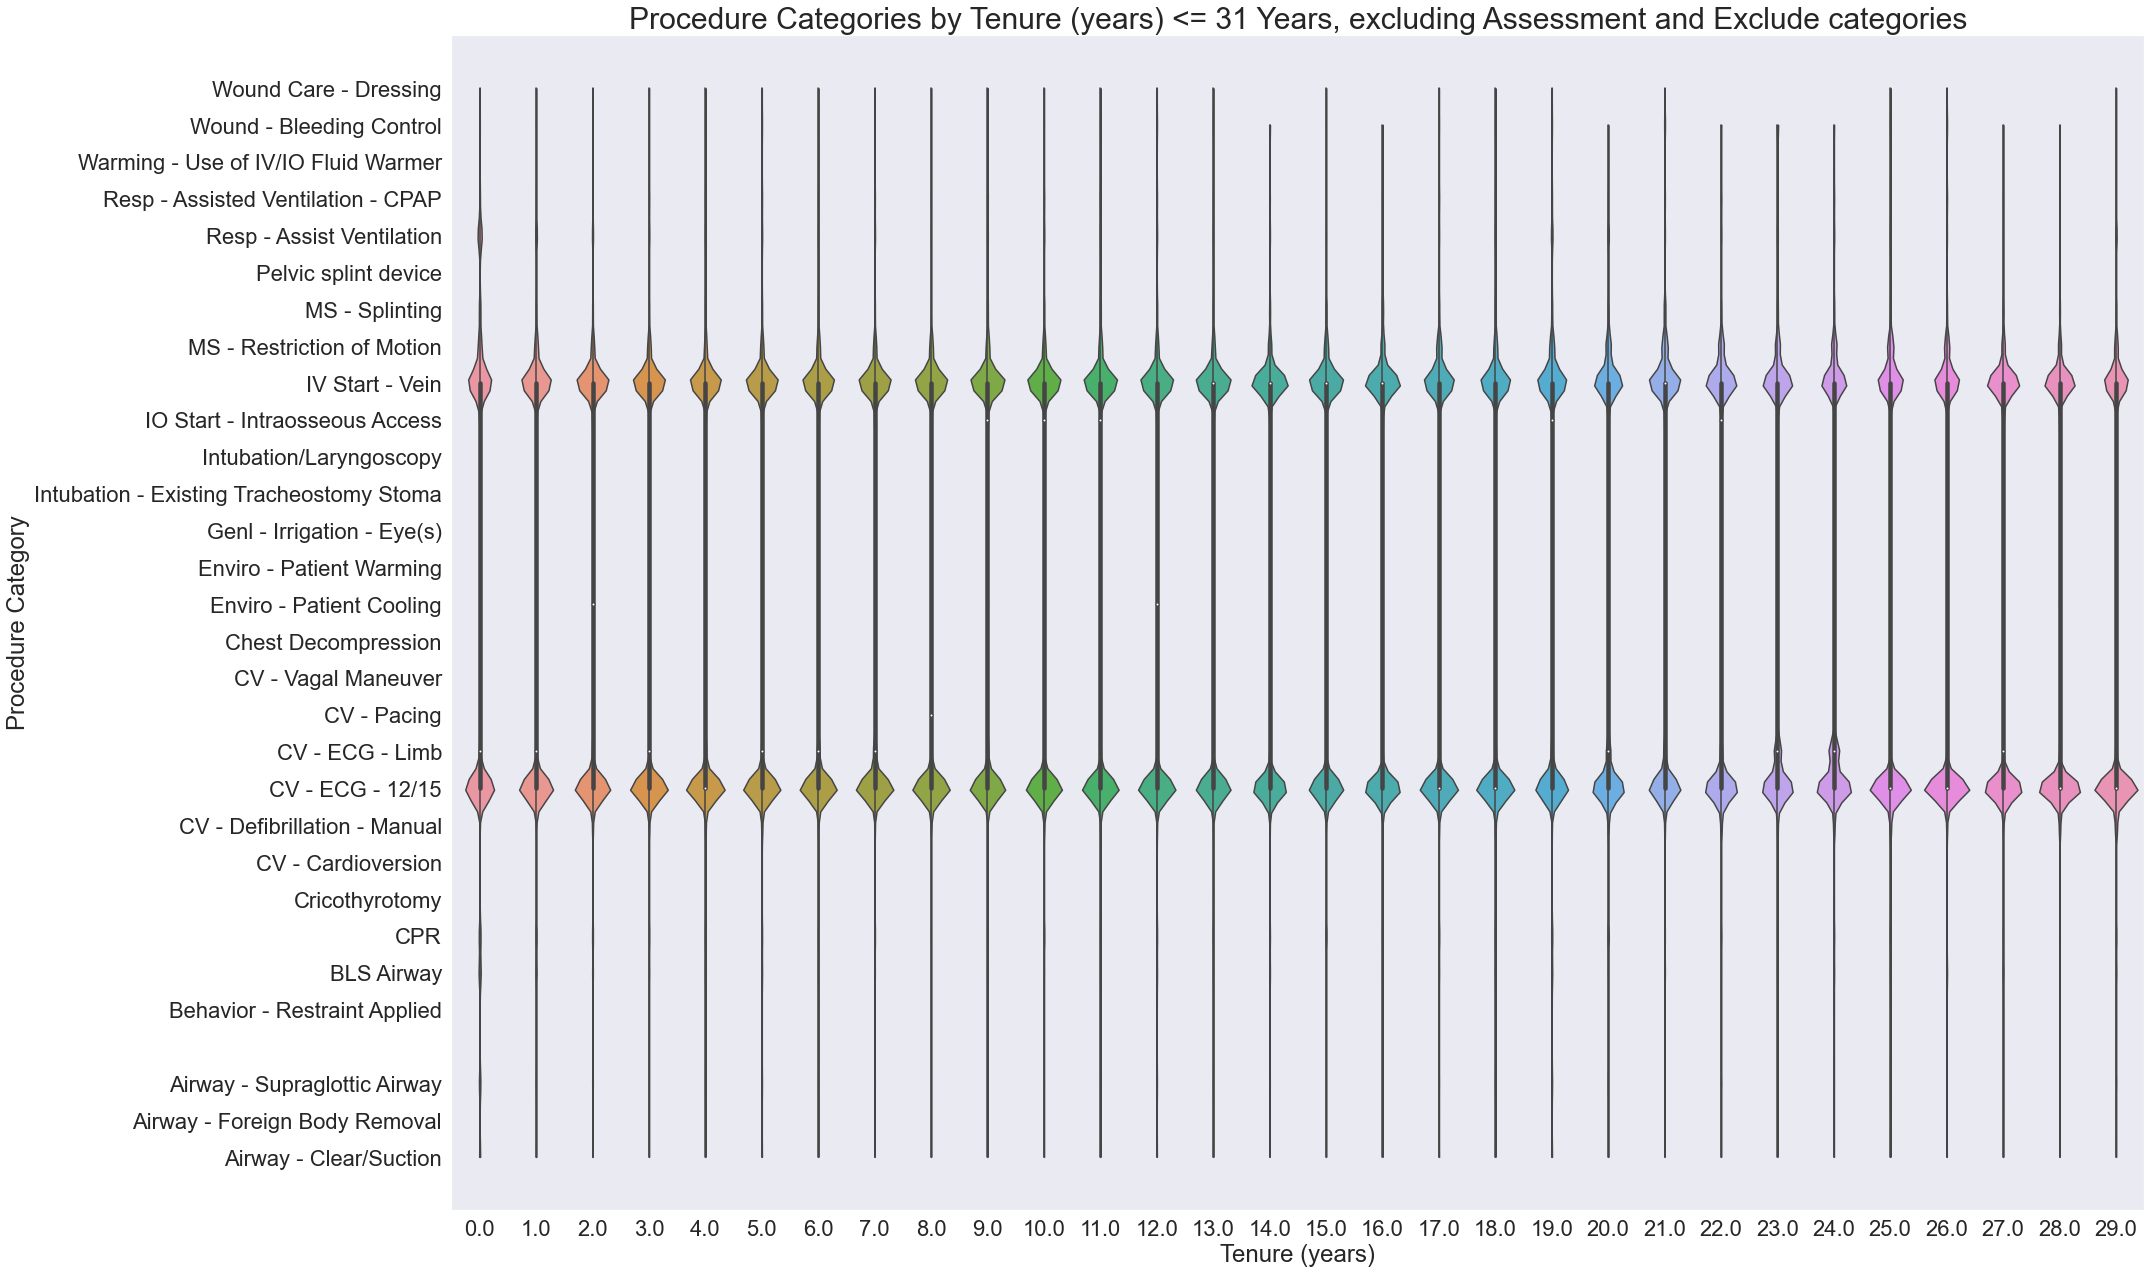

In [215]:
fig, axs = plt.subplots(figsize=(25,18))
#fig.suptitle("Procedure Categories by Tenure (years), excluding Assessment and Exclude categories")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
sns.set(font_scale = 2.5)
sns.violinplot(ax = axs, y="ProcedureCatCode",x="TenureYears",
               data=dfPPBCat_dropexcl_assess_yr, #dfPP_pvt_yr_cat_dropexcl_assess, 
               scale='area',
               bw=.05,
               cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList_dropexcl_assess.index)
axs.set_yticklabels(dfProcCatList_dropexcl_assess.ProcedureCategory.to_list())
axs.set_ylabel("Procedure Category")
axs.set_xlabel("Tenure (years)")
axs.set_title("Procedure Categories by Tenure (years) <= 31 Years, excluding Assessment and Exclude categories")


As expected, the IV Start - Vein and CV - ECG - 12/15 categories are dominant. However, what is different is that these categories are more discernable in the plot than the one above with the same 2 categories removed but does include all tenures.

Let's "flip" the violin and see if there are any unexpected patterns seen when looking at a procedure category across all tenures.

First, plot the COUNT of procedures.

Text(0.5, 1.0, 'Tenure (years) by Procedure Categories (count), excluding Iv Start, ECG 12/15, Assessment and Exclude categories')

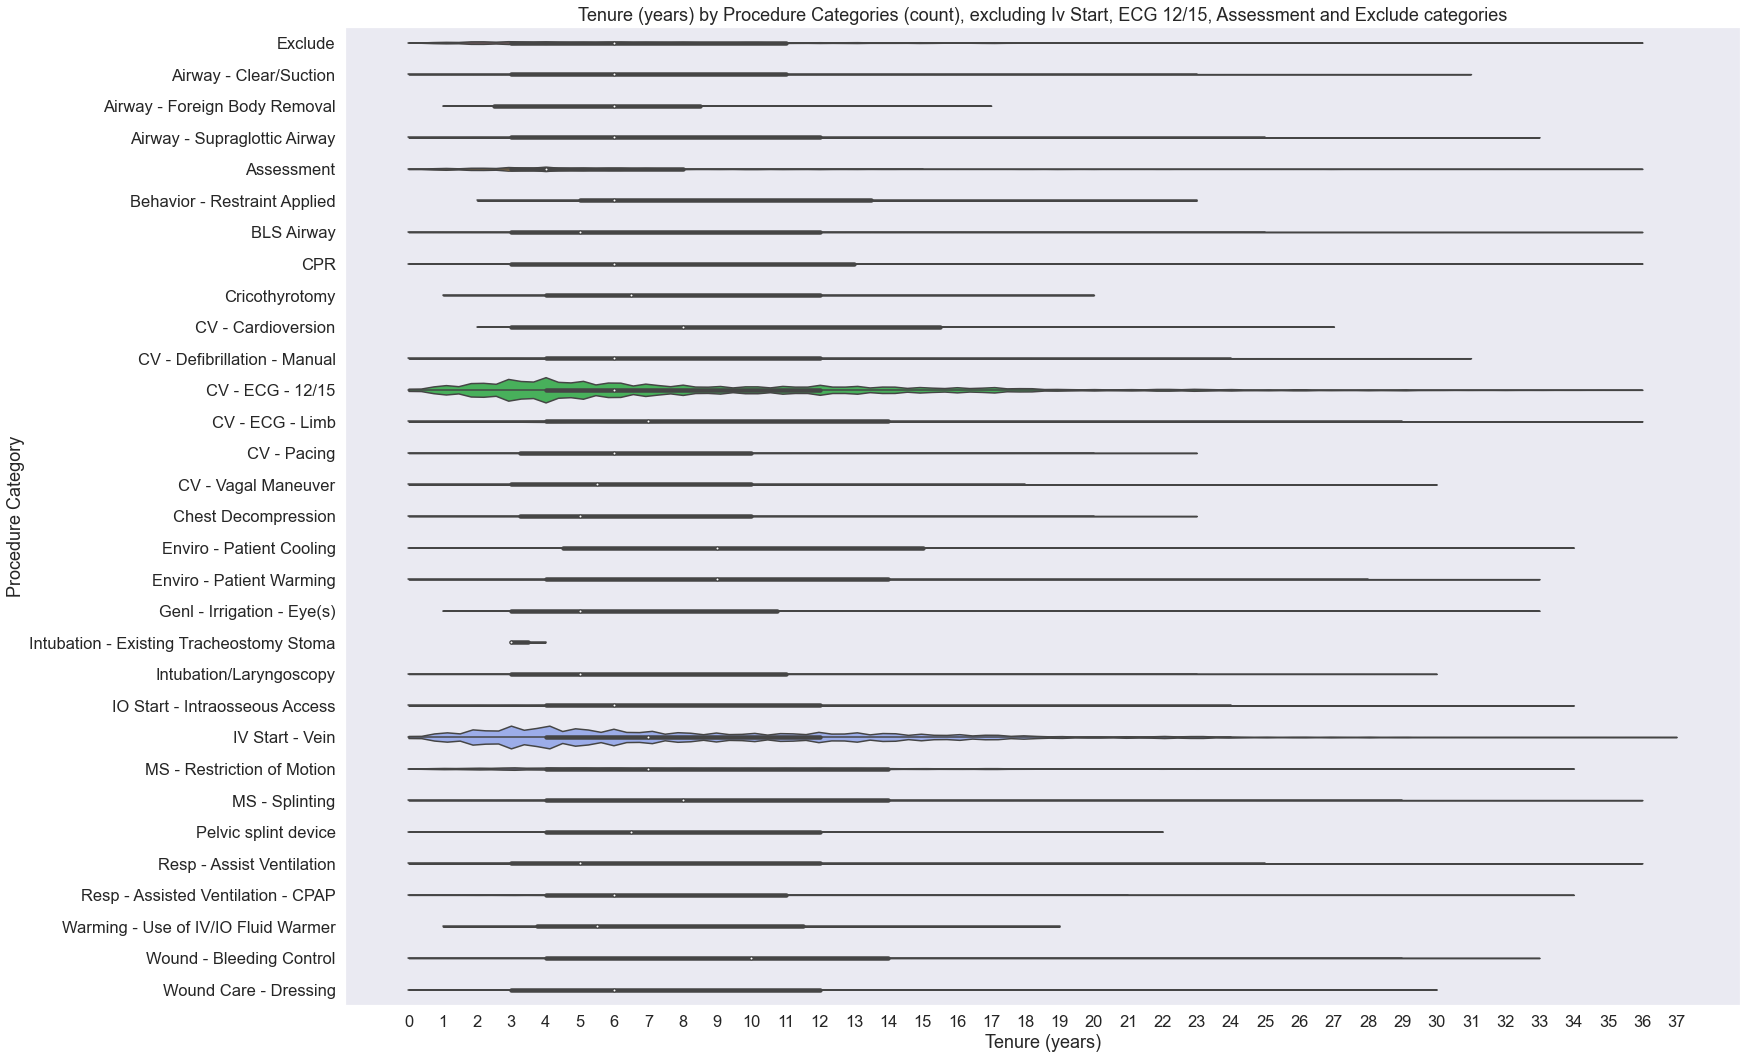

In [128]:
# violin plot of the COUNT
plt.figure(figsize=(25,18))
sns.set(font_scale = 1.5)
ax1=sns.violinplot(x="TenureYears",y="ProcedureCatCode",
               data=dfPPBaselineYrCat,
               scale='count',
               orient='h',
               bw=.05,
               cut=0);
ax1.grid(axis='x', alpha=.75, which='both', color='0.85')
ax1.set_yticks(minor=False, ticks=dfProcCatList.index)
ax1.set_yticklabels(dfProcCatList.ProcedureCategory.to_list())
ax1.set_xticks(ticks=np.arange(0,38))
ax1.set_xlabel("Tenure (years)")
ax1.set_ylabel("Procedure Category")
ax1.set_title("Tenure (years) by Procedure Categories (count), excluding Iv Start, ECG 12/15, Assessment and Exclude categories")


#### What can be seen in this plot is that there are a number of procedure cateogories that are not performed by all tenures.  In fact there is one procedure category that was performed a very limited number of times - Intubation - Existing Tracheostomy Stoma. While there are some procedure categories that were not performed by providers with 2 or less years of tenure, there are more that were not performed by providers with about 17 years or more of tenure.

In [129]:
# how many total Intubation - Existing Tracheostomy Stoma categorized procedures
print(" ".join(["Number of Intubation - Existing Tracheostomy Stoma procedures performed:",
                str(len(dfPPBCat_dropexcl_assess[(dfPPBCat_dropexcl_assess['ProcedureCategory'] == 'Intubation - Existing Tracheostomy Stoma')]))]))


Number of Intubation - Existing Tracheostomy Stoma procedures performed: 3


After dropping the IV Start - Vein and CV - ECG 12/15 categories, the distribution of the CV - ECG - Limb is more easily seen.  In addition to the number of procedures performed by providers with high tenure, it can also be seen that the procedure is still utilized even by providers of low tenure.

Text(0.5, 1.0, 'Tenure (years) by Procedure Categories (count), excluding Iv Start, ECG 12/15, Assessment and Exclude categories')

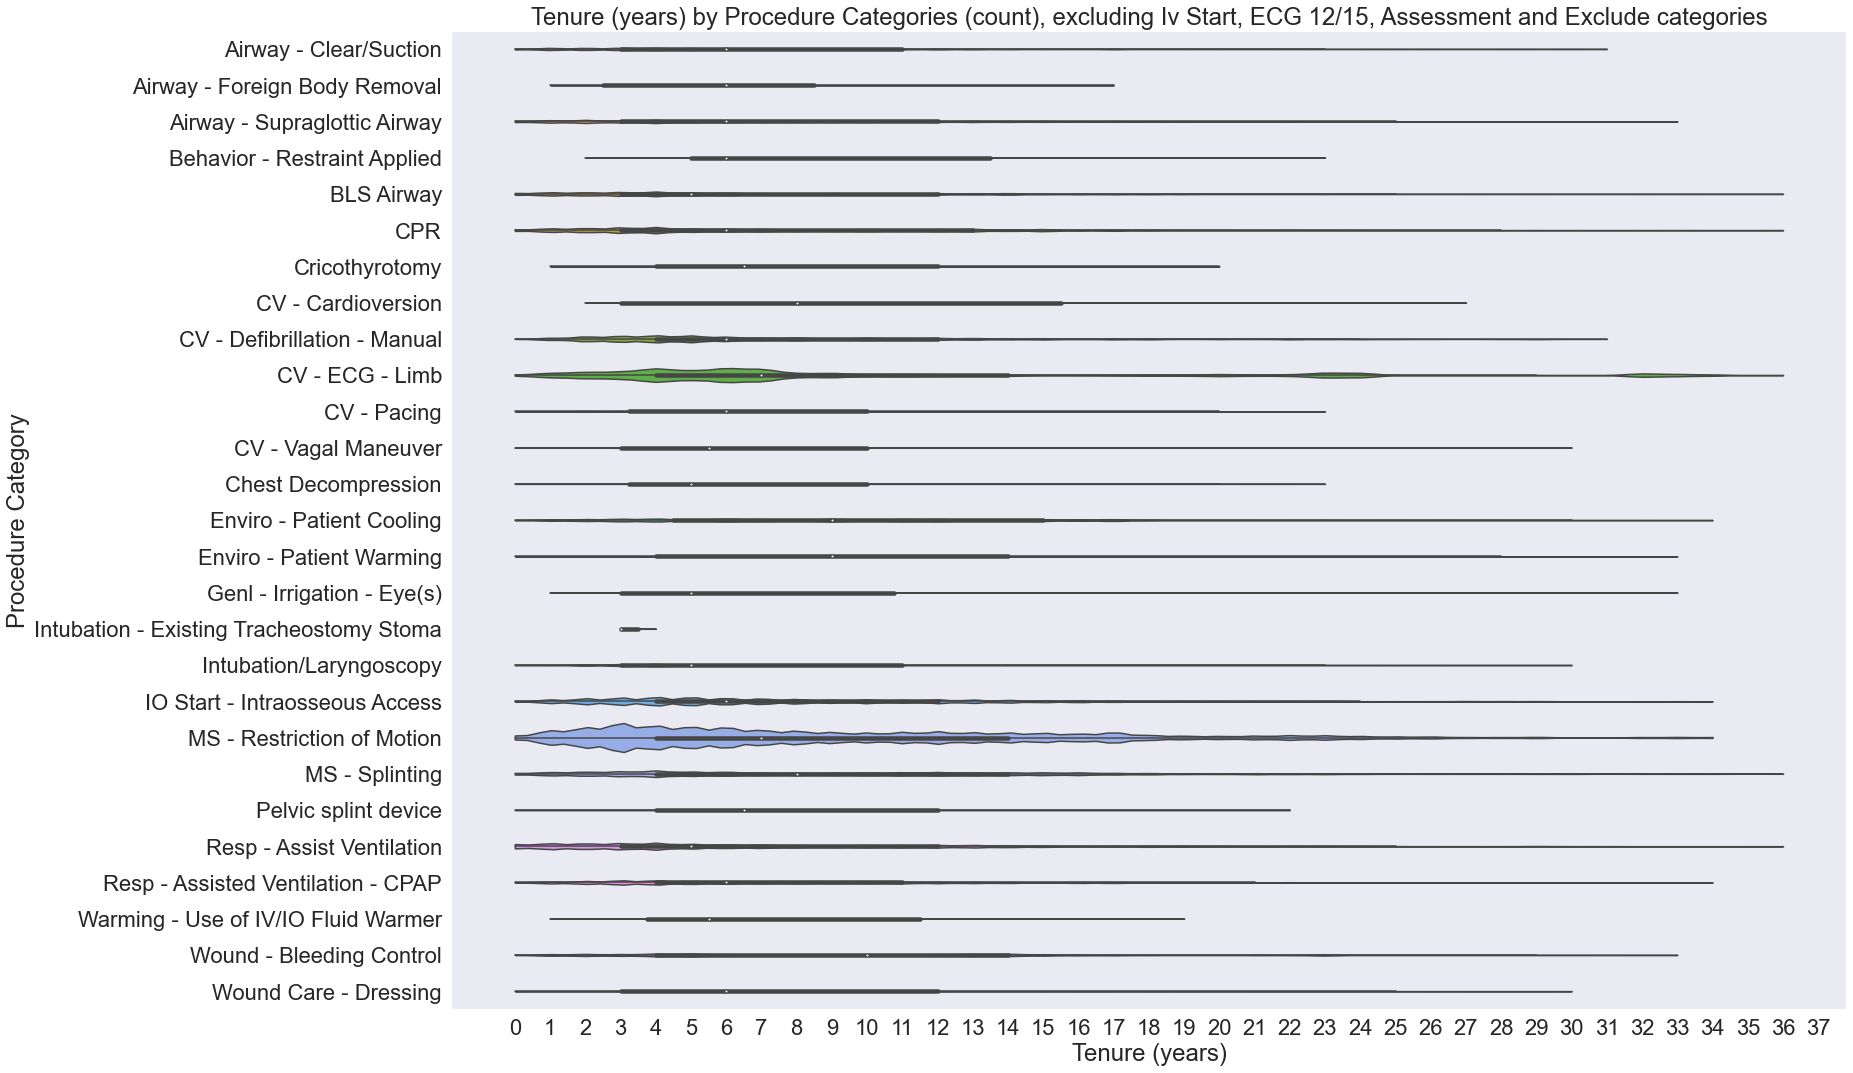

In [130]:
# drop Exclude, Assessment, IV-Start, and ECG 12/15 categories 

plt.figure(figsize=(25,18))
sns.set(font_scale = 2)
ax1=sns.violinplot(x="TenureYears",y="ProcedureCatCode",
               data=dfPPBCat_dropexcl_assess_t2, 
               scale='count',
               orient='h',
               bw=.05,
               cut=0);
ax1.grid(axis='x', alpha=.75, which='both', color='0.85')
#ax1.set_xticks(minor=False, ticks=dfProcCatList.index)
ax1.set_yticklabels(dfProcCatList_dropexcl_assess_t2.ProcedureCategory.to_list())
ax1.set_xticks(ticks=np.arange(0,38))
ax1.set_xlabel("Tenure (years)")
ax1.set_ylabel("Procedure Category")
ax1.set_title("Tenure (years) by Procedure Categories (count), excluding Iv Start, ECG 12/15, Assessment and Exclude categories")


Now, using the tenure groupings to see if there are any differences that way.

Starting with a violin plot showing the COUNTS.

Text(0.5, 74.5, 'Tenure in Year Grouping')

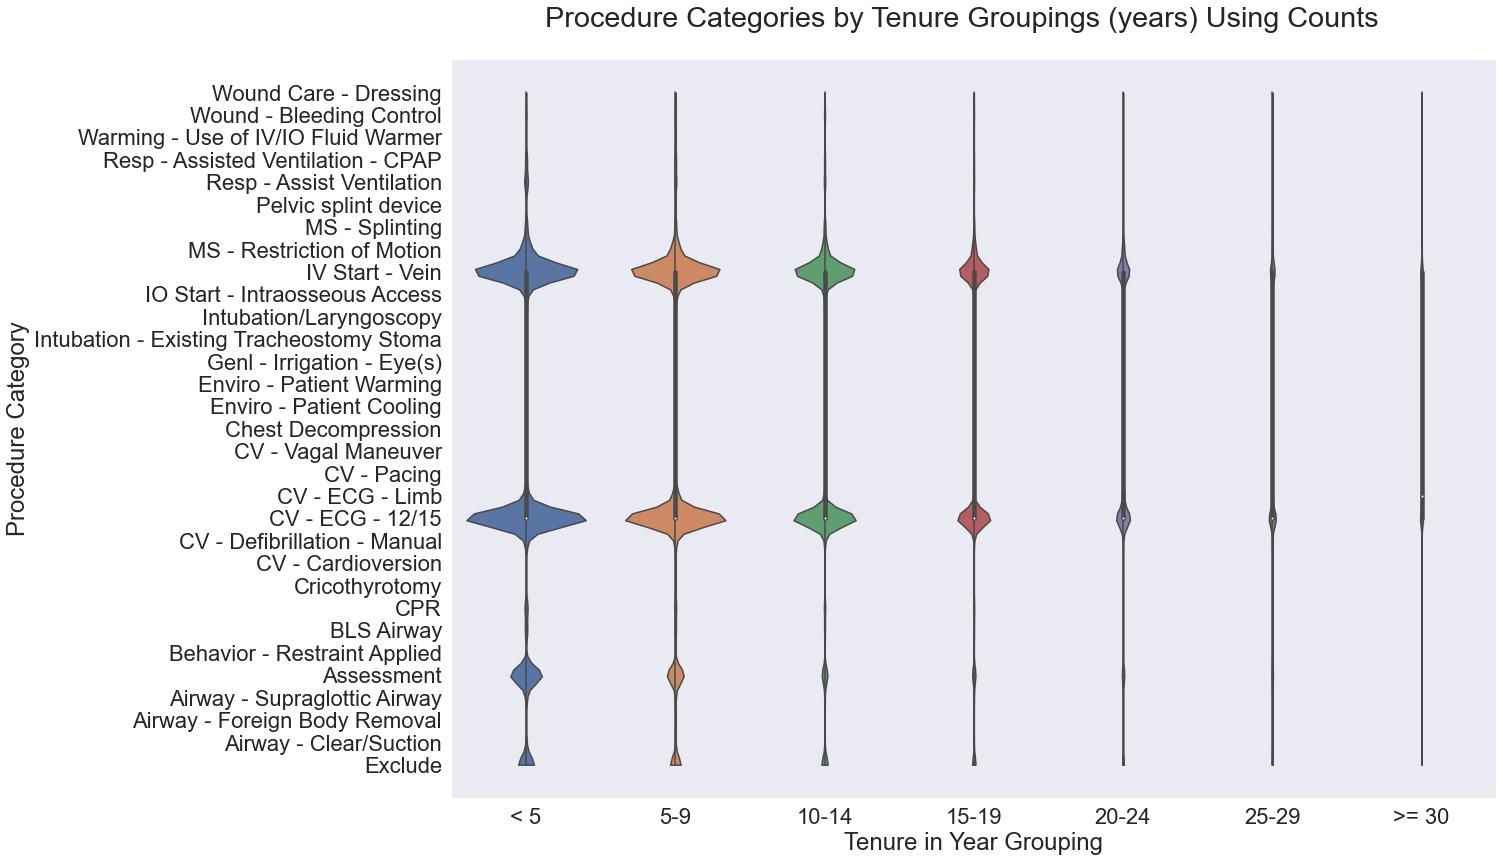

In [212]:
# violin plot showing procedure categories and tenure groupings - COUNTS
fig, axs = plt.subplots(figsize=(16,12))
fig.suptitle("Procedure Categories by Tenure Groupings (years) Using Counts")
fig.tight_layout()
fig.subplots_adjust(top=0.92)
sns.set(font_scale = 1.25)
sns.violinplot(ax = axs, y="ProcedureCatCode",x="YearGroup",
               data=dfPPBaselineYrCat.sort_values(by=['ProcedureCatCode','YearGrpCode']),
               scale='count',
               bw=.05,
               cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList.index)
axs.set_yticklabels(dfProcCatList.ProcedureCategory.to_list())
axs.set_ylabel("Procedure Category")
axs.set_xlabel("Tenure in Year Grouping")


There is nothing unexpected seen. What is evident is the reduction in counts as tenure increases.

Text(0.5, 77.5, 'Tenure in Year Grouping')

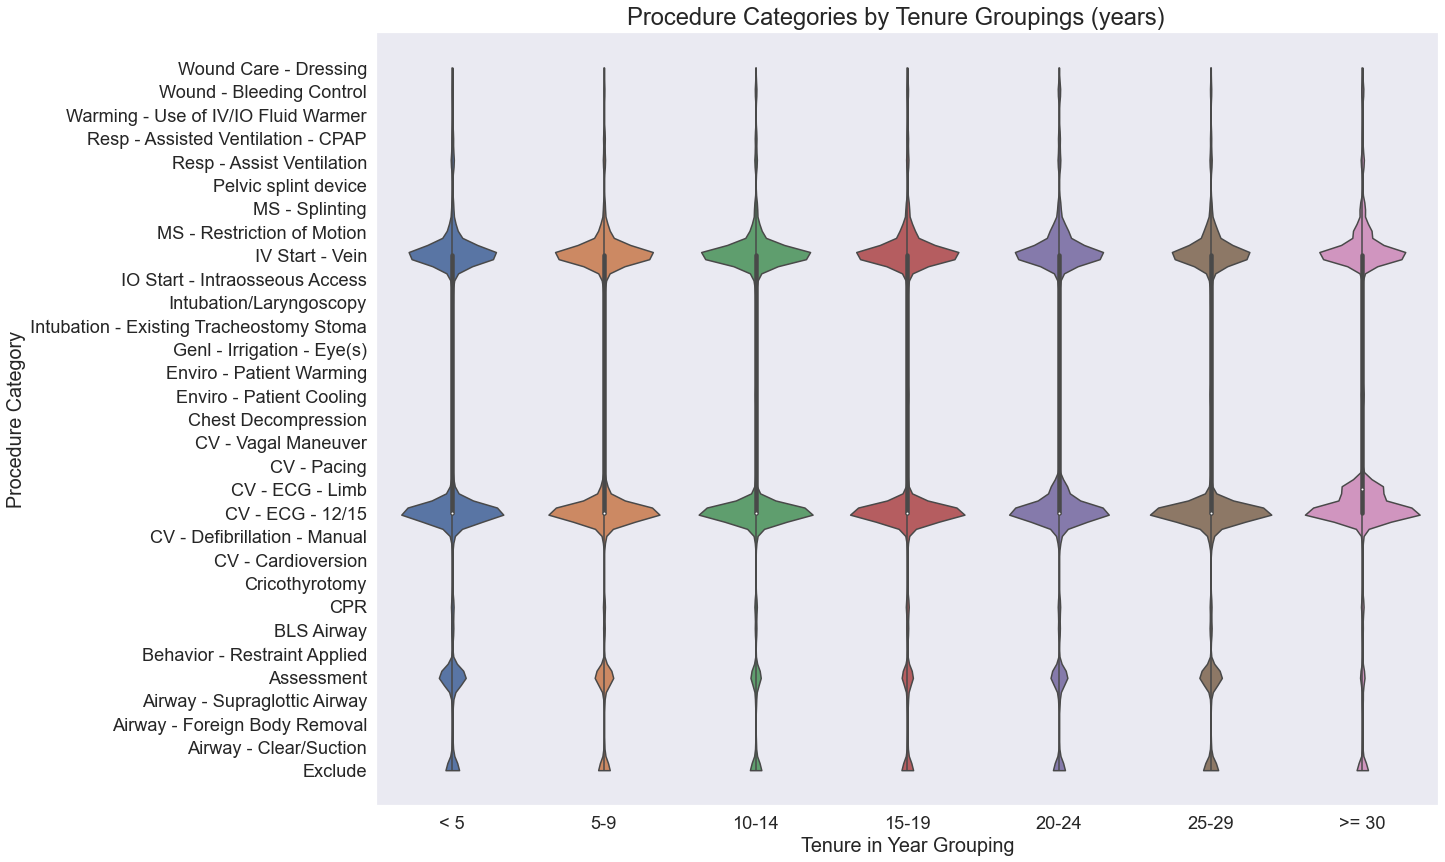

In [201]:
# violin plot showing all procedure categories and tenure groupings - area
fig, axs = plt.subplots(figsize=(16,12))
fig.suptitle("Procedure Categories by Tenure Groupings (years)")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
sns.set(font_scale = 2)
sns.violinplot(ax = axs, y="ProcedureCatCode",x="YearGroup",
               data=dfPPBaselineYrCat.sort_values(by=['ProcedureCatCode','YearGrpCode']),
               scale='area',
               bw=.05,
               cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList.index)
axs.set_yticklabels(dfProcCatList.ProcedureCategory.to_list())
axs.set_ylabel("Procedure Category")
axs.set_xlabel("Tenure in Year Grouping")
#axs.set_title("Procedure Categories by Tenure Grouping (years)")

Showing the same plot using area instead of counts, displays the increase in the use of the CV - ECG - Limb procedures by providers with higher tenure, especially those with 30 or more years.

Text(0.5, 74.5, 'Tenure in Year Grouping')

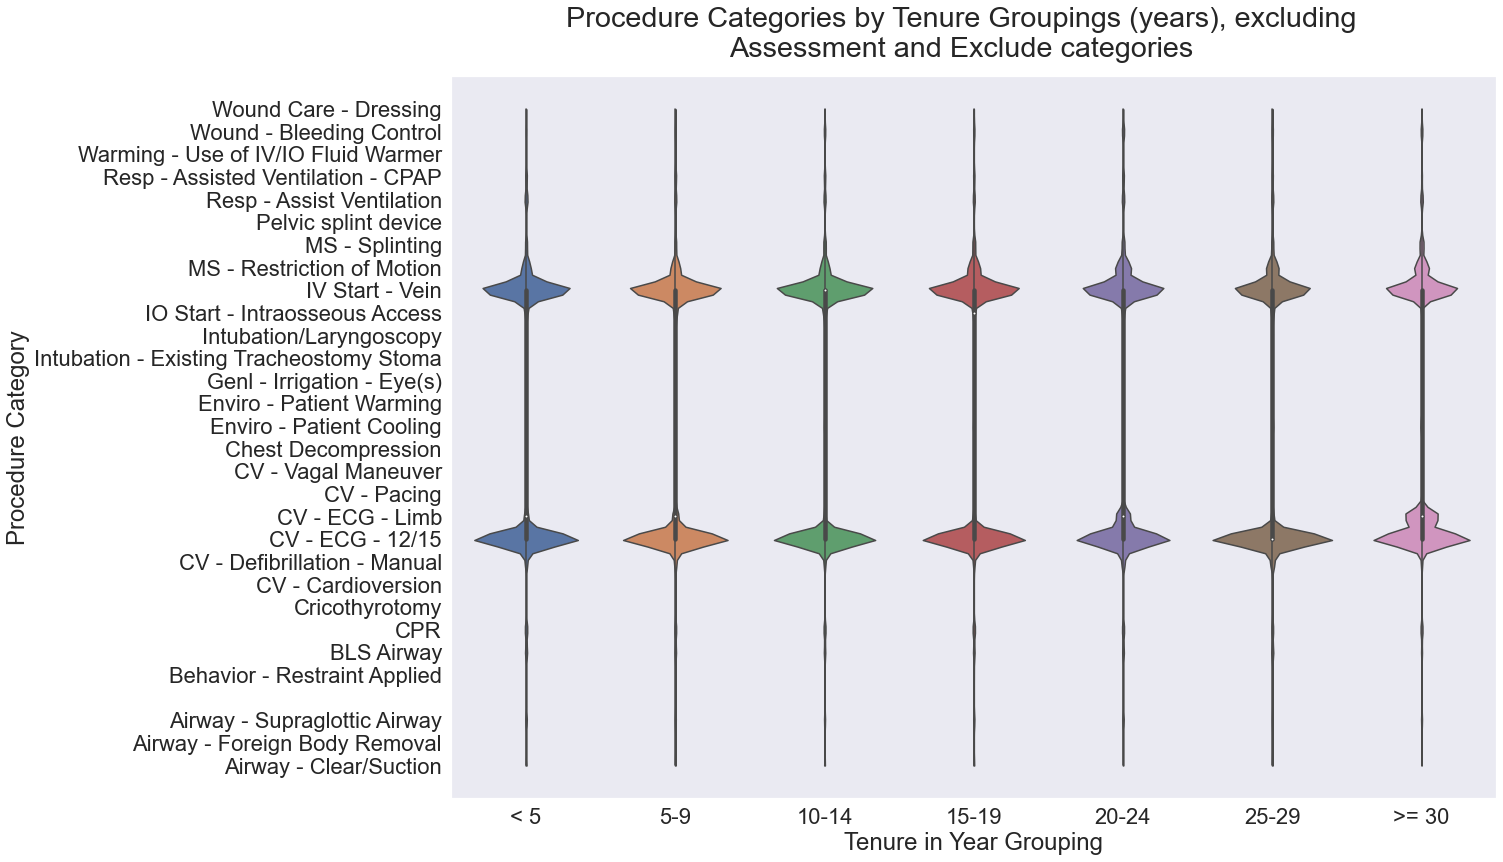

In [211]:
# violin plot showing procedure categories (except Assessment and Exclude) and tenure groupings - area
fig, axs = plt.subplots(figsize=(16,12))
fig.suptitle("Procedure Categories by Tenure Groupings (years), excluding\nAssessment and Exclude categories")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
sns.set(font_scale = 2)
sns.violinplot(ax = axs, y="ProcedureCatCode",x="YearGroup",
               data=dfPPBCat_dropexcl_assess.sort_values(by=['ProcedureCatCode','YearGrpCode']), 
               scale='area',
               bw=.05,
               cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList_dropexcl_assess.index)
axs.set_yticklabels(dfProcCatList_dropexcl_assess.ProcedureCategory.to_list())
axs.set_ylabel("Procedure Category")
axs.set_xlabel("Tenure in Year Grouping")

Removing the Assessment and Exclude categories only emphasises the use of CV - ECG - Limb procedures by providers of higher tenure.  What is also emphasized a bit more clearly than before is Restriction of Motion and Splinting procedures.

Text(0.5, 74.5, 'Tenure in Year Grouping')

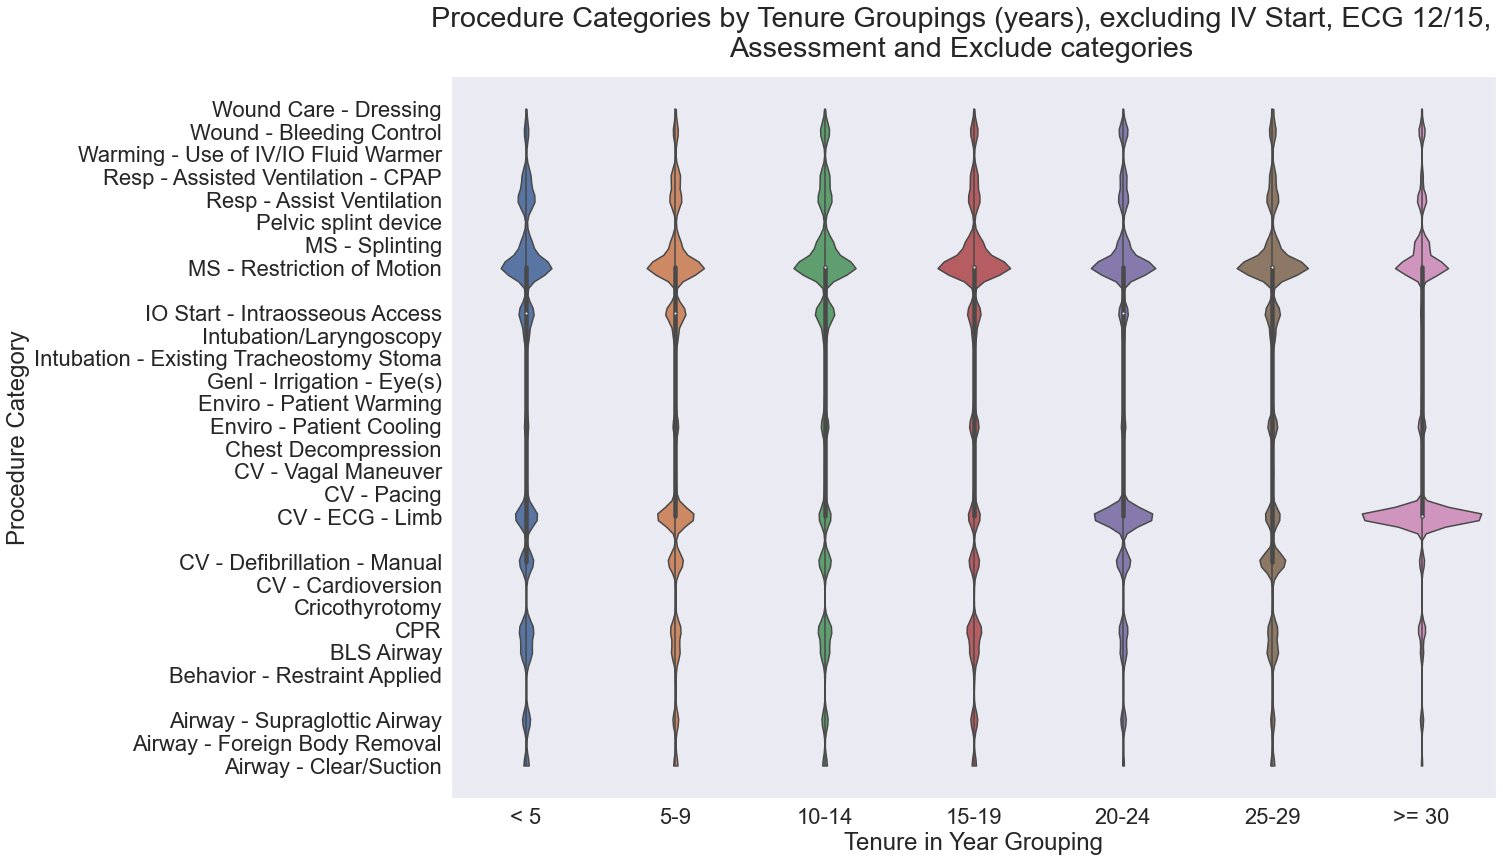

In [209]:
# violin plot showing procedure categories (except Assessment, Exclude, IV Start - Vein, and CV - ECG - 12/15) and tenure groupings - area
fig, axs = plt.subplots(figsize=(16,12))
fig.suptitle("Procedure Categories by Tenure Groupings (years), excluding IV Start, ECG 12/15,\nAssessment and Exclude categories")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
sns.set(font_scale = 2)
sns.violinplot(ax = axs, y="ProcedureCatCode",x="YearGroup",
               data=dfPPBCat_dropexcl_assess_t2.sort_values(by=['ProcedureCatCode','YearGrpCode']), 
               scale='area',
               bw=.05,
               cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList_dropexcl_assess_t2.index)
axs.set_yticklabels(dfProcCatList_dropexcl_assess_t2.ProcedureCategory.to_list())
axs.set_ylabel("Procedure Category")
axs.set_xlabel("Tenure in Year Grouping")

Further removing the IV Start - Vein and CV - ECG - 12/15 procedure categories, it is very easy to how the use of CV - ECG - Limb procedures are distributed across the tenure year groupings. The overall pattern of high procedure categories is the same across all tenure year groupings.  

Text(0.5, 74.5, 'Tenure in Year Grouping')

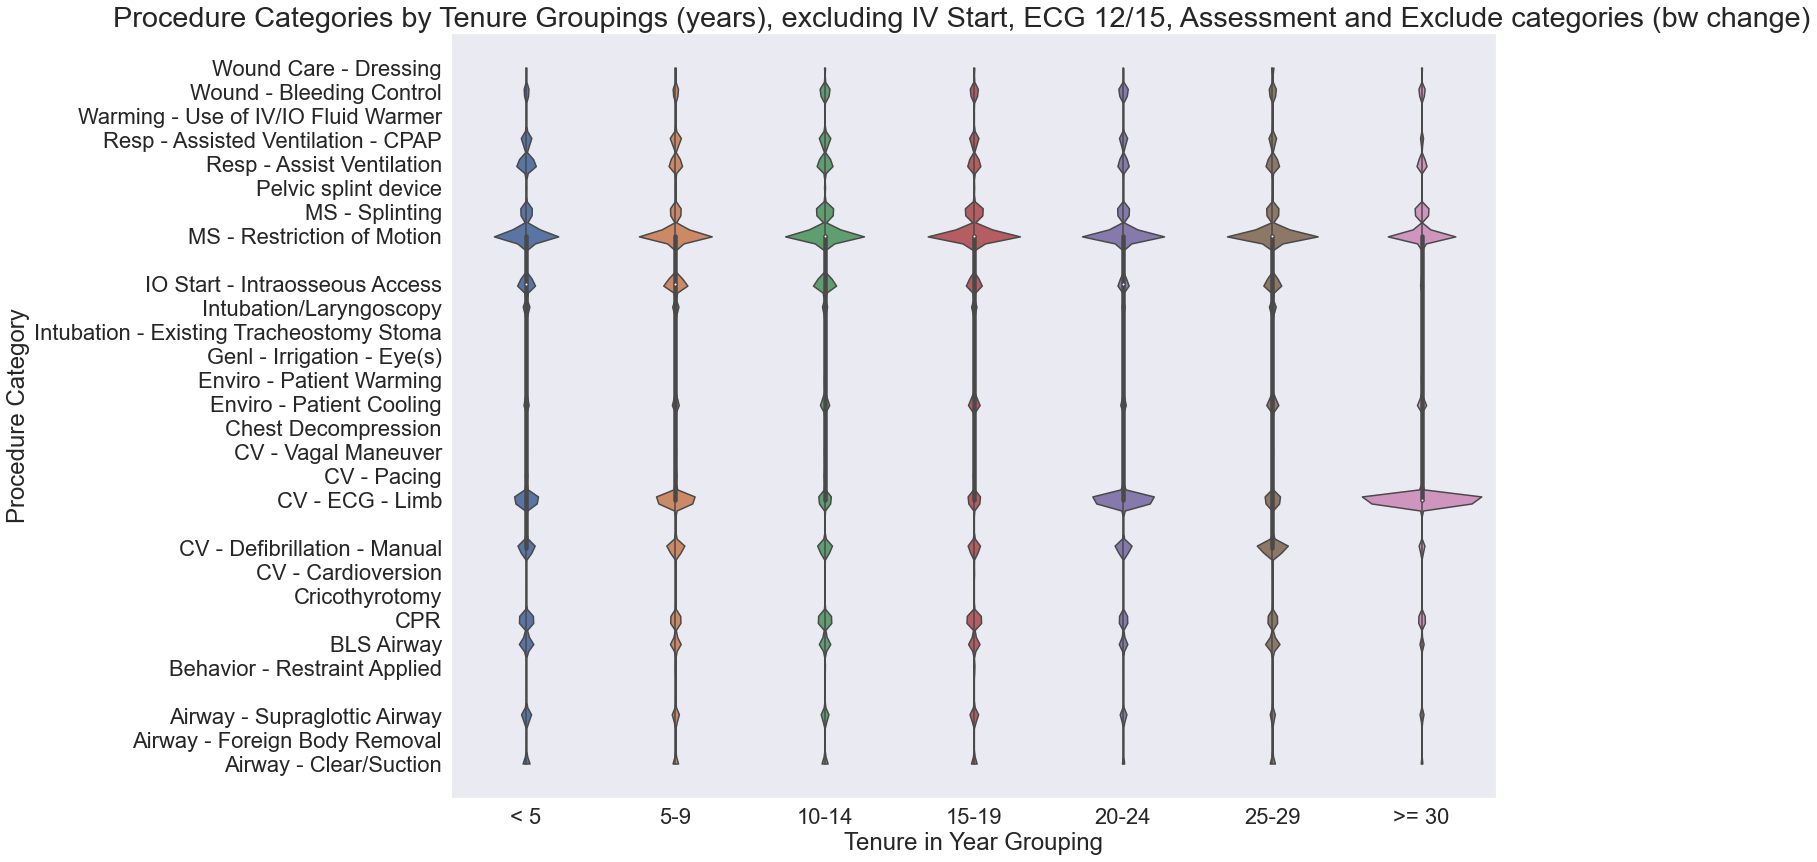

In [205]:
# same violin plot, except with bw set to 0.25

fig, axs = plt.subplots(figsize=(16,12))
fig.suptitle("Procedure Categories by Tenure Groupings (years), excluding IV Start, ECG 12/15, Assessment and Exclude categories (bw change)")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
sns.set(font_scale = 2)
sns.violinplot(ax = axs, y="ProcedureCatCode",x="YearGroup",
               data=dfPPBCat_dropexcl_assess_t2.sort_values(by=['ProcedureCatCode','YearGrpCode']), 
               scale='area',
               bw=.025,
               cut=0);
axs.grid(axis='y', alpha=.75, which='both')
axs.set_yticks(minor=False, ticks=dfProcCatList_dropexcl_assess_t2.index)
axs.set_yticklabels(dfProcCatList_dropexcl_assess_t2.ProcedureCategory.to_list())
axs.set_ylabel("Procedure Category")
axs.set_xlabel("Tenure in Year Grouping")


Building a new dataframe that can be used to generate a treemap of the tenure year groupings and procedure categories.

In [136]:
# building a new dataframe using tenure year groupings and procedure categories in hierarchy
dfPPB_yrcat = dfPPBaselineYrCat.groupby(["YearGrpCode",
                                      "YearGroup",
                                      "ProcedureCatCode",
                                      "ProcedureCategory"]).size().to_frame(name="Procedure_Count").reset_index()
dfPPB_yrcat.head(2)

YearGrpCode YearGroup  ProcedureCatCode       ProcedureCategory  \
0            0       < 5                 0                 Exclude   
1            0       < 5                 1  Airway - Clear/Suction   

   Procedure_Count  
0             2989  
1              212

In [137]:
# treemap of dfPPB_yrcat
# if run under jupyter lab, chart will not display
df = dfPPB_yrcat.copy()
fig = px.treemap(df, path=['YearGroup','ProcedureCategory'], values='Procedure_Count',
                 color="Procedure_Count", color_continuous_scale=colorMap)
fig.data[0].textinfo = 'label+text+value'
fig.layout.hovermode = False
fig.show()

In [138]:
# drop Exclude category
dfPPB_yrcat_dropexcl = dfPPB_yrcat[(dfPPB_yrcat['ProcedureCatCode'] != 0)]
print("Drop Exclude Category")
print(dfPPB_yrcat_dropexcl[(dfPPB_yrcat_dropexcl['ProcedureCategory'] == 'Exclude')].value_counts())

# drop Exclude and Assessment categories
dfPPB_yrcat_dropexcl_assess = dfPPB_yrcat[(dfPPB_yrcat['ProcedureCatCode'] != 0) & 
                                          (dfPPB_yrcat['ProcedureCatCode'] != 4)]
print("Drop Exclude & Assessment Categories")
print(dfPPB_yrcat_dropexcl_assess[(dfPPB_yrcat_dropexcl_assess['ProcedureCategory'] == 'Assessment')].value_counts())

# drop Exclude, Assessment, IV Start, and CV - ECG categories
dfPPB_yrcat_dropexcl_assess_t2 = dfPPB_yrcat[(dfPPB_yrcat['ProcedureCatCode'] != 0) & 
                                             (dfPPB_yrcat['ProcedureCatCode'] != 4) &
                                             (dfPPB_yrcat['ProcedureCatCode'] != 11)  &
                                             (dfPPB_yrcat['ProcedureCatCode'] != 22)]
print("Drop Exclude, Assessment, IV Start, and CV - ECG Categories")
print(dfPPB_yrcat_dropexcl_assess_t2[(dfPPB_yrcat_dropexcl_assess_t2['ProcedureCategory'] == 'Assessment')].value_counts())

dfPPB_yrcat_dropexcl_assess_t2

Drop Exclude Category
Series([], dtype: int64)
Drop Exclude & Assessment Categories
Series([], dtype: int64)
Drop Exclude, Assessment, IV Start, and CV - ECG Categories
Series([], dtype: int64)


YearGrpCode YearGroup  ProcedureCatCode  \
1              0       < 5                 1   
2              0       < 5                 2   
3              0       < 5                 3   
5              0       < 5                 5   
6              0       < 5                 6   
..           ...       ...               ...   
189            6     >= 30                24   
190            6     >= 30                26   
191            6     >= 30                27   
192            6     >= 30                29   
193            6     >= 30                30   

                      ProcedureCategory  Procedure_Count  
1                Airway - Clear/Suction              212  
2         Airway - Foreign Body Removal                8  
3          Airway - Supraglottic Airway              317  
5          Behavior - Restraint Applied               16  
6                            BLS Airway              443  
..                                  ...              ...  
189                      MS - Splinting               25  
190           Resp - Assist Ventilation               15  
191  Resp - Assisted Ventilation - CPAP                4  
192            Wound - Bleeding Control               10  
193               Wound Care - Dressing                1  

[166 rows x 5 columns]

In [139]:
# treemap of dfPPB_yrcat_dropexcl_assess_t2
# if run under jupyter lab, chart will not display
df = dfPPB_yrcat_dropexcl_assess_t2[dfPPB_yrcat_dropexcl_assess_t2['YearGrpCode'] == 0].copy()
fig = px.treemap(df, path=['YearGroup','ProcedureCategory'], values='Procedure_Count',
                 color="Procedure_Count", color_continuous_scale=colorMap)
fig.data[0].textinfo = 'label+text+value'
fig.layout.hovermode = False
fig.show()

df = dfPPB_yrcat_dropexcl_assess_t2[dfPPB_yrcat_dropexcl_assess_t2['YearGrpCode'] == 1].copy()
fig = px.treemap(df, path=['YearGroup','ProcedureCategory'], values='Procedure_Count',
                 color="Procedure_Count", color_continuous_scale=colorMap)
fig.data[0].textinfo = 'label+text+value'
fig.layout.hovermode = False
fig.show()

df = dfPPB_yrcat_dropexcl_assess_t2[dfPPB_yrcat_dropexcl_assess_t2['YearGrpCode'] == 6].copy()
fig = px.treemap(df, path=['YearGroup','ProcedureCategory'], values='Procedure_Count',
                 color="Procedure_Count", color_continuous_scale=colorMap)
fig.data[0].textinfo = 'label+text+value'
fig.layout.hovermode = False
fig.show()

### Conclusions

There are procedures that are more utilized by providers of low tenure and providers of high tenure.  For the providers of low tenure, these procedures are related to the assessment of the patient; for providers of high tenure the procedure most evident is that of Cv - ECG - Limb Lead Montioring.

Both of these instances are explainable. The first, for the providers of low tenure, is because these providers are the most evaluated for documenting all actions taken. As providers gain tenure, their record keeping is still reviewed for quality assurance/control but not to level of those most recently out of training.  The second, for the providers of high tenure, reveals a tendancy to revert back to original training.